In [1]:
#run for colab only

!git clone https://github.com/hungpham13/federated-learning
%cd federated-learning
!pip install -q -r requirements.txt
!gdown https://drive.google.com/uc?id=1hTHuOaXQbtdDKvvRqvtmGTpT4TAqUvLs
! unzip -qq -o ./images-fd.zip -d ./data
! mv ./data/images-fd ./data/images

Cloning into 'federated-learning'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 165 (delta 102), reused 94 (delta 43), pack-reused 0
Receiving objects: 100% (165/165), 4.23 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (102/102), done.
/content/federated-learning
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.8

In [2]:
import flwr as fl
from config import NUM_CLIENTS, DEVICE, CLASSES
from model import Net, VGG16
from main import simulate
import matplotlib.pyplot as plt

from dataloader import load_cifars, load_fitzpatrick

## Visuzalize the dataset

train set loaded, length:  14778
test set loaded, length:  1644


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


image shape (64, 64, 3)


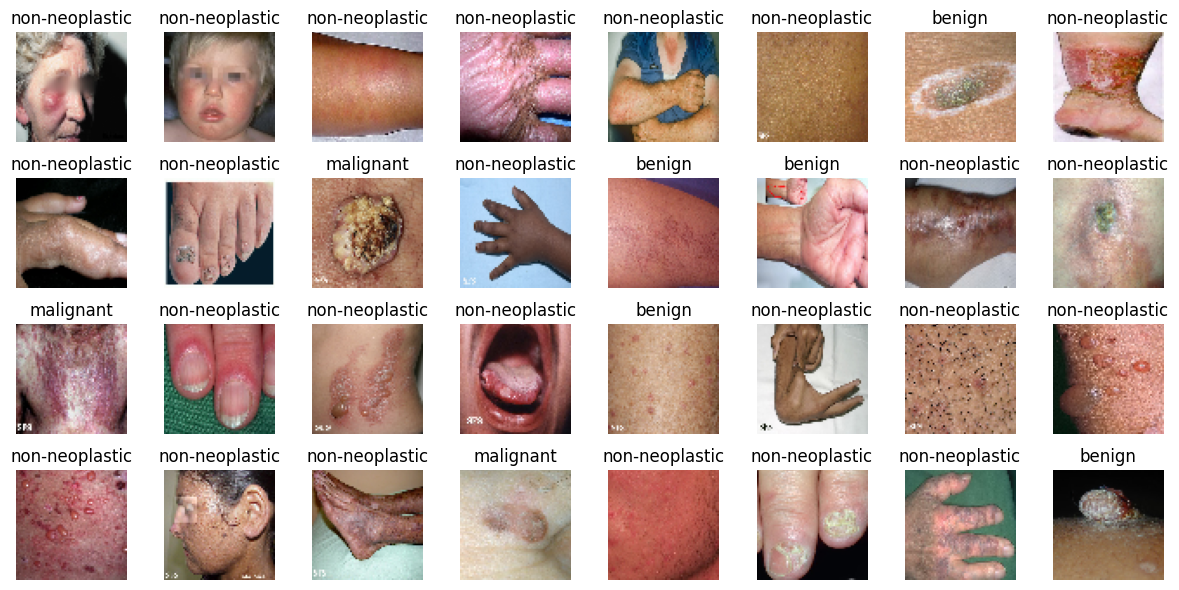

In [3]:
trainloaders, valloaders, testloader = load_fitzpatrick(1, './data/images')
# trainloaders, valloaders, testloader = load_cifars(1)

images, labels = next(iter(testloader))


# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

print('image shape', images[0].shape)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

## Centralize training

In [ ]:
trainloaders, valloaders, testloader = load_fitzpatrick(1, './data/images/')

trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net(focus_label=2, num_classes=3).to(DEVICE)

for epoch in range(3):
    net.train_epoch(trainloader, 1)
    loss, accuracy, precision = net.test(valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}, precision of {CLASSES[net.focus_label]} {precision}")

loss, accuracy,precision = net.test(testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}\n\tprecision of {CLASSES[net.focus_label]} {precision}")

train set loaded, length:  14777
test set loaded, length:  1645


/home/hung/PythonProject/federated-learning/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Fed Average

In [4]:
strategyConfig = {
    "fraction_fit":0.3,
    "fraction_evaluate":0.3,
    "min_fit_clients":3,
    "min_evaluate_clients":3,
    "min_available_clients":NUM_CLIENTS,
}
loaders = load_fitzpatrick(NUM_CLIENTS, './data/images')

train set loaded, length:  14779
test set loaded, length:  1635


In [ ]:
net = Net(focus_labels=[1,2], num_classes=3).to(DEVICE)
simulate(StrategyCls=fl.server.strategy.FedAvg, strategyArgs=strategyConfig, net=net, loaders=loaders, num_rounds=50)

In [ ]:
net = VGG16(focus_labels=[1,2], num_classes=3).to(DEVICE)
simulate(StrategyCls=fl.server.strategy.FedAvg, strategyArgs=strategyConfig, net=net, loaders=loaders, num_rounds=50)

INFO flwr 2023-06-12 02:57:20,387 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-06-12 02:57:23,030	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-12 02:57:24,620 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3933420748.0, 'memory': 7866841499.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3933420748.0, 'memory': 7866841499.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-06-12 02:57:24,623 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-12 02:57:24,625 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-12 02:57:24,627 | server.py:88 |

Server-side evaluation loss 0.035149140168402905 / accuracy 0.1363914373088685 / precision {'non-neoplastic': None, 'malignant': 0.1363914373088685}


(pid=3189) 2023-06-12 02:57:58.212572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3189) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_fit pid=3189) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=3189)   warnings.warn(


(launch_and_fit pid=3189) Epoch 1: train loss 0.03132092207670212, accuracy 0.706015037593985
(launch_and_fit pid=3189) 	precision: {'non-neoplastic': 0.7378872120730738, 'malignant': 0.15625}


(pid=3366) 2023-06-12 02:58:28.462773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3366) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_fit pid=3366) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=3366)   warnings.warn(


(launch_and_fit pid=3366) Epoch 1: train loss 0.03050493821501732, accuracy 0.7218045112781954
(launch_and_fit pid=3366) 	precision: {'non-neoplastic': 0.7535657686212361, 'malignant': 0.14035087719298245}


(pid=3544) 2023-06-12 02:59:00.438804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=3544) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_fit pid=3544) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=3544)   warnings.warn(


(launch_and_fit pid=3544) Epoch 1: train loss 0.0363130196928978, accuracy 0.681203007518797
(launch_and_fit pid=3544) 	precision: {'non-neoplastic': 0.7168, 'malignant': 0.1016949152542373}


DEBUG flwr 2023-06-12 02:59:29,083 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-12 02:59:29,475 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-06-12 02:59:54,676 | server.py:119 | fit progress: (1, 0.02490680582297322, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 119.49133414099992)
INFO:flwr:fit progress: (1, 0.02490680582297322, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 119.49133414099992)
DEBUG flwr 2023-06-12 02:59:54,681 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02490680582297322 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=3839) 2023-06-12 02:59:58.892815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3839) [Client 7] evaluate, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_evaluate pid=3839) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=3839)   warnings.warn(
(pid=3920) 2023-06-12 03:00:07.230938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=3920) [Client 8] evaluate, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_evaluate pid=3920)   warnings.warn(
(launch_and_evaluate pid=3920)   warnings.warn(
(pid=4001) 2023-06-12 03:00:17.636895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=4001) [Client 2] evaluate, config: {'server_round': 1, 'local_epochs': 1}


(launch_and_evaluate pid=4001) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=4001)   warnings.warn(
DEBUG flwr 2023-06-12 03:00:24,709 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:00:24,712 | server.py:218 | fit_

(launch_and_fit pid=4088) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_fit pid=4088) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=4088)   warnings.warn(


(launch_and_fit pid=4088) Epoch 1: train loss 0.030235912650823593, accuracy 0.7263157894736842
(launch_and_fit pid=4088) 	precision: {'non-neoplastic': 0.7334851936218679, 'malignant': 0.0}
(launch_and_fit pid=4088) Epoch 2: train loss 0.025956783443689346, accuracy 0.7278195488721805
(launch_and_fit pid=4088) 	precision: {'non-neoplastic': 0.7342444950645406, 'malignant': 0.0}


(pid=4383) 2023-06-12 03:01:24.971296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4383) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_fit pid=4383) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=4383)   warnings.warn(


(launch_and_fit pid=4383) Epoch 1: train loss 0.02845100685954094, accuracy 0.7263157894736842
(launch_and_fit pid=4383) 	precision: {'non-neoplastic': 0.7362385321100917, 'malignant': 0.09090909090909091}
(launch_and_fit pid=4383) Epoch 2: train loss 0.025458863005042076, accuracy 0.7315789473684211
(launch_and_fit pid=4383) 	precision: {'non-neoplastic': 0.735249621785174, 'malignant': 0.3333333333333333}


(pid=4654) 2023-06-12 03:02:18.451605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=4654) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_fit pid=4654) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=4654)   warnings.warn(


(launch_and_fit pid=4654) Epoch 1: train loss 0.029250722378492355, accuracy 0.6977443609022557
(launch_and_fit pid=4654) 	precision: {'non-neoplastic': 0.7075978511128166, 'malignant': 0.29411764705882354}


DEBUG flwr 2023-06-12 03:03:10,731 | server.py:232 | fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=4654) Epoch 2: train loss 0.02821803279221058, accuracy 0.6969924812030075
(launch_and_fit pid=4654) 	precision: {'non-neoplastic': 0.7071865443425076, 'malignant': 0.06666666666666667}


DEBUG:flwr:fit_round 2 received 3 results and 0 failures
INFO flwr 2023-06-12 03:03:33,431 | server.py:119 | fit progress: (2, 0.02476655317738151, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 338.2468086319999)
INFO:flwr:fit progress: (2, 0.02476655317738151, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 338.2468086319999)
DEBUG flwr 2023-06-12 03:03:33,437 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02476655317738151 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=5045) 2023-06-12 03:03:36.131454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5045) [Client 3] evaluate, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_evaluate pid=5045) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=5045)   warnings.warn(
(pid=5136) 2023-06-12 03:03:47.616465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5136) [Client 8] evaluate, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_evaluate pid=5136)   warnings.warn(
(launch_and_evaluate pid=5136)   warnings.warn(
(pid=5213) 2023-06-12 03:03:58.466974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=5213) [Client 1] evaluate, config: {'server_round': 2, 'local_epochs': 2}


(launch_and_evaluate pid=5213) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=5213)   warnings.warn(
DEBUG flwr 2023-06-12 03:04:05,585 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:04:05,591 | server.py:218 | fit_

(launch_and_fit pid=5307) [Client 9, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_fit pid=5307) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=5307)   warnings.warn(


(launch_and_fit pid=5307) Epoch 1: train loss 0.02830049768090248, accuracy 0.7017937219730942
(launch_and_fit pid=5307) 	precision: {'non-neoplastic': 0.7093111279333838, 'malignant': 0.2}
(launch_and_fit pid=5307) Epoch 2: train loss 0.026592550799250603, accuracy 0.6995515695067265
(launch_and_fit pid=5307) 	precision: {'non-neoplastic': 0.7105666156202144, 'malignant': 0.23076923076923078}


(pid=5557) 2023-06-12 03:04:55.982553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5557) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_fit pid=5557) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=5557)   warnings.warn(


(launch_and_fit pid=5557) Epoch 1: train loss 0.02810870297253132, accuracy 0.724812030075188
(launch_and_fit pid=5557) 	precision: {'non-neoplastic': 0.7371252882398155, 'malignant': 0.09090909090909091}
(launch_and_fit pid=5557) Epoch 2: train loss 0.0250952560454607, accuracy 0.7330827067669173
(launch_and_fit pid=5557) 	precision: {'non-neoplastic': 0.7352941176470589, 'malignant': 0.0}


(pid=5852) 2023-06-12 03:05:53.516215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=5852) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_fit pid=5852) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=5852)   warnings.warn(


(launch_and_fit pid=5852) Epoch 1: train loss 0.030301548540592194, accuracy 0.706015037593985
(launch_and_fit pid=5852) 	precision: {'non-neoplastic': 0.7159264931087289, 'malignant': 0.2857142857142857}


DEBUG flwr 2023-06-12 03:06:48,455 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=5852) Epoch 2: train loss 0.027778562158346176, accuracy 0.7052631578947368
(launch_and_fit pid=5852) 	precision: {'non-neoplastic': 0.7187981510015409, 'malignant': 0.20833333333333334}


INFO flwr 2023-06-12 03:07:10,880 | server.py:119 | fit progress: (3, 0.02471875254896438, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 555.6955882729999)
INFO:flwr:fit progress: (3, 0.02471875254896438, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 555.6955882729999)
DEBUG flwr 2023-06-12 03:07:10,888 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02471875254896438 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=6249) 2023-06-12 03:07:13.474653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6249) [Client 1] evaluate, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_evaluate pid=6249) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=6249)   warnings.warn(
(pid=6330) 2023-06-12 03:07:25.531208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=6330) /usr/local/lib/python3.10/dist-packages/torchvision/trans

(launch_and_evaluate pid=6330) [Client 9] evaluate, config: {'server_round': 3, 'local_epochs': 2}


(pid=6419) 2023-06-12 03:07:34.328776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=6419) [Client 3] evaluate, config: {'server_round': 3, 'local_epochs': 2}


(launch_and_evaluate pid=6419)   warnings.warn(
(launch_and_evaluate pid=6419)   warnings.warn(
DEBUG flwr 2023-06-12 03:07:42,762 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:07:42,768 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=6509) 2023-06-12 03:07:45.330454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6509) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}


(launch_and_fit pid=6509) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=6509)   warnings.warn(


(launch_and_fit pid=6509) Epoch 1: train loss 0.028814541175961494, accuracy 0.6973094170403588
(launch_and_fit pid=6509) 	precision: {'non-neoplastic': 0.7091603053435115, 'malignant': 0.15789473684210525}
(launch_and_fit pid=6509) Epoch 2: train loss 0.026370130479335785, accuracy 0.703288490284006
(launch_and_fit pid=6509) 	precision: {'non-neoplastic': 0.7094339622641509, 'malignant': 0.0}


(pid=6756) 2023-06-12 03:08:31.787311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=6756) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}


(launch_and_fit pid=6756) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=6756)   warnings.warn(


(launch_and_fit pid=6756) Epoch 1: train loss 0.026775922626256943, accuracy 0.7293233082706767
(launch_and_fit pid=6756) 	precision: {'non-neoplastic': 0.7352048558421851, 'malignant': 0.0}
(launch_and_fit pid=6756) Epoch 2: train loss 0.02563903108239174, accuracy 0.7323308270676692
(launch_and_fit pid=6756) 	precision: {'non-neoplastic': 0.7360060514372163, 'malignant': 0.16666666666666666}


(pid=7020) 2023-06-12 03:09:22.769487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=7020) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=7020)   warnings.warn(


(launch_and_fit pid=7020) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=7020) Epoch 1: train loss 0.025925733149051666, accuracy 0.7406015037593985
(launch_and_fit pid=7020) 	precision: {'non-neoplastic': 0.7488584474885844, 'malignant': 0.14285714285714285}


DEBUG flwr 2023-06-12 03:10:16,889 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=7020) Epoch 2: train loss 0.02461128868162632, accuracy 0.750375939849624
(launch_and_fit pid=7020) 	precision: {'non-neoplastic': 0.7509405568096313, 'malignant': 0.0}


INFO flwr 2023-06-12 03:10:40,069 | server.py:119 | fit progress: (4, 0.024682819551648714, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 764.8846296469999)
INFO:flwr:fit progress: (4, 0.024682819551648714, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 764.8846296469999)
DEBUG flwr 2023-06-12 03:10:40,075 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024682819551648714 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=7419) 2023-06-12 03:10:42.681063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=7419) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=7419)   warnings.warn(


(launch_and_evaluate pid=7419) [Client 6] evaluate, config: {'server_round': 4, 'local_epochs': 2}


(pid=7494) 2023-06-12 03:10:53.610597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=7494) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=7494)   warnings.warn(


(launch_and_evaluate pid=7494) [Client 3] evaluate, config: {'server_round': 4, 'local_epochs': 2}


(pid=7583) 2023-06-12 03:11:02.580546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=7583) [Client 2] evaluate, config: {'server_round': 4, 'local_epochs': 2}


(launch_and_evaluate pid=7583)   warnings.warn(
(launch_and_evaluate pid=7583)   warnings.warn(
DEBUG flwr 2023-06-12 03:11:11,293 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:11:11,297 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=7671) 2023-06-12 03:11:13.939226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7671) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_fit pid=7671) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=7671)   warnings.warn(


(launch_and_fit pid=7671) Epoch 1: train loss 0.026183711364865303, accuracy 0.7308270676691729
(launch_and_fit pid=7671) 	precision: {'non-neoplastic': 0.7359635811836115, 'malignant': 0.0}
(launch_and_fit pid=7671) Epoch 2: train loss 0.024914482608437538, accuracy 0.7338345864661654
(launch_and_fit pid=7671) 	precision: {'non-neoplastic': 0.7360482654600302, 'malignant': None}


(pid=7942) 2023-06-12 03:12:08.588637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=7942) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_fit pid=7942) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=7942)   warnings.warn(


(launch_and_fit pid=7942) Epoch 1: train loss 0.025377962738275528, accuracy 0.7315789473684211
(launch_and_fit pid=7942) 	precision: {'non-neoplastic': 0.7371212121212121, 'malignant': 0.0}
(launch_and_fit pid=7942) Epoch 2: train loss 0.02614125795662403, accuracy 0.7323308270676692
(launch_and_fit pid=7942) 	precision: {'non-neoplastic': 0.7382397572078907, 'malignant': 0.0}


(pid=8217) 2023-06-12 03:13:04.164016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8217) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_fit pid=8217) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=8217)   warnings.warn(


(launch_and_fit pid=8217) Epoch 1: train loss 0.02572847530245781, accuracy 0.737593984962406
(launch_and_fit pid=8217) 	precision: {'non-neoplastic': 0.7413010590015129, 'malignant': 0.2}


DEBUG flwr 2023-06-12 03:13:56,435 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=8217) Epoch 2: train loss 0.024265523999929428, accuracy 0.7398496240601504
(launch_and_fit pid=8217) 	precision: {'non-neoplastic': 0.7424471299093656, 'malignant': 0.2}


INFO flwr 2023-06-12 03:14:18,271 | server.py:119 | fit progress: (5, 0.02467419672814349, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 983.0866478969999)
INFO:flwr:fit progress: (5, 0.02467419672814349, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 983.0866478969999)
DEBUG flwr 2023-06-12 03:14:18,282 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02467419672814349 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=8586) 2023-06-12 03:14:22.562435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8586) [Client 3] evaluate, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_evaluate pid=8586) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=8586)   warnings.warn(
(pid=8667) 2023-06-12 03:14:31.035477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=8667) [Client 5] evaluate, config: {'server_round': 5, 'local_epochs': 2}


(launch_and_evaluate pid=8667)   warnings.warn(
(launch_and_evaluate pid=8667)   warnings.warn(
(pid=8746) 2023-06-12 03:14:41.426469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=8746) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=8746)   warning

(launch_and_evaluate pid=8746) [Client 2] evaluate, config: {'server_round': 5, 'local_epochs': 2}


DEBUG flwr 2023-06-12 03:14:48,118 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:14:48,121 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=8828) 2023-06-12 03:14:52.809662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=8828) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_fit pid=8828) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=8828)   warnings.warn(


(launch_and_fit pid=8828) Epoch 1: train loss 0.02530239336192608, accuracy 0.7338345864661654
(launch_and_fit pid=8828) 	precision: {'non-neoplastic': 0.7354935945742276, 'malignant': 0.0}
(launch_and_fit pid=8828) Epoch 2: train loss 0.026750467717647552, accuracy 0.7263157894736842
(launch_and_fit pid=8828) 	precision: {'non-neoplastic': 0.7355182926829268, 'malignant': 0.125}


(pid=9091) 2023-06-12 03:15:43.420878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9091) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_fit pid=9091) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=9091)   warnings.warn(


(launch_and_fit pid=9091) Epoch 1: train loss 0.02624369226396084, accuracy 0.7142857142857143
(launch_and_fit pid=9091) 	precision: {'non-neoplastic': 0.7164404223227753, 'malignant': 0.0}
(launch_and_fit pid=9091) Epoch 2: train loss 0.025718437507748604, accuracy 0.7142857142857143
(launch_and_fit pid=9091) 	precision: {'non-neoplastic': 0.7164404223227753, 'malignant': None}


(pid=9378) 2023-06-12 03:16:40.241898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=9378) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_fit pid=9378) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=9378)   warnings.warn(


(launch_and_fit pid=9378) Epoch 1: train loss 0.026614094153046608, accuracy 0.7052631578947368
(launch_and_fit pid=9378) 	precision: {'non-neoplastic': 0.708554125662377, 'malignant': 0.2222222222222222}


DEBUG flwr 2023-06-12 03:17:30,637 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=9378) Epoch 2: train loss 0.027379117906093597, accuracy 0.7015037593984963
(launch_and_fit pid=9378) 	precision: {'non-neoplastic': 0.7068181818181818, 'malignant': 0.0}


INFO flwr 2023-06-12 03:17:53,765 | server.py:119 | fit progress: (6, 0.02467699335255754, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1198.58086901)
INFO:flwr:fit progress: (6, 0.02467699335255754, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1198.58086901)
DEBUG flwr 2023-06-12 03:17:53,770 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02467699335255754 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=9762) 2023-06-12 03:17:56.535360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=9762) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=9762)   warnings.warn(


(launch_and_evaluate pid=9762) [Client 8] evaluate, config: {'server_round': 6, 'local_epochs': 2}


(pid=9839) 2023-06-12 03:18:06.736368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9839) [Client 6] evaluate, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_evaluate pid=9839) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=9839)   warnings.warn(
(pid=9924) 2023-06-12 03:18:15.972285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=9924) [Client 2] evaluate, config: {'server_round': 6, 'local_epochs': 2}


(launch_and_evaluate pid=9924)   warnings.warn(
(launch_and_evaluate pid=9924)   warnings.warn(
DEBUG flwr 2023-06-12 03:18:24,875 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:18:24,882 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=10015) 2023-06-12 03:18:27.518401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10015) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_fit pid=10015) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=10015)   warnings.warn(


(launch_and_fit pid=10015) Epoch 1: train loss 0.02567862719297409, accuracy 0.7323308270676692
(launch_and_fit pid=10015) 	precision: {'non-neoplastic': 0.7382039573820396, 'malignant': 0.2857142857142857}
(launch_and_fit pid=10015) Epoch 2: train loss 0.02447124384343624, accuracy 0.7345864661654136
(launch_and_fit pid=10015) 	precision: {'non-neoplastic': 0.7362471740768651, 'malignant': None}


(pid=10277) 2023-06-12 03:19:17.802984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10277) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_fit pid=10277) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=10277)   warnings.warn(


(launch_and_fit pid=10277) Epoch 1: train loss 0.026640629395842552, accuracy 0.7112781954887218
(launch_and_fit pid=10277) 	precision: {'non-neoplastic': 0.7169954476479514, 'malignant': 0.125}
(launch_and_fit pid=10277) Epoch 2: train loss 0.025324849411845207, accuracy 0.7157894736842105
(launch_and_fit pid=10277) 	precision: {'non-neoplastic': 0.7184905660377359, 'malignant': 0.0}


(pid=10553) 2023-06-12 03:20:12.059780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=10553) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_fit pid=10553) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=10553)   warnings.warn(


(launch_and_fit pid=10553) Epoch 1: train loss 0.026670869439840317, accuracy 0.7
(launch_and_fit pid=10553) 	precision: {'non-neoplastic': 0.7066869300911854, 'malignant': 0.07692307692307693}


DEBUG flwr 2023-06-12 03:21:03,294 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=10553) Epoch 2: train loss 0.026038922369480133, accuracy 0.706766917293233
(launch_and_fit pid=10553) 	precision: {'non-neoplastic': 0.7083647324792766, 'malignant': 0.0}


INFO flwr 2023-06-12 03:21:24,976 | server.py:119 | fit progress: (7, 0.02478498801907997, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1409.791743841)
INFO:flwr:fit progress: (7, 0.02478498801907997, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1409.791743841)
DEBUG flwr 2023-06-12 03:21:24,984 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02478498801907997 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=10936) 2023-06-12 03:21:27.623421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=10936) [Client 6] evaluate, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_evaluate pid=10936) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=10936)   warnings.warn(
(pid=11021) 2023-06-12 03:21:38.127585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11021) [Client 1] evaluate, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_evaluate pid=11021) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=11021)   warnings.warn(
(pid=11098) 2023-06-12 03:21:48.620669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=11098) [Client 2] evaluate, config: {'server_round': 7, 'local_epochs': 2}


(launch_and_evaluate pid=11098) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=11098)   warnings.warn(
DEBUG flwr 2023-06-12 03:21:56,787 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:21:56,795 | server.py:218 | fi

(launch_and_fit pid=11192) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_fit pid=11192) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=11192)   warnings.warn(


(launch_and_fit pid=11192) Epoch 1: train loss 0.02547553740441799, accuracy 0.7338345864661654
(launch_and_fit pid=11192) 	precision: {'non-neoplastic': 0.7360482654600302, 'malignant': 0.0}
(launch_and_fit pid=11192) Epoch 2: train loss 0.024844639003276825, accuracy 0.7353383458646616
(launch_and_fit pid=11192) 	precision: {'non-neoplastic': 0.7358916478555305, 'malignant': None}


(pid=11454) 2023-06-12 03:22:49.462781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11454) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_fit pid=11454) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=11454)   warnings.warn(


(launch_and_fit pid=11454) Epoch 1: train loss 0.026465944945812225, accuracy 0.7002989536621823
(launch_and_fit pid=11454) 	precision: {'non-neoplastic': 0.7071698113207547, 'malignant': 0.0}
(launch_and_fit pid=11454) Epoch 2: train loss 0.026309097185730934, accuracy 0.7062780269058296
(launch_and_fit pid=11454) 	precision: {'non-neoplastic': 0.709556057185854, 'malignant': 0.5}


(pid=11714) 2023-06-12 03:23:39.212408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=11714) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_fit pid=11714) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=11714)   warnings.warn(


(launch_and_fit pid=11714) Epoch 1: train loss 0.02509721741080284, accuracy 0.7308270676691729
(launch_and_fit pid=11714) 	precision: {'non-neoplastic': 0.735249621785174, 'malignant': 0.0}
(launch_and_fit pid=11714) Epoch 2: train loss 0.02451305463910103, accuracy 0.7353383458646616
(launch_and_fit pid=11714) 	precision: {'non-neoplastic': 0.7358916478555305, 'malignant': 0.0}


DEBUG flwr 2023-06-12 03:24:33,892 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures
INFO flwr 2023-06-12 03:24:55,208 | server.py:119 | fit progress: (8, 0.024703712419632377, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1620.0235740519997)
INFO:flwr:fit progress: (8, 0.024703712419632377, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1620.0235740519997)
DEBUG flwr 2023-06-12 03:24:55,216 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024703712419632377 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=12107) 2023-06-12 03:24:57.923830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12107) [Client 6] evaluate, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_evaluate pid=12107) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=12107)   warnings.warn(
(pid=12192) 2023-06-12 03:25:08.346885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12192) [Client 1] evaluate, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_evaluate pid=12192) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=12192)   warnings.warn(
(pid=12268) 2023-06-12 03:25:18.527042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=12268) [Client 2] evaluate, config: {'server_round': 8, 'local_epochs': 2}


(launch_and_evaluate pid=12268) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=12268)   warnings.warn(
DEBUG flwr 2023-06-12 03:25:26,953 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:25:26,961 | server.py:218 | fi

(launch_and_fit pid=12363) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_fit pid=12363) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=12363)   warnings.warn(


(launch_and_fit pid=12363) Epoch 1: train loss 0.0245064664632082, accuracy 0.7338345864661654
(launch_and_fit pid=12363) 	precision: {'non-neoplastic': 0.7382753403933434, 'malignant': 0.0}
(launch_and_fit pid=12363) Epoch 2: train loss 0.02458655647933483, accuracy 0.7390977443609023
(launch_and_fit pid=12363) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


(pid=12633) 2023-06-12 03:26:23.237713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12633) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_fit pid=12633) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=12633)   warnings.warn(


(launch_and_fit pid=12633) Epoch 1: train loss 0.026324152946472168, accuracy 0.7127819548872181
(launch_and_fit pid=12633) 	precision: {'non-neoplastic': 0.7176381529144588, 'malignant': None}
(launch_and_fit pid=12633) Epoch 2: train loss 0.02559315413236618, accuracy 0.7142857142857143
(launch_and_fit pid=12633) 	precision: {'non-neoplastic': 0.7164404223227753, 'malignant': 0.0}


(pid=12931) 2023-06-12 03:27:20.527423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=12931) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_fit pid=12931) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=12931)   warnings.warn(


(launch_and_fit pid=12931) Epoch 1: train loss 0.025371791794896126, accuracy 0.718796992481203
(launch_and_fit pid=12931) 	precision: {'non-neoplastic': 0.7198795180722891, 'malignant': None}


DEBUG flwr 2023-06-12 03:28:10,805 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=12931) Epoch 2: train loss 0.02566559985280037, accuracy 0.7180451127819549
(launch_and_fit pid=12931) 	precision: {'non-neoplastic': 0.7196684250188395, 'malignant': 0.0}


INFO flwr 2023-06-12 03:28:32,936 | server.py:119 | fit progress: (9, 0.0246985393015252, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1837.7510967529997)
INFO:flwr:fit progress: (9, 0.0246985393015252, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 1837.7510967529997)
DEBUG flwr 2023-06-12 03:28:32,940 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0246985393015252 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=13313) 2023-06-12 03:28:36.995804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=13313) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=13313)   warnings.warn(


(launch_and_evaluate pid=13313) [Client 2] evaluate, config: {'server_round': 9, 'local_epochs': 2}


(pid=13394) 2023-06-12 03:28:45.540866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13394) [Client 6] evaluate, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_evaluate pid=13394)   warnings.warn(
(launch_and_evaluate pid=13394)   warnings.warn(
(pid=13479) 2023-06-12 03:28:56.687691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=13479) [Client 9] evaluate, config: {'server_round': 9, 'local_epochs': 2}


(launch_and_evaluate pid=13479) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=13479)   warnings.warn(
DEBUG flwr 2023-06-12 03:29:03,595 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:29:03,598 | server.py:218 | fi

(launch_and_fit pid=13565) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_fit pid=13565) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=13565)   warnings.warn(


(launch_and_fit pid=13565) Epoch 1: train loss 0.02469940297305584, accuracy 0.7338345864661654
(launch_and_fit pid=13565) 	precision: {'non-neoplastic': 0.7354935945742276, 'malignant': 0.0}
(launch_and_fit pid=13565) Epoch 2: train loss 0.024413520470261574, accuracy 0.7360902255639098
(launch_and_fit pid=13565) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}


(pid=13863) 2023-06-12 03:30:05.561085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=13863) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_fit pid=13863) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=13863)   warnings.warn(


(launch_and_fit pid=13863) Epoch 1: train loss 0.02451399900019169, accuracy 0.7390977443609023
(launch_and_fit pid=13863) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}
(launch_and_fit pid=13863) Epoch 2: train loss 0.024261388927698135, accuracy 0.7390977443609023
(launch_and_fit pid=13863) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


(pid=14144) 2023-06-12 03:31:01.140510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14144) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_fit pid=14144) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=14144)   warnings.warn(


(launch_and_fit pid=14144) Epoch 1: train loss 0.025964856147766113, accuracy 0.7085201793721974
(launch_and_fit pid=14144) 	precision: {'non-neoplastic': 0.709992486851991, 'malignant': None}
(launch_and_fit pid=14144) Epoch 2: train loss 0.02628513239324093, accuracy 0.7070254110612855
(launch_and_fit pid=14144) 	precision: {'non-neoplastic': 0.7091454272863568, 'malignant': 0.0}


DEBUG flwr 2023-06-12 03:31:44,867 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures
INFO flwr 2023-06-12 03:32:07,191 | server.py:119 | fit progress: (10, 0.024579289728712962, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2052.006232361)
INFO:flwr:fit progress: (10, 0.024579289728712962, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2052.006232361)
DEBUG flwr 2023-06-12 03:32:07,198 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024579289728712962 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=14499) 2023-06-12 03:32:09.802338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14499) [Client 8] evaluate, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_evaluate pid=14499) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=14499)   warnings.warn(
(pid=14576) 2023-06-12 03:32:20.854552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14576) [Client 5] evaluate, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_evaluate pid=14576) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=14576)   warnings.warn(
(pid=14659) 2023-06-12 03:32:28.875161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=14659) [Client 2] evaluate, config: {'server_round': 10, 'local_epochs': 2}


(launch_and_evaluate pid=14659)   warnings.warn(
(launch_and_evaluate pid=14659)   warnings.warn(
DEBUG flwr 2023-06-12 03:32:37,705 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:32:37,711 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 11: strategy sampled 3 clients (out of 10)
(pid=14747) 2023-06-12 03:32:40.318119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=14747) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_fit pid=14747) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=14747)   warnings.warn(


(launch_and_fit pid=14747) Epoch 1: train loss 0.025688759982585907, accuracy 0.7203007518796992
(launch_and_fit pid=14747) 	precision: {'non-neoplastic': 0.7203007518796992, 'malignant': None}
(launch_and_fit pid=14747) Epoch 2: train loss 0.024725735187530518, accuracy 0.7195488721804512
(launch_and_fit pid=14747) 	precision: {'non-neoplastic': 0.7206325301204819, 'malignant': 0.0}


(pid=15029) 2023-06-12 03:33:33.752983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15029) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_fit pid=15029) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=15029)   warnings.warn(


(launch_and_fit pid=15029) Epoch 1: train loss 0.02463764138519764, accuracy 0.737593984962406
(launch_and_fit pid=15029) 	precision: {'non-neoplastic': 0.7387048192771084, 'malignant': None}
(launch_and_fit pid=15029) Epoch 2: train loss 0.02406122349202633, accuracy 0.7383458646616541
(launch_and_fit pid=15029) 	precision: {'non-neoplastic': 0.7389014296463506, 'malignant': 0.0}


(pid=15295) 2023-06-12 03:34:28.023966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=15295) [Client 6, round 11] fit, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_fit pid=15295) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=15295)   warnings.warn(


(launch_and_fit pid=15295) Epoch 1: train loss 0.024314237758517265, accuracy 0.7398496240601504
(launch_and_fit pid=15295) 	precision: {'non-neoplastic': 0.7415222305953278, 'malignant': None}


DEBUG flwr 2023-06-12 03:35:18,082 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG:flwr:fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=15295) Epoch 2: train loss 0.024072248488664627, accuracy 0.7398496240601504
(launch_and_fit pid=15295) 	precision: {'non-neoplastic': 0.7418867924528302, 'malignant': None}


INFO flwr 2023-06-12 03:35:39,507 | server.py:119 | fit progress: (11, 0.024412960233309217, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2264.322412802)
INFO:flwr:fit progress: (11, 0.024412960233309217, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2264.322412802)
DEBUG flwr 2023-06-12 03:35:39,514 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024412960233309217 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=15679) 2023-06-12 03:35:42.500196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15679) [Client 5] evaluate, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_evaluate pid=15679) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=15679)   warnings.warn(
(pid=15764) 2023-06-12 03:35:53.148323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15764) [Client 0] evaluate, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_evaluate pid=15764)   warnings.warn(
(launch_and_evaluate pid=15764)   warnings.warn(
(pid=15843) 2023-06-12 03:36:03.922134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=15843) [Client 3] evaluate, config: {'server_round': 11, 'local_epochs': 2}


(launch_and_evaluate pid=15843) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=15843)   warnings.warn(
DEBUG flwr 2023-06-12 03:36:10,684 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:36:10,691 | server.py:218 | 

(launch_and_fit pid=15931) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_fit pid=15931)   warnings.warn(
(launch_and_fit pid=15931)   warnings.warn(


(launch_and_fit pid=15931) Epoch 1: train loss 0.025645671412348747, accuracy 0.7090225563909774
(launch_and_fit pid=15931) 	precision: {'non-neoplastic': 0.7172256097560976, 'malignant': 0.07692307692307693}
(launch_and_fit pid=15931) Epoch 2: train loss 0.02505970373749733, accuracy 0.7172932330827068
(launch_and_fit pid=15931) 	precision: {'non-neoplastic': 0.7183734939759037, 'malignant': 0.0}


(pid=16212) 2023-06-12 03:37:09.180254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=16212) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=16212)   warnings.warn(


(launch_and_fit pid=16212) [Client 8, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}
(launch_and_fit pid=16212) Epoch 1: train loss 0.02358497492969036, accuracy 0.7451127819548872
(launch_and_fit pid=16212) 	precision: {'non-neoplastic': 0.753998476770754, 'malignant': 0.0}
(launch_and_fit pid=16212) Epoch 2: train loss 0.02351965382695198, accuracy 0.7511278195488722
(launch_and_fit pid=16212) 	precision: {'non-neoplastic': 0.7522590361445783, 'malignant': 0.0}


(pid=16503) 2023-06-12 03:38:03.737972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=16503) [Client 0, round 12] fit, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_fit pid=16503) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=16503)   warnings.warn(


(launch_and_fit pid=16503) Epoch 1: train loss 0.026072070002555847, accuracy 0.7157894736842105
(launch_and_fit pid=16503) 	precision: {'non-neoplastic': 0.7168674698795181, 'malignant': None}


DEBUG flwr 2023-06-12 03:38:55,845 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG:flwr:fit_round 12 received 3 results and 0 failures


(launch_and_fit pid=16503) Epoch 2: train loss 0.025831397622823715, accuracy 0.7157894736842105
(launch_and_fit pid=16503) 	precision: {'non-neoplastic': 0.7182779456193353, 'malignant': None}


INFO flwr 2023-06-12 03:39:19,223 | server.py:119 | fit progress: (12, 0.02426347661455837, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2484.038009328)
INFO:flwr:fit progress: (12, 0.02426347661455837, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2484.038009328)
DEBUG flwr 2023-06-12 03:39:19,227 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02426347661455837 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=16894) 2023-06-12 03:39:21.877924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16894) [Client 3] evaluate, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_evaluate pid=16894) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=16894)   warnings.warn(
(pid=16969) 2023-06-12 03:39:32.280941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=16969) [Client 8] evaluate, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_evaluate pid=16969) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=16969)   warnings.warn(
(pid=17054) 2023-06-12 03:39:41.814797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=17054) [Client 7] evaluate, config: {'server_round': 12, 'local_epochs': 2}


(launch_and_evaluate pid=17054)   warnings.warn(
(launch_and_evaluate pid=17054)   warnings.warn(
DEBUG flwr 2023-06-12 03:39:49,765 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:39:49,768 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 13: strategy sampled 3 clients (out of 10)
(pid=17142) 2023-06-12 03:39:52.787719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17142) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_fit pid=17142) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=17142)   warnings.warn(


(launch_and_fit pid=17142) Epoch 1: train loss 0.023999853059649467, accuracy 0.7360902255639098
(launch_and_fit pid=17142) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}
(launch_and_fit pid=17142) Epoch 2: train loss 0.023897822946310043, accuracy 0.7360902255639098
(launch_and_fit pid=17142) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}


(pid=17431) 2023-06-12 03:40:48.905368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17431) [Client 0, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_fit pid=17431) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=17431)   warnings.warn(


(launch_and_fit pid=17431) Epoch 1: train loss 0.025646677240729332, accuracy 0.7135338345864661
(launch_and_fit pid=17431) 	precision: {'non-neoplastic': 0.7162264150943396, 'malignant': None}
(launch_and_fit pid=17431) Epoch 2: train loss 0.02499748393893242, accuracy 0.7172932330827068
(launch_and_fit pid=17431) 	precision: {'non-neoplastic': 0.7172932330827068, 'malignant': None}


(pid=17718) 2023-06-12 03:41:44.792682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=17718) [Client 5, round 13] fit, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_fit pid=17718) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=17718)   warnings.warn(


(launch_and_fit pid=17718) Epoch 1: train loss 0.024974221363663673, accuracy 0.7360902255639098
(launch_and_fit pid=17718) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}


DEBUG flwr 2023-06-12 03:42:33,372 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG:flwr:fit_round 13 received 3 results and 0 failures


(launch_and_fit pid=17718) Epoch 2: train loss 0.02429652214050293, accuracy 0.7345864661654136
(launch_and_fit pid=17718) 	precision: {'non-neoplastic': 0.7362471740768651, 'malignant': 0.0}


INFO flwr 2023-06-12 03:42:54,354 | server.py:119 | fit progress: (13, 0.024092247690264967, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2699.169127322)
INFO:flwr:fit progress: (13, 0.024092247690264967, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2699.169127322)
DEBUG flwr 2023-06-12 03:42:54,363 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024092247690264967 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=18086) 2023-06-12 03:42:56.993046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18086) [Client 4] evaluate, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_evaluate pid=18086) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=18086)   warnings.warn(
(pid=18169) 2023-06-12 03:43:07.592912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18169) [Client 1] evaluate, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_evaluate pid=18169)   warnings.warn(
(launch_and_evaluate pid=18169)   warnings.warn(
(pid=18250) 2023-06-12 03:43:19.430359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=18250) [Client 6] evaluate, config: {'server_round': 13, 'local_epochs': 2}


(launch_and_evaluate pid=18250) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=18250)   warnings.warn(
DEBUG flwr 2023-06-12 03:43:25,853 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:43:25,862 | server.py:218 | 

(launch_and_fit pid=18338) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_fit pid=18338)   warnings.warn(
(launch_and_fit pid=18338)   warnings.warn(


(launch_and_fit pid=18338) Epoch 1: train loss 0.025496622547507286, accuracy 0.7142857142857143
(launch_and_fit pid=18338) 	precision: {'non-neoplastic': 0.7164404223227753, 'malignant': 0.0}
(launch_and_fit pid=18338) Epoch 2: train loss 0.025348881259560585, accuracy 0.7157894736842105
(launch_and_fit pid=18338) 	precision: {'non-neoplastic': 0.7175226586102719, 'malignant': None}


(pid=18632) 2023-06-12 03:44:25.889202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18632) [Client 1, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_fit pid=18632) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=18632)   warnings.warn(


(launch_and_fit pid=18632) Epoch 1: train loss 0.023644058033823967, accuracy 0.7390977443609023
(launch_and_fit pid=18632) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}
(launch_and_fit pid=18632) Epoch 2: train loss 0.023126976564526558, accuracy 0.737593984962406
(launch_and_fit pid=18632) 	precision: {'non-neoplastic': 0.7396226415094339, 'malignant': None}


(pid=18906) 2023-06-12 03:45:18.606496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=18906) [Client 8, round 14] fit, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_fit pid=18906) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=18906)   warnings.warn(


(launch_and_fit pid=18906) Epoch 1: train loss 0.023718513548374176, accuracy 0.7481203007518797
(launch_and_fit pid=18906) 	precision: {'non-neoplastic': 0.7509433962264151, 'malignant': None}


DEBUG flwr 2023-06-12 03:46:09,541 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG:flwr:fit_round 14 received 3 results and 0 failures


(launch_and_fit pid=18906) Epoch 2: train loss 0.02349531091749668, accuracy 0.7451127819548872
(launch_and_fit pid=18906) 	precision: {'non-neoplastic': 0.7496217851739788, 'malignant': 0.0}


INFO flwr 2023-06-12 03:46:32,247 | server.py:119 | fit progress: (14, 0.024208278976813734, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2917.062378182)
INFO:flwr:fit progress: (14, 0.024208278976813734, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 2917.062378182)
DEBUG flwr 2023-06-12 03:46:32,252 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024208278976813734 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=19288) 2023-06-12 03:46:34.919312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=19288) [Client 2] evaluate, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_evaluate pid=19288) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=19288)   warnings.warn(
(pid=19369) 2023-06-12 03:46:46.921412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(autoscaler +50m56s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +50m56s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=19369) [Client 1] evaluate, config: {'server_round': 14, 'local_epochs': 2}


(launch_and_evaluate pid=19369) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=19369)   warnings.warn(
(pid=19459) 2023-06-12 03:46:56.730754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=19459) /usr/local/lib/python3.10/dist-packages/torchvision/t

(launch_and_evaluate pid=19459) [Client 5] evaluate, config: {'server_round': 14, 'local_epochs': 2}


DEBUG flwr 2023-06-12 03:47:06,736 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:47:06,739 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 15: strategy sampled 3 clients (out of 10)
(pid=19557) 2023-06-12 03:47:10.660017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=19557) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False 

(launch_and_fit pid=19557) [Client 9, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}
(launch_and_fit pid=19557) Epoch 1: train loss 0.02530309185385704, accuracy 0.7062780269058296
(launch_and_fit pid=19557) 	precision: {'non-neoplastic': 0.7083958020989505, 'malignant': None}
(launch_and_fit pid=19557) Epoch 2: train loss 0.025321852415800095, accuracy 0.7092675635276532
(launch_and_fit pid=19557) 	precision: {'non-neoplastic': 0.7092675635276532, 'malignant': None}


(pid=19809) 2023-06-12 03:47:57.458366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=19809) [Client 1, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}


(launch_and_fit pid=19809) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=19809)   warnings.warn(


(launch_and_fit pid=19809) Epoch 1: train loss 0.02416353113949299, accuracy 0.7390977443609023
(launch_and_fit pid=19809) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}
(launch_and_fit pid=19809) Epoch 2: train loss 0.023878885433077812, accuracy 0.7390977443609023
(launch_and_fit pid=19809) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


(pid=20086) 2023-06-12 03:48:52.354979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20086) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 2}


(launch_and_fit pid=20086) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=20086)   warnings.warn(


(launch_and_fit pid=20086) Epoch 1: train loss 0.02501659467816353, accuracy 0.7172932330827068
(launch_and_fit pid=20086) 	precision: {'non-neoplastic': 0.7172932330827068, 'malignant': None}


DEBUG flwr 2023-06-12 03:49:45,789 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG:flwr:fit_round 15 received 3 results and 0 failures


(launch_and_fit pid=20086) Epoch 2: train loss 0.024556107819080353, accuracy 0.7157894736842105
(launch_and_fit pid=20086) 	precision: {'non-neoplastic': 0.7168674698795181, 'malignant': None}


INFO flwr 2023-06-12 03:50:07,084 | server.py:119 | fit progress: (15, 0.024060403316392812, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3131.899110668)
INFO:flwr:fit progress: (15, 0.024060403316392812, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3131.899110668)
DEBUG flwr 2023-06-12 03:50:07,089 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.024060403316392812 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=20483) 2023-06-12 03:50:11.711879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20483) [Client 7] evaluate, config: {'server_round': 15, 'local_epochs': 2}


(launch_and_evaluate pid=20483) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=20483)   warnings.warn(
(pid=20569) 2023-06-12 03:50:21.053703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=20569) [Client 5] evaluate, config: {'server_round': 15, 'local_epochs': 2}


(launch_and_evaluate pid=20569)   warnings.warn(
(launch_and_evaluate pid=20569)   warnings.warn(
(pid=20650) 2023-06-12 03:50:33.775038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=20650) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=20650)   wa

(launch_and_evaluate pid=20650) [Client 3] evaluate, config: {'server_round': 15, 'local_epochs': 2}


DEBUG flwr 2023-06-12 03:50:40,980 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:50:40,985 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 16: strategy sampled 3 clients (out of 10)
(pid=20748) 2023-06-12 03:50:45.864489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20748) [Client 6, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_fit pid=20748) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=20748)   warnings.warn(


(launch_and_fit pid=20748) Epoch 1: train loss 0.023549506440758705, accuracy 0.7390977443609023
(launch_and_fit pid=20748) 	precision: {'non-neoplastic': 0.7433762301286904, 'malignant': 0.14285714285714285}
(launch_and_fit pid=20748) Epoch 2: train loss 0.02314945124089718, accuracy 0.7390977443609023
(launch_and_fit pid=20748) 	precision: {'non-neoplastic': 0.7517509727626459, 'malignant': 0.4722222222222222}


(pid=21029) 2023-06-12 03:51:38.185263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=21029) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=21029)   warnings.warn(


(launch_and_fit pid=21029) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}
(launch_and_fit pid=21029) Epoch 1: train loss 0.02472250536084175, accuracy 0.7203007518796992
(launch_and_fit pid=21029) 	precision: {'non-neoplastic': 0.725057121096725, 'malignant': 0.35294117647058826}
(launch_and_fit pid=21029) Epoch 2: train loss 0.024441592395305634, accuracy 0.7195488721804512
(launch_and_fit pid=21029) 	precision: {'non-neoplastic': 0.7225170583775588, 'malignant': 0.36363636363636365}


(pid=21295) 2023-06-12 03:52:29.107267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21295) [Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_fit pid=21295) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=21295)   warnings.warn(


(launch_and_fit pid=21295) Epoch 1: train loss 0.023543860763311386, accuracy 0.7360902255639098
(launch_and_fit pid=21295) 	precision: {'non-neoplastic': 0.7360902255639098, 'malignant': None}


DEBUG flwr 2023-06-12 03:53:22,797 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG:flwr:fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=21295) Epoch 2: train loss 0.023687059059739113, accuracy 0.7330827067669173
(launch_and_fit pid=21295) 	precision: {'non-neoplastic': 0.7365632096896291, 'malignant': 0.2222222222222222}


INFO flwr 2023-06-12 03:53:44,962 | server.py:119 | fit progress: (16, 0.023795519874001133, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3349.777382125)
INFO:flwr:fit progress: (16, 0.023795519874001133, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3349.777382125)
DEBUG flwr 2023-06-12 03:53:44,970 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023795519874001133 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=21689) 2023-06-12 03:53:47.600974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21689) [Client 3] evaluate, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_evaluate pid=21689) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=21689)   warnings.warn(
(pid=21770) 2023-06-12 03:54:01.690570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21770) [Client 5] evaluate, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_evaluate pid=21770) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=21770)   warnings.warn(
(pid=21861) 2023-06-12 03:54:10.588670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21861) [Client 8] evaluate, config: {'server_round': 16, 'local_epochs': 2}


(launch_and_evaluate pid=21861)   warnings.warn(
(launch_and_evaluate pid=21861)   warnings.warn(
DEBUG flwr 2023-06-12 03:54:19,142 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:54:19,153 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 17: strategy sampled 3 clients (out of 10)
(pid=21954) 2023-06-12 03:54:22.066915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21954) [Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_fit pid=21954) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=21954)   warnings.warn(


(launch_and_fit pid=21954) Epoch 1: train loss 0.025568190962076187, accuracy 0.7070254110612855
(launch_and_fit pid=21954) 	precision: {'non-neoplastic': 0.708927231807952, 'malignant': 0.25}
(launch_and_fit pid=21954) Epoch 2: train loss 0.02497531846165657, accuracy 0.7077727952167414
(launch_and_fit pid=21954) 	precision: {'non-neoplastic': 0.7091454272863568, 'malignant': 0.25}


(pid=22205) 2023-06-12 03:55:09.356073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22205) [Client 1, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_fit pid=22205) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=22205)   warnings.warn(


(launch_and_fit pid=22205) Epoch 1: train loss 0.023776600137352943, accuracy 0.7360902255639098
(launch_and_fit pid=22205) 	precision: {'non-neoplastic': 0.7383107088989442, 'malignant': 0.0}
(launch_and_fit pid=22205) Epoch 2: train loss 0.023652663454413414, accuracy 0.7390977443609023
(launch_and_fit pid=22205) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


(pid=22469) 2023-06-12 03:56:01.482854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22469) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_fit pid=22469) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=22469)   warnings.warn(


(launch_and_fit pid=22469) Epoch 1: train loss 0.02364584431052208, accuracy 0.7360902255639098
(launch_and_fit pid=22469) 	precision: {'non-neoplastic': 0.7371601208459214, 'malignant': 0.5}


DEBUG flwr 2023-06-12 03:56:57,912 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG:flwr:fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=22469) Epoch 2: train loss 0.023116489872336388, accuracy 0.7383458646616541
(launch_and_fit pid=22469) 	precision: {'non-neoplastic': 0.7403189066059226, 'malignant': 0.5384615384615384}


INFO flwr 2023-06-12 03:57:19,985 | server.py:119 | fit progress: (17, 0.023927217011058002, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3564.799952062)
INFO:flwr:fit progress: (17, 0.023927217011058002, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.72782874617737, 'malignant': None}}, 3564.799952062)
DEBUG flwr 2023-06-12 03:57:19,989 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023927217011058002 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.72782874617737, 'malignant': None}


(pid=22881) 2023-06-12 03:57:26.072560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22881) [Client 0] evaluate, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_evaluate pid=22881) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=22881)   warnings.warn(
(pid=22974) 2023-06-12 03:57:35.656701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22974) [Client 2] evaluate, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_evaluate pid=22974)   warnings.warn(
(launch_and_evaluate pid=22974)   warnings.warn(
(pid=23059) 2023-06-12 03:57:46.627281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23059) [Client 1] evaluate, config: {'server_round': 17, 'local_epochs': 2}


(launch_and_evaluate pid=23059) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=23059)   warnings.warn(
DEBUG flwr 2023-06-12 03:57:53,586 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-12 03:57:53,595 | server.py:218 | 

(launch_and_fit pid=23144) [Client 5, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_fit pid=23144) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=23144)   warnings.warn(


(launch_and_fit pid=23144) Epoch 1: train loss 0.024626245722174644, accuracy 0.7353383458646616
(launch_and_fit pid=23144) 	precision: {'non-neoplastic': 0.7358916478555305, 'malignant': 0.0}
(launch_and_fit pid=23144) Epoch 2: train loss 0.023343335837125778, accuracy 0.7353383458646616
(launch_and_fit pid=23144) 	precision: {'non-neoplastic': 0.7402894135567403, 'malignant': 0.35294117647058826}


(pid=23417) 2023-06-12 03:58:49.425789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=23417) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=23417)   warnings.warn(


(launch_and_fit pid=23417) [Client 4, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}
(launch_and_fit pid=23417) Epoch 1: train loss 0.02408718317747116, accuracy 0.7203007518796992
(launch_and_fit pid=23417) 	precision: {'non-neoplastic': 0.7211755840241145, 'malignant': 0.3333333333333333}
(launch_and_fit pid=23417) Epoch 2: train loss 0.02412603609263897, accuracy 0.7233082706766917
(launch_and_fit pid=23417) 	precision: {'non-neoplastic': 0.7286702536510377, 'malignant': 0.5384615384615384}


(pid=23685) 2023-06-12 03:59:39.958541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23685) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_fit pid=23685) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=23685)   warnings.warn(


(launch_and_fit pid=23685) Epoch 1: train loss 0.023737341165542603, accuracy 0.7353383458646616
(launch_and_fit pid=23685) 	precision: {'non-neoplastic': 0.7395912187736563, 'malignant': 0.1111111111111111}


DEBUG flwr 2023-06-12 04:00:29,050 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG:flwr:fit_round 18 received 3 results and 0 failures


(launch_and_fit pid=23685) Epoch 2: train loss 0.023321915417909622, accuracy 0.7390977443609023
(launch_and_fit pid=23685) 	precision: {'non-neoplastic': 0.7390977443609023, 'malignant': None}


INFO flwr 2023-06-12 04:00:52,837 | server.py:119 | fit progress: (18, 0.023571281531535156, {'accuracy': 0.7345565749235474, 'precision': {'non-neoplastic': 0.7404148334380892, 'malignant': 0.5227272727272727}}, 3777.652553274)
INFO:flwr:fit progress: (18, 0.023571281531535156, {'accuracy': 0.7345565749235474, 'precision': {'non-neoplastic': 0.7404148334380892, 'malignant': 0.5227272727272727}}, 3777.652553274)
DEBUG flwr 2023-06-12 04:00:52,846 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023571281531535156 / accuracy 0.7345565749235474 / precision {'non-neoplastic': 0.7404148334380892, 'malignant': 0.5227272727272727}


(pid=24061) 2023-06-12 04:00:57.166782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24061) [Client 0] evaluate, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_evaluate pid=24061) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=24061)   warnings.warn(
(pid=24142) 2023-06-12 04:01:05.403007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24142) [Client 4] evaluate, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_evaluate pid=24142)   warnings.warn(
(launch_and_evaluate pid=24142)   warnings.warn(
(pid=24225) 2023-06-12 04:01:15.483570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24225) [Client 2] evaluate, config: {'server_round': 18, 'local_epochs': 2}


(launch_and_evaluate pid=24225) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=24225)   warnings.warn(
DEBUG flwr 2023-06-12 04:01:22,221 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:01:22,229 | server.py:218 | 

(launch_and_fit pid=24305) [Client 8, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_fit pid=24305) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=24305)   warnings.warn(


(launch_and_fit pid=24305) Epoch 1: train loss 0.023305553942918777, accuracy 0.7473684210526316
(launch_and_fit pid=24305) 	precision: {'non-neoplastic': 0.7515151515151515, 'malignant': 0.2222222222222222}
(launch_and_fit pid=24305) Epoch 2: train loss 0.022621797397732735, accuracy 0.7473684210526316
(launch_and_fit pid=24305) 	precision: {'non-neoplastic': 0.7598455598455598, 'malignant': 0.2857142857142857}


(pid=24590) 2023-06-12 04:02:19.733267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24590) [Client 9, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_fit pid=24590) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=24590)   warnings.warn(


(launch_and_fit pid=24590) Epoch 1: train loss 0.02524099126458168, accuracy 0.7055306427503737
(launch_and_fit pid=24590) 	precision: {'non-neoplastic': 0.709556057185854, 'malignant': 0.125}
(launch_and_fit pid=24590) Epoch 2: train loss 0.02425158955156803, accuracy 0.7107623318385651
(launch_and_fit pid=24590) 	precision: {'non-neoplastic': 0.7135298563869993, 'malignant': 0.4666666666666667}


(pid=24833) 2023-06-12 04:03:06.133210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24833) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_fit pid=24833) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=24833)   warnings.warn(


(launch_and_fit pid=24833) Epoch 1: train loss 0.02521788515150547, accuracy 0.7097744360902256
(launch_and_fit pid=24833) 	precision: {'non-neoplastic': 0.7154907975460123, 'malignant': 0.4230769230769231}


DEBUG flwr 2023-06-12 04:03:55,500 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG:flwr:fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=24833) Epoch 2: train loss 0.024739857763051987, accuracy 0.7082706766917293
(launch_and_fit pid=24833) 	precision: {'non-neoplastic': 0.7206225680933852, 'malignant': 0.35714285714285715}


INFO flwr 2023-06-12 04:04:19,741 | server.py:119 | fit progress: (19, 0.023568157136258, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7480719794344473, 'malignant': 0.45569620253164556}}, 3984.556610127)
INFO:flwr:fit progress: (19, 0.023568157136258, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7480719794344473, 'malignant': 0.45569620253164556}}, 3984.556610127)
DEBUG flwr 2023-06-12 04:04:19,748 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023568157136258 / accuracy 0.7339449541284404 / precision {'non-neoplastic': 0.7480719794344473, 'malignant': 0.45569620253164556}


(pid=25219) 2023-06-12 04:04:23.709198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25219) [Client 5] evaluate, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_evaluate pid=25219) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=25219)   warnings.warn(
(pid=25299) 2023-06-12 04:04:31.972130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25299) [Client 6] evaluate, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_evaluate pid=25299)   warnings.warn(
(launch_and_evaluate pid=25299)   warnings.warn(
(pid=25383) 2023-06-12 04:04:42.912792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25383) [Client 7] evaluate, config: {'server_round': 19, 'local_epochs': 2}


(launch_and_evaluate pid=25383) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=25383)   warnings.warn(
DEBUG flwr 2023-06-12 04:04:49,426 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:04:49,432 | server.py:218 | 

(launch_and_fit pid=25465) [Client 0, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_fit pid=25465) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=25465)   warnings.warn(


(launch_and_fit pid=25465) Epoch 1: train loss 0.02458971180021763, accuracy 0.7150375939849624
(launch_and_fit pid=25465) 	precision: {'non-neoplastic': 0.7208237986270023, 'malignant': 0.3333333333333333}
(launch_and_fit pid=25465) Epoch 2: train loss 0.024132253602147102, accuracy 0.7210526315789474
(launch_and_fit pid=25465) 	precision: {'non-neoplastic': 0.7268553940321346, 'malignant': 0.391304347826087}


(pid=25751) 2023-06-12 04:05:47.924211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25751) [Client 7, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_fit pid=25751) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=25751)   warnings.warn(


(launch_and_fit pid=25751) Epoch 1: train loss 0.02431982196867466, accuracy 0.7225563909774436
(launch_and_fit pid=25751) 	precision: {'non-neoplastic': 0.7302936630602782, 'malignant': 0.4444444444444444}
(launch_and_fit pid=25751) Epoch 2: train loss 0.02390296198427677, accuracy 0.7172932330827068
(launch_and_fit pid=25751) 	precision: {'non-neoplastic': 0.7277648878576953, 'malignant': 0.35135135135135137}


(pid=26015) 2023-06-12 04:06:37.945568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26015) [Client 9, round 20] fit, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_fit pid=26015) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=26015)   warnings.warn(


(launch_and_fit pid=26015) Epoch 1: train loss 0.025029446929693222, accuracy 0.7122571001494769
(launch_and_fit pid=26015) 	precision: {'non-neoplastic': 0.7113943028485757, 'malignant': 1.0}


DEBUG flwr 2023-06-12 04:07:22,783 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG:flwr:fit_round 20 received 3 results and 0 failures


(launch_and_fit pid=26015) Epoch 2: train loss 0.024570928886532784, accuracy 0.7100149476831091
(launch_and_fit pid=26015) 	precision: {'non-neoplastic': 0.7122356495468278, 'malignant': 0.5}


INFO flwr 2023-06-12 04:07:46,558 | server.py:119 | fit progress: (20, 0.0234330476424016, {'accuracy': 0.7290519877675841, 'precision': {'non-neoplastic': 0.7466237942122187, 'malignant': 0.3875}}, 4191.373386513)
INFO:flwr:fit progress: (20, 0.0234330476424016, {'accuracy': 0.7290519877675841, 'precision': {'non-neoplastic': 0.7466237942122187, 'malignant': 0.3875}}, 4191.373386513)
DEBUG flwr 2023-06-12 04:07:46,568 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0234330476424016 / accuracy 0.7290519877675841 / precision {'non-neoplastic': 0.7466237942122187, 'malignant': 0.3875}


(pid=26376) 2023-06-12 04:07:50.620119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26376) [Client 6] evaluate, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_evaluate pid=26376) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=26376)   warnings.warn(
(pid=26453) 2023-06-12 04:07:58.860445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26453) [Client 2] evaluate, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_evaluate pid=26453)   warnings.warn(
(launch_and_evaluate pid=26453)   warnings.warn(
(pid=26540) 2023-06-12 04:08:09.809291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26540) [Client 8] evaluate, config: {'server_round': 20, 'local_epochs': 2}


(launch_and_evaluate pid=26540) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=26540)   warnings.warn(
DEBUG flwr 2023-06-12 04:08:16,124 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:08:16,128 | server.py:218 | 

(launch_and_fit pid=26620) [Client 1, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_fit pid=26620) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=26620)   warnings.warn(


(launch_and_fit pid=26620) Epoch 1: train loss 0.024122055619955063, accuracy 0.7360902255639098
(launch_and_fit pid=26620) 	precision: {'non-neoplastic': 0.7383107088989442, 'malignant': 0.0}
(launch_and_fit pid=26620) Epoch 2: train loss 0.023194201290607452, accuracy 0.7360902255639098
(launch_and_fit pid=26620) 	precision: {'non-neoplastic': 0.7408814589665653, 'malignant': 0.3333333333333333}


(pid=26900) 2023-06-12 04:09:12.709101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26900) [Client 5, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_fit pid=26900) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=26900)   warnings.warn(


(launch_and_fit pid=26900) Epoch 1: train loss 0.023781636729836464, accuracy 0.7398496240601504
(launch_and_fit pid=26900) 	precision: {'non-neoplastic': 0.7435114503816794, 'malignant': 0.5}
(launch_and_fit pid=26900) Epoch 2: train loss 0.022897301241755486, accuracy 0.7383458646616541
(launch_and_fit pid=26900) 	precision: {'non-neoplastic': 0.7492260061919505, 'malignant': 0.3684210526315789}


(pid=27167) 2023-06-12 04:10:03.977043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=27167) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=27167)   warnings.warn(


(launch_and_fit pid=27167) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 2}
(launch_and_fit pid=27167) Epoch 1: train loss 0.024845853447914124, accuracy 0.7107623318385651
(launch_and_fit pid=27167) 	precision: {'non-neoplastic': 0.7184615384615385, 'malignant': 0.4722222222222222}


DEBUG flwr 2023-06-12 04:10:48,631 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG:flwr:fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=27167) Epoch 2: train loss 0.024495625868439674, accuracy 0.7070254110612855
(launch_and_fit pid=27167) 	precision: {'non-neoplastic': 0.7109433962264151, 'malignant': 0.3076923076923077}


INFO flwr 2023-06-12 04:11:12,057 | server.py:119 | fit progress: (21, 0.02363252825693253, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7435897435897436, 'malignant': 0.4}}, 4396.872043584999)
INFO:flwr:fit progress: (21, 0.02363252825693253, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7435897435897436, 'malignant': 0.4}}, 4396.872043584999)
DEBUG flwr 2023-06-12 04:11:12,061 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02363252825693253 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.7435897435897436, 'malignant': 0.4}


(pid=27524) 2023-06-12 04:11:16.812179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27524) [Client 5] evaluate, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_evaluate pid=27524) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=27524)   warnings.warn(
(pid=27605) 2023-06-12 04:11:25.606488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(autoscaler +1h15m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=27605) [Client 7] evaluate, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_evaluate pid=27605)   warnings.warn(
(launch_and_evaluate pid=27605)   warnings.warn(
(pid=27694) 2023-06-12 04:11:36.430028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27694) [Client 3] evaluate, config: {'server_round': 21, 'local_epochs': 2}


(launch_and_evaluate pid=27694) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=27694)   warnings.warn(
DEBUG flwr 2023-06-12 04:11:43,341 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:11:43,344 | server.py:218 | 

(launch_and_fit pid=27776) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}
(launch_and_fit pid=27776) Epoch 1: train loss 0.02446465753018856, accuracy 0.7180451127819549
(launch_and_fit pid=27776) 	precision: {'non-neoplastic': 0.7237949502677888, 'malignant': 0.391304347826087}
(launch_and_fit pid=27776) Epoch 2: train loss 0.023715835064649582, accuracy 0.7210526315789474
(launch_and_fit pid=27776) 	precision: {'non-neoplastic': 0.740506329113924, 'malignant': 0.3484848484848485}


(pid=28047) 2023-06-12 04:12:38.771675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28047) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_fit pid=28047) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=28047)   warnings.warn(


(launch_and_fit pid=28047) Epoch 1: train loss 0.023939311504364014, accuracy 0.7263157894736842
(launch_and_fit pid=28047) 	precision: {'non-neoplastic': 0.733230531996916, 'malignant': 0.45454545454545453}
(launch_and_fit pid=28047) Epoch 2: train loss 0.023635976016521454, accuracy 0.7233082706766917
(launch_and_fit pid=28047) 	precision: {'non-neoplastic': 0.7434052757793765, 'malignant': 0.4266666666666667}


(pid=28315) 2023-06-12 04:13:29.825437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28315) [Client 9, round 22] fit, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_fit pid=28315) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=28315)   warnings.warn(


(launch_and_fit pid=28315) Epoch 1: train loss 0.024815691635012627, accuracy 0.7070254110612855
(launch_and_fit pid=28315) 	precision: {'non-neoplastic': 0.712339137017411, 'malignant': 0.25}


DEBUG flwr 2023-06-12 04:14:14,366 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG:flwr:fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=28315) Epoch 2: train loss 0.0244564488530159, accuracy 0.7107623318385651
(launch_and_fit pid=28315) 	precision: {'non-neoplastic': 0.722007722007722, 'malignant': 0.37209302325581395}


INFO flwr 2023-06-12 04:14:37,287 | server.py:119 | fit progress: (22, 0.023411151393108776, {'accuracy': 0.7321100917431193, 'precision': {'non-neoplastic': 0.7458492975734355, 'malignant': 0.42028985507246375}}, 4602.102426624)
INFO:flwr:fit progress: (22, 0.023411151393108776, {'accuracy': 0.7321100917431193, 'precision': {'non-neoplastic': 0.7458492975734355, 'malignant': 0.42028985507246375}}, 4602.102426624)
DEBUG flwr 2023-06-12 04:14:37,295 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023411151393108776 / accuracy 0.7321100917431193 / precision {'non-neoplastic': 0.7458492975734355, 'malignant': 0.42028985507246375}


(pid=28668) 2023-06-12 04:14:41.708018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28668) [Client 2] evaluate, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_evaluate pid=28668) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=28668)   warnings.warn(
(pid=28761) 2023-06-12 04:14:51.480267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28761) [Client 9] evaluate, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_evaluate pid=28761)   warnings.warn(
(launch_and_evaluate pid=28761)   warnings.warn(
(pid=28842) 2023-06-12 04:15:02.209870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28842) [Client 0] evaluate, config: {'server_round': 22, 'local_epochs': 2}


(launch_and_evaluate pid=28842) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=28842)   warnings.warn(
DEBUG flwr 2023-06-12 04:15:08,562 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:15:08,573 | server.py:218 | 

(launch_and_fit pid=28924) [Client 7, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_fit pid=28924) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=28924)   warnings.warn(


(launch_and_fit pid=28924) Epoch 1: train loss 0.023793648928403854, accuracy 0.7172932330827068
(launch_and_fit pid=28924) 	precision: {'non-neoplastic': 0.7258064516129032, 'malignant': 0.32142857142857145}
(launch_and_fit pid=28924) Epoch 2: train loss 0.02385655604302883, accuracy 0.7240601503759398
(launch_and_fit pid=28924) 	precision: {'non-neoplastic': 0.73828125, 'malignant': 0.36}


(pid=29196) 2023-06-12 04:16:04.636808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29196) [Client 9, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_fit pid=29196) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=29196)   warnings.warn(


(launch_and_fit pid=29196) Epoch 1: train loss 0.02434569224715233, accuracy 0.7130044843049327
(launch_and_fit pid=29196) 	precision: {'non-neoplastic': 0.7234701781564679, 'malignant': 0.425531914893617}
(launch_and_fit pid=29196) Epoch 2: train loss 0.02394208125770092, accuracy 0.7100149476831091
(launch_and_fit pid=29196) 	precision: {'non-neoplastic': 0.717357910906298, 'malignant': 0.4411764705882353}


(pid=29441) 2023-06-12 04:16:51.459856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=29441) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=29441)   warnings.warn(


(launch_and_fit pid=29441) [Client 0, round 23] fit, config: {'server_round': 23, 'local_epochs': 2}
(launch_and_fit pid=29441) Epoch 1: train loss 0.024609243497252464, accuracy 0.7210526315789474
(launch_and_fit pid=29441) 	precision: {'non-neoplastic': 0.7269938650306749, 'malignant': 0.4230769230769231}


DEBUG flwr 2023-06-12 04:17:43,430 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG:flwr:fit_round 23 received 3 results and 0 failures


(launch_and_fit pid=29441) Epoch 2: train loss 0.02380007691681385, accuracy 0.7263157894736842
(launch_and_fit pid=29441) 	precision: {'non-neoplastic': 0.7371294851794071, 'malignant': 0.4375}


INFO flwr 2023-06-12 04:18:07,769 | server.py:119 | fit progress: (23, 0.023302417392030768, {'accuracy': 0.7351681957186544, 'precision': {'non-neoplastic': 0.7532552083333334, 'malignant': 0.45454545454545453}}, 4812.584871593999)
INFO:flwr:fit progress: (23, 0.023302417392030768, {'accuracy': 0.7351681957186544, 'precision': {'non-neoplastic': 0.7532552083333334, 'malignant': 0.45454545454545453}}, 4812.584871593999)
DEBUG flwr 2023-06-12 04:18:07,776 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023302417392030768 / accuracy 0.7351681957186544 / precision {'non-neoplastic': 0.7532552083333334, 'malignant': 0.45454545454545453}


(pid=29846) 2023-06-12 04:18:11.758133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29846) [Client 9] evaluate, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_evaluate pid=29846) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=29846)   warnings.warn(
(pid=29925) 2023-06-12 04:18:20.169266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29925) [Client 5] evaluate, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_evaluate pid=29925)   warnings.warn(
(launch_and_evaluate pid=29925)   warnings.warn(
(pid=30010) 2023-06-12 04:18:31.083017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30010) [Client 7] evaluate, config: {'server_round': 23, 'local_epochs': 2}


(launch_and_evaluate pid=30010) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=30010)   warnings.warn(
DEBUG flwr 2023-06-12 04:18:37,879 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:18:37,882 | server.py:218 | 

(launch_and_fit pid=30090) [Client 9, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_fit pid=30090) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=30090)   warnings.warn(


(launch_and_fit pid=30090) Epoch 1: train loss 0.02464994415640831, accuracy 0.7047832585949177
(launch_and_fit pid=30090) 	precision: {'non-neoplastic': 0.7138485080336648, 'malignant': 0.3225806451612903}
(launch_and_fit pid=30090) Epoch 2: train loss 0.023895887657999992, accuracy 0.7092675635276532
(launch_and_fit pid=30090) 	precision: {'non-neoplastic': 0.7179093005380477, 'malignant': 0.40540540540540543}


(pid=30343) 2023-06-12 04:19:30.298386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30343) [Client 5, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_fit pid=30343) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=30343)   warnings.warn(


(launch_and_fit pid=30343) Epoch 1: train loss 0.023695260286331177, accuracy 0.7390977443609023
(launch_and_fit pid=30343) 	precision: {'non-neoplastic': 0.7448275862068966, 'malignant': 0.4583333333333333}
(launch_and_fit pid=30343) Epoch 2: train loss 0.02323330193758011, accuracy 0.7360902255639098
(launch_and_fit pid=30343) 	precision: {'non-neoplastic': 0.7440613026819923, 'malignant': 0.3888888888888889}


(pid=30620) 2023-06-12 04:20:21.255324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30620) [Client 6, round 24] fit, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_fit pid=30620) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=30620)   warnings.warn(


(launch_and_fit pid=30620) Epoch 1: train loss 0.02297053299844265, accuracy 0.7421052631578947
(launch_and_fit pid=30620) 	precision: {'non-neoplastic': 0.7548487199379363, 'malignant': 0.3939393939393939}


DEBUG flwr 2023-06-12 04:21:10,019 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG:flwr:fit_round 24 received 3 results and 0 failures


(launch_and_fit pid=30620) Epoch 2: train loss 0.02223186194896698, accuracy 0.7406015037593985
(launch_and_fit pid=30620) 	precision: {'non-neoplastic': 0.7588652482269503, 'malignant': 0.36065573770491804}


INFO flwr 2023-06-12 04:21:33,246 | server.py:119 | fit progress: (24, 0.02333797469780715, {'accuracy': 0.7345565749235474, 'precision': {'non-neoplastic': 0.7425867507886436, 'malignant': 0.48}}, 5018.061024166)
INFO:flwr:fit progress: (24, 0.02333797469780715, {'accuracy': 0.7345565749235474, 'precision': {'non-neoplastic': 0.7425867507886436, 'malignant': 0.48}}, 5018.061024166)
DEBUG flwr 2023-06-12 04:21:33,256 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02333797469780715 / accuracy 0.7345565749235474 / precision {'non-neoplastic': 0.7425867507886436, 'malignant': 0.48}


(pid=30999) 2023-06-12 04:21:39.235772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30999) [Client 3] evaluate, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_evaluate pid=30999) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=30999)   warnings.warn(
(pid=31086) 2023-06-12 04:21:48.032780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31086) [Client 2] evaluate, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_evaluate pid=31086)   warnings.warn(
(launch_and_evaluate pid=31086)   warnings.warn(
(pid=31171) 2023-06-12 04:21:58.981260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31171) [Client 8] evaluate, config: {'server_round': 24, 'local_epochs': 2}


(launch_and_evaluate pid=31171) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=31171)   warnings.warn(
DEBUG flwr 2023-06-12 04:22:05,451 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:22:05,456 | server.py:218 | 

(launch_and_fit pid=31251) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_fit pid=31251) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=31251)   warnings.warn(


(launch_and_fit pid=31251) Epoch 1: train loss 0.02329288236796856, accuracy 0.7383458646616541
(launch_and_fit pid=31251) 	precision: {'non-neoplastic': 0.7480798771121352, 'malignant': 0.2857142857142857}
(launch_and_fit pid=31251) Epoch 2: train loss 0.02202664688229561, accuracy 0.7481203007518797
(launch_and_fit pid=31251) 	precision: {'non-neoplastic': 0.7550387596899225, 'malignant': 0.525}


(pid=31532) 2023-06-12 04:23:02.427033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31532) [Client 2, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_fit pid=31532) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=31532)   warnings.warn(


(launch_and_fit pid=31532) Epoch 1: train loss 0.02486426942050457, accuracy 0.7045112781954888
(launch_and_fit pid=31532) 	precision: {'non-neoplastic': 0.7100456621004566, 'malignant': 0.25}
(launch_and_fit pid=31532) Epoch 2: train loss 0.024360567331314087, accuracy 0.7120300751879699
(launch_and_fit pid=31532) 	precision: {'non-neoplastic': 0.7279179810725552, 'malignant': 0.39344262295081966}


(pid=31804) 2023-06-12 04:23:54.344357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31804) [Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_fit pid=31804) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=31804)   warnings.warn(


(launch_and_fit pid=31804) Epoch 1: train loss 0.024167168885469437, accuracy 0.7225563909774436
(launch_and_fit pid=31804) 	precision: {'non-neoplastic': 0.7361002349256069, 'malignant': 0.39622641509433965}


DEBUG flwr 2023-06-12 04:24:42,527 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG:flwr:fit_round 25 received 3 results and 0 failures


(launch_and_fit pid=31804) Epoch 2: train loss 0.022957656532526016, accuracy 0.7225563909774436
(launch_and_fit pid=31804) 	precision: {'non-neoplastic': 0.734009360374415, 'malignant': 0.4166666666666667}


INFO flwr 2023-06-12 04:25:07,729 | server.py:119 | fit progress: (25, 0.023356043399291666, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7577763070814031, 'malignant': 0.4435483870967742}}, 5232.544413586)
INFO:flwr:fit progress: (25, 0.023356043399291666, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7577763070814031, 'malignant': 0.4435483870967742}}, 5232.544413586)
DEBUG flwr 2023-06-12 04:25:07,734 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023356043399291666 / accuracy 0.7339449541284404 / precision {'non-neoplastic': 0.7577763070814031, 'malignant': 0.4435483870967742}


(pid=32181) 2023-06-12 04:25:10.596247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32181) [Client 1] evaluate, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_evaluate pid=32181) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=32181)   warnings.warn(
(pid=32264) 2023-06-12 04:25:21.110551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32264) [Client 9] evaluate, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_evaluate pid=32264) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=32264)   warnings.warn(
(pid=32349) 2023-06-12 04:25:31.239668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32349) [Client 5] evaluate, config: {'server_round': 25, 'local_epochs': 2}


(launch_and_evaluate pid=32349)   warnings.warn(
(launch_and_evaluate pid=32349)   warnings.warn(
DEBUG flwr 2023-06-12 04:25:39,054 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:25:39,060 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 26: strategy sampled 3 clients (out of 10)
(pid=32433) 2023-06-12 04:25:42.601877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32433) [Client 6, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_fit pid=32433) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=32433)   warnings.warn(


(launch_and_fit pid=32433) Epoch 1: train loss 0.022490328177809715, accuracy 0.7481203007518797
(launch_and_fit pid=32433) 	precision: {'non-neoplastic': 0.7524904214559387, 'malignant': 0.52}
(launch_and_fit pid=32433) Epoch 2: train loss 0.021835999563336372, accuracy 0.750375939849624
(launch_and_fit pid=32433) 	precision: {'non-neoplastic': 0.7597809076682316, 'malignant': 0.5192307692307693}


(pid=32705) 2023-06-12 04:26:33.838266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32705) [Client 7, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_fit pid=32705) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=32705)   warnings.warn(


(launch_and_fit pid=32705) Epoch 1: train loss 0.02389911562204361, accuracy 0.7225563909774436
(launch_and_fit pid=32705) 	precision: {'non-neoplastic': 0.739095955590801, 'malignant': 0.42028985507246375}
(launch_and_fit pid=32705) Epoch 2: train loss 0.02318849414587021, accuracy 0.724812030075188
(launch_and_fit pid=32705) 	precision: {'non-neoplastic': 0.7391304347826086, 'malignant': 0.4461538461538462}


(pid=32975) 2023-06-12 04:27:24.779452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=32975) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=32975)   warnings.warn(


(launch_and_fit pid=32975) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 2}
(launch_and_fit pid=32975) Epoch 1: train loss 0.0240080077201128, accuracy 0.7120300751879699
(launch_and_fit pid=32975) 	precision: {'non-neoplastic': 0.7245461720599842, 'malignant': 0.46774193548387094}


DEBUG flwr 2023-06-12 04:28:14,577 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG:flwr:fit_round 26 received 3 results and 0 failures


(launch_and_fit pid=32975) Epoch 2: train loss 0.023286059498786926, accuracy 0.7195488721804512
(launch_and_fit pid=32975) 	precision: {'non-neoplastic': 0.733174980205859, 'malignant': 0.4626865671641791}


INFO flwr 2023-06-12 04:28:39,886 | server.py:119 | fit progress: (26, 0.02313500783129934, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7513054830287206, 'malignant': 0.3786407766990291}}, 5444.701480566)
INFO:flwr:fit progress: (26, 0.02313500783129934, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7513054830287206, 'malignant': 0.3786407766990291}}, 5444.701480566)
DEBUG flwr 2023-06-12 04:28:39,895 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 26: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02313500783129934 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.7513054830287206, 'malignant': 0.3786407766990291}


(pid=33363) 2023-06-12 04:28:42.657048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33363) [Client 6] evaluate, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_evaluate pid=33363) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=33363)   warnings.warn(
(pid=33446) 2023-06-12 04:28:53.655358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33446) [Client 0] evaluate, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_evaluate pid=33446) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=33446)   warnings.warn(
(pid=33523) 2023-06-12 04:29:01.883409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33523) [Client 7] evaluate, config: {'server_round': 26, 'local_epochs': 2}


(launch_and_evaluate pid=33523)   warnings.warn(
(launch_and_evaluate pid=33523)   warnings.warn(
DEBUG flwr 2023-06-12 04:29:10,605 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:29:10,609 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 27: strategy sampled 3 clients (out of 10)
(pid=33615) 2023-06-12 04:29:13.385929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33615) [Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_fit pid=33615) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=33615)   warnings.warn(


(launch_and_fit pid=33615) Epoch 1: train loss 0.023935895413160324, accuracy 0.7195488721804512
(launch_and_fit pid=33615) 	precision: {'non-neoplastic': 0.7275518035303147, 'malignant': 0.3333333333333333}
(launch_and_fit pid=33615) Epoch 2: train loss 0.023282747715711594, accuracy 0.7210526315789474
(launch_and_fit pid=33615) 	precision: {'non-neoplastic': 0.7286044718581342, 'malignant': 0.48}


(pid=33892) 2023-06-12 04:30:07.163274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33892) [Client 6, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_fit pid=33892) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=33892)   warnings.warn(


(launch_and_fit pid=33892) Epoch 1: train loss 0.02251139096915722, accuracy 0.7511278195488722
(launch_and_fit pid=33892) 	precision: {'non-neoplastic': 0.7649842271293376, 'malignant': 0.4666666666666667}
(launch_and_fit pid=33892) Epoch 2: train loss 0.021688545122742653, accuracy 0.7443609022556391
(launch_and_fit pid=33892) 	precision: {'non-neoplastic': 0.7639553429027113, 'malignant': 0.42105263157894735}


(pid=34169) 2023-06-12 04:31:01.600439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34169) [Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_fit pid=34169) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=34169)   warnings.warn(


(launch_and_fit pid=34169) Epoch 1: train loss 0.02358763851225376, accuracy 0.7278195488721805
(launch_and_fit pid=34169) 	precision: {'non-neoplastic': 0.7403314917127072, 'malignant': 0.4838709677419355}


DEBUG flwr 2023-06-12 04:31:50,428 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG:flwr:fit_round 27 received 3 results and 0 failures


(launch_and_fit pid=34169) Epoch 2: train loss 0.022860698401927948, accuracy 0.7383458646616541
(launch_and_fit pid=34169) 	precision: {'non-neoplastic': 0.7458693941778127, 'malignant': 0.576271186440678}


INFO flwr 2023-06-12 04:32:14,232 | server.py:119 | fit progress: (27, 0.023225487609157505, {'accuracy': 0.7327217125382263, 'precision': {'non-neoplastic': 0.7534246575342466, 'malignant': 0.4215686274509804}}, 5659.047535573)
INFO:flwr:fit progress: (27, 0.023225487609157505, {'accuracy': 0.7327217125382263, 'precision': {'non-neoplastic': 0.7534246575342466, 'malignant': 0.4215686274509804}}, 5659.047535573)
DEBUG flwr 2023-06-12 04:32:14,237 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 27: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023225487609157505 / accuracy 0.7327217125382263 / precision {'non-neoplastic': 0.7534246575342466, 'malignant': 0.4215686274509804}


(pid=34553) 2023-06-12 04:32:16.926070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34553) [Client 8] evaluate, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_evaluate pid=34553) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=34553)   warnings.warn(
(pid=34638) 2023-06-12 04:32:27.829242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34638) [Client 9] evaluate, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_evaluate pid=34638)   warnings.warn(
(launch_and_evaluate pid=34638)   warnings.warn(
(pid=34719) 2023-06-12 04:32:39.378783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34719) [Client 5] evaluate, config: {'server_round': 27, 'local_epochs': 2}


(launch_and_evaluate pid=34719) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=34719)   warnings.warn(
DEBUG flwr 2023-06-12 04:32:45,507 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:32:45,511 | server.py:218 | 

(launch_and_fit pid=34805) [Client 9, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_fit pid=34805)   warnings.warn(
(launch_and_fit pid=34805)   warnings.warn(


(launch_and_fit pid=34805) Epoch 1: train loss 0.024304280057549477, accuracy 0.7122571001494769
(launch_and_fit pid=34805) 	precision: {'non-neoplastic': 0.7195402298850575, 'malignant': 0.42424242424242425}
(launch_and_fit pid=34805) Epoch 2: train loss 0.024007802829146385, accuracy 0.7085201793721974
(launch_and_fit pid=34805) 	precision: {'non-neoplastic': 0.7216174183514774, 'malignant': 0.38461538461538464}


(pid=35052) 2023-06-12 04:33:35.327120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35052) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_fit pid=35052) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=35052)   warnings.warn(


(launch_and_fit pid=35052) Epoch 1: train loss 0.023645278066396713, accuracy 0.7308270676691729
(launch_and_fit pid=35052) 	precision: {'non-neoplastic': 0.7447665056360708, 'malignant': 0.5411764705882353}
(launch_and_fit pid=35052) Epoch 2: train loss 0.022984839975833893, accuracy 0.7315789473684211
(launch_and_fit pid=35052) 	precision: {'non-neoplastic': 0.7477696674776967, 'malignant': 0.5212765957446809}


(pid=35329) 2023-06-12 04:34:30.106608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=35329) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=35329)   warnings.warn(


(launch_and_fit pid=35329) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 2}
(launch_and_fit pid=35329) Epoch 1: train loss 0.023121319711208344, accuracy 0.7308270676691729
(launch_and_fit pid=35329) 	precision: {'non-neoplastic': 0.7401998462720983, 'malignant': 0.3103448275862069}


DEBUG flwr 2023-06-12 04:35:24,216 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG:flwr:fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=35329) Epoch 2: train loss 0.022570863366127014, accuracy 0.737593984962406
(launch_and_fit pid=35329) 	precision: {'non-neoplastic': 0.7434715821812596, 'malignant': 0.4642857142857143}


INFO flwr 2023-06-12 04:35:48,356 | server.py:119 | fit progress: (28, 0.023244943294320995, {'accuracy': 0.7333333333333333, 'precision': {'non-neoplastic': 0.7477477477477478, 'malignant': 0.4567901234567901}}, 5873.171595349)
INFO:flwr:fit progress: (28, 0.023244943294320995, {'accuracy': 0.7333333333333333, 'precision': {'non-neoplastic': 0.7477477477477478, 'malignant': 0.4567901234567901}}, 5873.171595349)
DEBUG flwr 2023-06-12 04:35:48,368 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 28: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023244943294320995 / accuracy 0.7333333333333333 / precision {'non-neoplastic': 0.7477477477477478, 'malignant': 0.4567901234567901}


(pid=35739) 2023-06-12 04:35:53.396138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35739) [Client 3] evaluate, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_evaluate pid=35739) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=35739)   warnings.warn(
(pid=35830) 2023-06-12 04:36:03.226321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35830) [Client 4] evaluate, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_evaluate pid=35830)   warnings.warn(
(launch_and_evaluate pid=35830)   warnings.warn(
(pid=35915) 2023-06-12 04:36:13.812254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35915) [Client 1] evaluate, config: {'server_round': 28, 'local_epochs': 2}


(launch_and_evaluate pid=35915) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=35915)   warnings.warn(
DEBUG flwr 2023-06-12 04:36:21,487 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:36:21,489 | server.py:218 | 

(launch_and_fit pid=36001) [Client 4, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}
(launch_and_fit pid=36001) Epoch 1: train loss 0.02289138361811638, accuracy 0.7330827067669173
(launch_and_fit pid=36001) 	precision: {'non-neoplastic': 0.7486077963404932, 'malignant': 0.4722222222222222}
(launch_and_fit pid=36001) Epoch 2: train loss 0.022612569853663445, accuracy 0.7338345864661654
(launch_and_fit pid=36001) 	precision: {'non-neoplastic': 0.7446471054718478, 'malignant': 0.5362318840579711}


(pid=36286) 2023-06-12 04:37:19.183809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36286) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_fit pid=36286) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=36286)   warnings.warn(


(launch_and_fit pid=36286) Epoch 1: train loss 0.02252969704568386, accuracy 0.7518796992481203
(launch_and_fit pid=36286) 	precision: {'non-neoplastic': 0.7648456057007126, 'malignant': 0.5074626865671642}
(launch_and_fit pid=36286) Epoch 2: train loss 0.02152068540453911, accuracy 0.7533834586466165
(launch_and_fit pid=36286) 	precision: {'non-neoplastic': 0.767644726407613, 'malignant': 0.5}


(pid=36559) 2023-06-12 04:38:11.220366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36559) [Client 8, round 29] fit, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_fit pid=36559) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=36559)   warnings.warn(


(launch_and_fit pid=36559) Epoch 1: train loss 0.022418368607759476, accuracy 0.7518796992481203
(launch_and_fit pid=36559) 	precision: {'non-neoplastic': 0.7588325652841782, 'malignant': 0.42857142857142855}


DEBUG flwr 2023-06-12 04:39:02,710 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG:flwr:fit_round 29 received 3 results and 0 failures


(launch_and_fit pid=36559) Epoch 2: train loss 0.021120723336935043, accuracy 0.7639097744360902
(launch_and_fit pid=36559) 	precision: {'non-neoplastic': 0.7794585987261147, 'malignant': 0.4861111111111111}


INFO flwr 2023-06-12 04:39:28,287 | server.py:119 | fit progress: (29, 0.02303973316052638, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7580964970257766, 'malignant': 0.4016393442622951}}, 6093.102734251001)
INFO:flwr:fit progress: (29, 0.02303973316052638, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7580964970257766, 'malignant': 0.4016393442622951}}, 6093.102734251001)
DEBUG flwr 2023-06-12 04:39:28,292 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 29: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02303973316052638 / accuracy 0.7314984709480122 / precision {'non-neoplastic': 0.7580964970257766, 'malignant': 0.4016393442622951}


(pid=36955) 2023-06-12 04:39:30.953923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36955) [Client 2] evaluate, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_evaluate pid=36955) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=36955)   warnings.warn(
(pid=37030) 2023-06-12 04:39:42.406878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37030) [Client 8] evaluate, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_evaluate pid=37030) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=37030)   warnings.warn(
(pid=37119) 2023-06-12 04:39:51.240510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37119) [Client 4] evaluate, config: {'server_round': 29, 'local_epochs': 2}


(launch_and_evaluate pid=37119)   warnings.warn(
(launch_and_evaluate pid=37119)   warnings.warn(
DEBUG flwr 2023-06-12 04:39:59,606 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:39:59,609 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 30: strategy sampled 3 clients (out of 10)
(pid=37208) 2023-06-12 04:40:02.334371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37208) [Client 2, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_fit pid=37208) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=37208)   warnings.warn(


(launch_and_fit pid=37208) Epoch 1: train loss 0.023423902690410614, accuracy 0.7263157894736842
(launch_and_fit pid=37208) 	precision: {'non-neoplastic': 0.743485342019544, 'malignant': 0.5148514851485149}
(launch_and_fit pid=37208) Epoch 2: train loss 0.022645343095064163, accuracy 0.7330827067669173
(launch_and_fit pid=37208) 	precision: {'non-neoplastic': 0.748780487804878, 'malignant': 0.5353535353535354}


(pid=37480) 2023-06-12 04:40:54.058585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37480) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_fit pid=37480) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=37480)   warnings.warn(


(launch_and_fit pid=37480) Epoch 1: train loss 0.022473251447081566, accuracy 0.7398496240601504
(launch_and_fit pid=37480) 	precision: {'non-neoplastic': 0.7527386541471048, 'malignant': 0.4}
(launch_and_fit pid=37480) Epoch 2: train loss 0.022098492830991745, accuracy 0.7413533834586467
(launch_and_fit pid=37480) 	precision: {'non-neoplastic': 0.7529319781078968, 'malignant': 0.45098039215686275}


(pid=37773) 2023-06-12 04:41:52.478133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37773) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_fit pid=37773) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=37773)   warnings.warn(


(launch_and_fit pid=37773) Epoch 1: train loss 0.023821597918868065, accuracy 0.7218045112781954
(launch_and_fit pid=37773) 	precision: {'non-neoplastic': 0.7296037296037297, 'malignant': 0.4883720930232558}


DEBUG flwr 2023-06-12 04:42:47,727 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG:flwr:fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=37773) Epoch 2: train loss 0.0233346875756979, accuracy 0.7300751879699248
(launch_and_fit pid=37773) 	precision: {'non-neoplastic': 0.7466135458167331, 'malignant': 0.463768115942029}


INFO flwr 2023-06-12 04:43:11,692 | server.py:119 | fit progress: (30, 0.02303817359679336, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7556291390728477, 'malignant': 0.392}}, 6316.5071167589995)
INFO:flwr:fit progress: (30, 0.02303817359679336, {'accuracy': 0.72782874617737, 'precision': {'non-neoplastic': 0.7556291390728477, 'malignant': 0.392}}, 6316.5071167589995)
DEBUG flwr 2023-06-12 04:43:11,699 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 30: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02303817359679336 / accuracy 0.72782874617737 / precision {'non-neoplastic': 0.7556291390728477, 'malignant': 0.392}


(pid=38181) 2023-06-12 04:43:14.696813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38181) [Client 6] evaluate, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_evaluate pid=38181) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=38181)   warnings.warn(
(pid=38264) 2023-06-12 04:43:24.882155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38264) [Client 3] evaluate, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_evaluate pid=38264) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=38264)   warnings.warn(
(pid=38349) 2023-06-12 04:43:35.557625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38349) [Client 5] evaluate, config: {'server_round': 30, 'local_epochs': 2}


(launch_and_evaluate pid=38349)   warnings.warn(
(launch_and_evaluate pid=38349)   warnings.warn(
DEBUG flwr 2023-06-12 04:43:43,792 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:43:43,805 | server.py:218 | fit_round 31: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 31: strategy sampled 3 clients (out of 10)
(pid=38437) 2023-06-12 04:43:47.022472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=38437) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), ant

(launch_and_fit pid=38437) [Client 6, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}
(launch_and_fit pid=38437) Epoch 1: train loss 0.021648960188031197, accuracy 0.7473684210526316
(launch_and_fit pid=38437) 	precision: {'non-neoplastic': 0.7584050039093041, 'malignant': 0.47058823529411764}
(launch_and_fit pid=38437) Epoch 2: train loss 0.02125685289502144, accuracy 0.7609022556390977
(launch_and_fit pid=38437) 	precision: {'non-neoplastic': 0.7759871071716358, 'malignant': 0.5517241379310345}


(pid=38718) 2023-06-12 04:44:40.777165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38718) [Client 1, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_fit pid=38718) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=38718)   warnings.warn(


(launch_and_fit pid=38718) Epoch 1: train loss 0.022701704874634743, accuracy 0.7406015037593985
(launch_and_fit pid=38718) 	precision: {'non-neoplastic': 0.7584846093133386, 'malignant': 0.39344262295081966}
(launch_and_fit pid=38718) Epoch 2: train loss 0.022124994546175003, accuracy 0.7390977443609023
(launch_and_fit pid=38718) 	precision: {'non-neoplastic': 0.7544956997654417, 'malignant': 0.35294117647058826}


(pid=38997) 2023-06-12 04:45:36.510343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38997) [Client 9, round 31] fit, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_fit pid=38997) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=38997)   warnings.warn(


(launch_and_fit pid=38997) Epoch 1: train loss 0.024392925202846527, accuracy 0.7122571001494769
(launch_and_fit pid=38997) 	precision: {'non-neoplastic': 0.7187739463601532, 'malignant': 0.45161290322580644}


DEBUG flwr 2023-06-12 04:46:25,103 | server.py:232 | fit_round 31 received 3 results and 0 failures
DEBUG:flwr:fit_round 31 received 3 results and 0 failures


(launch_and_fit pid=38997) Epoch 2: train loss 0.02374652400612831, accuracy 0.7182361733931241
(launch_and_fit pid=38997) 	precision: {'non-neoplastic': 0.7320158102766798, 'malignant': 0.4788732394366197}


INFO flwr 2023-06-12 04:46:47,372 | server.py:119 | fit progress: (31, 0.022903704789071274, {'accuracy': 0.7308868501529052, 'precision': {'non-neoplastic': 0.747104247104247, 'malignant': 0.41975308641975306}}, 6532.187691835999)
INFO:flwr:fit progress: (31, 0.022903704789071274, {'accuracy': 0.7308868501529052, 'precision': {'non-neoplastic': 0.747104247104247, 'malignant': 0.41975308641975306}}, 6532.187691835999)
DEBUG flwr 2023-06-12 04:46:47,379 | server.py:168 | evaluate_round 31: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 31: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022903704789071274 / accuracy 0.7308868501529052 / precision {'non-neoplastic': 0.747104247104247, 'malignant': 0.41975308641975306}


(pid=39379) 2023-06-12 04:46:50.122141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39379) [Client 8] evaluate, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_evaluate pid=39379) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=39379)   warnings.warn(
(pid=39460) 2023-06-12 04:47:00.867851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39460) [Client 5] evaluate, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_evaluate pid=39460) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=39460)   warnings.warn(
(pid=39537) 2023-06-12 04:47:10.406227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39537) [Client 3] evaluate, config: {'server_round': 31, 'local_epochs': 2}


(launch_and_evaluate pid=39537) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=39537)   warnings.warn(
DEBUG flwr 2023-06-12 04:47:18,996 | server.py:182 | evaluate_round 31 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:47:19,003 | server.py:218 | 

(launch_and_fit pid=39631) [Client 1, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}


(launch_and_fit pid=39631) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=39631)   warnings.warn(


(launch_and_fit pid=39631) Epoch 1: train loss 0.022454436868429184, accuracy 0.7383458646616541
(launch_and_fit pid=39631) 	precision: {'non-neoplastic': 0.7537254901960785, 'malignant': 0.38181818181818183}
(launch_and_fit pid=39631) Epoch 2: train loss 0.022136470302939415, accuracy 0.7451127819548872
(launch_and_fit pid=39631) 	precision: {'non-neoplastic': 0.7564402810304449, 'malignant': 0.4489795918367347}


(pid=39908) 2023-06-12 04:48:16.699390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=39908) [Client 0, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}


(launch_and_fit pid=39908) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=39908)   warnings.warn(


(launch_and_fit pid=39908) Epoch 1: train loss 0.02410195767879486, accuracy 0.7233082706766917
(launch_and_fit pid=39908) 	precision: {'non-neoplastic': 0.7355242566510172, 'malignant': 0.42}
(launch_and_fit pid=39908) Epoch 2: train loss 0.023266781121492386, accuracy 0.7233082706766917
(launch_and_fit pid=39908) 	precision: {'non-neoplastic': 0.7398889770023791, 'malignant': 0.42424242424242425}


(pid=40208) 2023-06-12 04:49:13.388613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=40208) [Client 3, round 32] fit, config: {'server_round': 32, 'local_epochs': 2}


(launch_and_fit pid=40208) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=40208)   warnings.warn(


(launch_and_fit pid=40208) Epoch 1: train loss 0.022765936329960823, accuracy 0.7436090225563909
(launch_and_fit pid=40208) 	precision: {'non-neoplastic': 0.7537254901960785, 'malignant': 0.5185185185185185}


DEBUG flwr 2023-06-12 04:50:12,739 | server.py:232 | fit_round 32 received 3 results and 0 failures
DEBUG:flwr:fit_round 32 received 3 results and 0 failures


(launch_and_fit pid=40208) Epoch 2: train loss 0.02195197157561779, accuracy 0.7436090225563909
(launch_and_fit pid=40208) 	precision: {'non-neoplastic': 0.7601918465227818, 'malignant': 0.5}


INFO flwr 2023-06-12 04:50:35,008 | server.py:119 | fit progress: (32, 0.02301944127870262, {'accuracy': 0.7333333333333333, 'precision': {'non-neoplastic': 0.7506493506493507, 'malignant': 0.45263157894736844}}, 6759.823368105001)
INFO:flwr:fit progress: (32, 0.02301944127870262, {'accuracy': 0.7333333333333333, 'precision': {'non-neoplastic': 0.7506493506493507, 'malignant': 0.45263157894736844}}, 6759.823368105001)
DEBUG flwr 2023-06-12 04:50:35,015 | server.py:168 | evaluate_round 32: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 32: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02301944127870262 / accuracy 0.7333333333333333 / precision {'non-neoplastic': 0.7506493506493507, 'malignant': 0.45263157894736844}


(pid=40626) 2023-06-12 04:50:37.947182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=40626) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=40626)   warnings.warn(


(launch_and_evaluate pid=40626) [Client 1] evaluate, config: {'server_round': 32, 'local_epochs': 2}


(pid=40715) 2023-06-12 04:50:50.164083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=40715) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=40715)   warnings.warn(


(launch_and_evaluate pid=40715) [Client 8] evaluate, config: {'server_round': 32, 'local_epochs': 2}


(pid=40798) 2023-06-12 04:51:01.938197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=40798) [Client 3] evaluate, config: {'server_round': 32, 'local_epochs': 2}


(launch_and_evaluate pid=40798) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=40798)   warnings.warn(
DEBUG flwr 2023-06-12 04:51:08,391 | server.py:182 | evaluate_round 32 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:51:08,395 | server.py:218 | 

(launch_and_fit pid=40886) [Client 6, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}


(launch_and_fit pid=40886) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=40886)   warnings.warn(


(launch_and_fit pid=40886) Epoch 1: train loss 0.021801266819238663, accuracy 0.7436090225563909
(launch_and_fit pid=40886) 	precision: {'non-neoplastic': 0.75546875, 'malignant': 0.44}
(launch_and_fit pid=40886) Epoch 2: train loss 0.02104564569890499, accuracy 0.7488721804511278
(launch_and_fit pid=40886) 	precision: {'non-neoplastic': 0.7687348912167606, 'malignant': 0.47191011235955055}


(pid=41183) 2023-06-12 04:52:08.320150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=41183) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=41183)   warnings.warn(


(launch_and_fit pid=41183) [Client 3, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=41183) Epoch 1: train loss 0.02212853729724884, accuracy 0.7466165413533835
(launch_and_fit pid=41183) 	precision: {'non-neoplastic': 0.7567353407290016, 'malignant': 0.5588235294117647}
(launch_and_fit pid=41183) Epoch 2: train loss 0.02158849872648716, accuracy 0.7526315789473684
(launch_and_fit pid=41183) 	precision: {'non-neoplastic': 0.7619426751592356, 'malignant': 0.5945945945945946}


(pid=41468) 2023-06-12 04:53:03.125447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=41468) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=41468)   warnings.warn(


(launch_and_fit pid=41468) [Client 0, round 33] fit, config: {'server_round': 33, 'local_epochs': 2}
(launch_and_fit pid=41468) Epoch 1: train loss 0.023107407614588737, accuracy 0.7225563909774436
(launch_and_fit pid=41468) 	precision: {'non-neoplastic': 0.7424242424242424, 'malignant': 0.3918918918918919}


DEBUG flwr 2023-06-12 04:54:00,032 | server.py:232 | fit_round 33 received 3 results and 0 failures
DEBUG:flwr:fit_round 33 received 3 results and 0 failures


(launch_and_fit pid=41468) Epoch 2: train loss 0.023022828623652458, accuracy 0.7203007518796992
(launch_and_fit pid=41468) 	precision: {'non-neoplastic': 0.7410071942446043, 'malignant': 0.40789473684210525}


INFO flwr 2023-06-12 04:54:21,797 | server.py:119 | fit progress: (33, 0.02301823152314632, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7586666666666667, 'malignant': 0.42962962962962964}}, 6986.612571457001)
INFO:flwr:fit progress: (33, 0.02301823152314632, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7586666666666667, 'malignant': 0.42962962962962964}}, 6986.612571457001)
DEBUG flwr 2023-06-12 04:54:21,801 | server.py:168 | evaluate_round 33: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 33: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02301823152314632 / accuracy 0.7314984709480122 / precision {'non-neoplastic': 0.7586666666666667, 'malignant': 0.42962962962962964}


(pid=41873) 2023-06-12 04:54:25.204845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=41873) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=41873)   warnings.warn(


(launch_and_evaluate pid=41873) [Client 1] evaluate, config: {'server_round': 33, 'local_epochs': 2}


(pid=41962) 2023-06-12 04:54:36.962408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=41962) [Client 4] evaluate, config: {'server_round': 33, 'local_epochs': 2}


(launch_and_evaluate pid=41962) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=41962)   warnings.warn(
(pid=42043) 2023-06-12 04:54:47.138480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=42043) [Client 3] evaluate, config: {'server_round': 33, 'local_epochs': 2}


(launch_and_evaluate pid=42043) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=42043)   warnings.warn(
DEBUG flwr 2023-06-12 04:54:53,786 | server.py:182 | evaluate_round 33 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:54:53,791 | server.py:218 | 

(launch_and_fit pid=42125) [Client 3, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_fit pid=42125) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=42125)   warnings.warn(


(launch_and_fit pid=42125) Epoch 1: train loss 0.02219603955745697, accuracy 0.7421052631578947
(launch_and_fit pid=42125) 	precision: {'non-neoplastic': 0.7599681020733652, 'malignant': 0.4473684210526316}
(launch_and_fit pid=42125) Epoch 2: train loss 0.02142965793609619, accuracy 0.7481203007518797
(launch_and_fit pid=42125) 	precision: {'non-neoplastic': 0.7578864353312302, 'malignant': 0.5483870967741935}


(pid=42419) 2023-06-12 04:55:53.771520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=42419) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=42419)   warnings.warn(


(launch_and_fit pid=42419) [Client 2, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}
(launch_and_fit pid=42419) Epoch 1: train loss 0.023672232404351234, accuracy 0.7225563909774436
(launch_and_fit pid=42419) 	precision: {'non-neoplastic': 0.7344497607655502, 'malignant': 0.5263157894736842}
(launch_and_fit pid=42419) Epoch 2: train loss 0.022734614089131355, accuracy 0.7338345864661654
(launch_and_fit pid=42419) 	precision: {'non-neoplastic': 0.7512234910277324, 'malignant': 0.5346534653465347}


(pid=42693) 2023-06-12 04:56:47.419378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=42693) [Client 5, round 34] fit, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_fit pid=42693) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=42693)   warnings.warn(


(launch_and_fit pid=42693) Epoch 1: train loss 0.023376677185297012, accuracy 0.7330827067669173
(launch_and_fit pid=42693) 	precision: {'non-neoplastic': 0.7423312883435583, 'malignant': 0.2692307692307692}


DEBUG flwr 2023-06-12 04:57:42,656 | server.py:232 | fit_round 34 received 3 results and 0 failures
DEBUG:flwr:fit_round 34 received 3 results and 0 failures


(launch_and_fit pid=42693) Epoch 2: train loss 0.022573357447981834, accuracy 0.7398496240601504
(launch_and_fit pid=42693) 	precision: {'non-neoplastic': 0.7474903474903475, 'malignant': 0.42424242424242425}


INFO flwr 2023-06-12 04:58:04,757 | server.py:119 | fit progress: (34, 0.022842225550876116, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7501626545217958, 'malignant': 0.4387755102040816}}, 7209.571983488)
INFO:flwr:fit progress: (34, 0.022842225550876116, {'accuracy': 0.7314984709480122, 'precision': {'non-neoplastic': 0.7501626545217958, 'malignant': 0.4387755102040816}}, 7209.571983488)
DEBUG flwr 2023-06-12 04:58:04,770 | server.py:168 | evaluate_round 34: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 34: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022842225550876116 / accuracy 0.7314984709480122 / precision {'non-neoplastic': 0.7501626545217958, 'malignant': 0.4387755102040816}


(pid=43096) 2023-06-12 04:58:07.701588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=43096) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=43096)   warnings.warn(


(launch_and_evaluate pid=43096) [Client 6] evaluate, config: {'server_round': 34, 'local_epochs': 2}


(pid=43186) 2023-06-12 04:58:18.903147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43186) [Client 8] evaluate, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_evaluate pid=43186)   warnings.warn(
(launch_and_evaluate pid=43186)   warnings.warn(
(pid=43264) 2023-06-12 04:58:30.198061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=43264) [Client 0] evaluate, config: {'server_round': 34, 'local_epochs': 2}


(launch_and_evaluate pid=43264) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=43264)   warnings.warn(
DEBUG flwr 2023-06-12 04:58:36,684 | server.py:182 | evaluate_round 34 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-06-12 04:58:36,689 | server.py:218 | 

(launch_and_fit pid=43353) [Client 9, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}


(launch_and_fit pid=43353)   warnings.warn(
(launch_and_fit pid=43353)   warnings.warn(


(launch_and_fit pid=43353) Epoch 1: train loss 0.02412470057606697, accuracy 0.7122571001494769
(launch_and_fit pid=43353) 	precision: {'non-neoplastic': 0.7242990654205608, 'malignant': 0.42592592592592593}
(launch_and_fit pid=43353) Epoch 2: train loss 0.023463621735572815, accuracy 0.7204783258594918
(launch_and_fit pid=43353) 	precision: {'non-neoplastic': 0.7269200930954228, 'malignant': 0.5625}


(pid=43608) 2023-06-12 04:59:27.514758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=43608) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=43608)   warnings.warn(


(launch_and_fit pid=43608) [Client 0, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}
(launch_and_fit pid=43608) Epoch 1: train loss 0.023057108744978905, accuracy 0.7270676691729323
(launch_and_fit pid=43608) 	precision: {'non-neoplastic': 0.7401574803149606, 'malignant': 0.45454545454545453}
(launch_and_fit pid=43608) Epoch 2: train loss 0.023094341158866882, accuracy 0.7233082706766917
(launch_and_fit pid=43608) 	precision: {'non-neoplastic': 0.7467637540453075, 'malignant': 0.42857142857142855}


(pid=43898) 2023-06-12 05:00:24.111152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=43898) [Client 8, round 35] fit, config: {'server_round': 35, 'local_epochs': 2}


(launch_and_fit pid=43898) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=43898)   warnings.warn(


(launch_and_fit pid=43898) Epoch 1: train loss 0.021686650812625885, accuracy 0.7518796992481203
(launch_and_fit pid=43898) 	precision: {'non-neoplastic': 0.764614185502728, 'malignant': 0.40425531914893614}
(launch_and_fit pid=43898) Epoch 2: train loss 0.020832207053899765, accuracy 0.7654135338345864
(launch_and_fit pid=43898) 	precision: {'non-neoplastic': 0.7739403453689168, 'malignant': 0.5714285714285714}


DEBUG flwr 2023-06-12 05:01:17,761 | server.py:232 | fit_round 35 received 3 results and 0 failures
DEBUG:flwr:fit_round 35 received 3 results and 0 failures
INFO flwr 2023-06-12 05:01:39,922 | server.py:119 | fit progress: (35, 0.022765747141036054, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7580327868852459, 'malignant': 0.44954128440366975}}, 7424.73731088)
INFO:flwr:fit progress: (35, 0.022765747141036054, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7580327868852459, 'malignant': 0.44954128440366975}}, 7424.73731088)
DEBUG flwr 2023-06-12 05:01:39,926 | server.py:168 | evaluate_round 35: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 35: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022765747141036054 / accuracy 0.7370030581039755 / precision {'non-neoplastic': 0.7580327868852459, 'malignant': 0.44954128440366975}


(pid=44292) 2023-06-12 05:01:44.742505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44292) [Client 8] evaluate, config: {'server_round': 35, 'local_epochs': 2}


(launch_and_evaluate pid=44292) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=44292)   warnings.warn(
(pid=44373) 2023-06-12 05:01:53.444696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=44373) [Client 7] evaluate, config: {'server_round': 35, 'local_epochs': 2}


(launch_and_evaluate pid=44373)   warnings.warn(
(launch_and_evaluate pid=44373)   warnings.warn(
(pid=44461) 2023-06-12 05:02:04.308131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=44461) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=44461)   wa

(launch_and_evaluate pid=44461) [Client 0] evaluate, config: {'server_round': 35, 'local_epochs': 2}


DEBUG flwr 2023-06-12 05:02:10,877 | server.py:182 | evaluate_round 35 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:02:10,889 | server.py:218 | fit_round 36: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 36: strategy sampled 3 clients (out of 10)
(pid=44540) 2023-06-12 05:02:15.544632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=44540) [Client 6, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_fit pid=44540) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=44540)   warnings.warn(


(launch_and_fit pid=44540) Epoch 1: train loss 0.021450962871313095, accuracy 0.7541353383458647
(launch_and_fit pid=44540) 	precision: {'non-neoplastic': 0.7703349282296651, 'malignant': 0.5}
(launch_and_fit pid=44540) Epoch 2: train loss 0.021050281822681427, accuracy 0.7601503759398496
(launch_and_fit pid=44540) 	precision: {'non-neoplastic': 0.7718600953895072, 'malignant': 0.5652173913043478}


(pid=44825) 2023-06-12 05:03:08.999726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=44825) [Client 4, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_fit pid=44825) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=44825)   warnings.warn(


(launch_and_fit pid=44825) Epoch 1: train loss 0.022919639945030212, accuracy 0.7338345864661654
(launch_and_fit pid=44825) 	precision: {'non-neoplastic': 0.7536466774716369, 'malignant': 0.4791666666666667}
(launch_and_fit pid=44825) Epoch 2: train loss 0.021876072511076927, accuracy 0.7368421052631579
(launch_and_fit pid=44825) 	precision: {'non-neoplastic': 0.7550689375506894, 'malignant': 0.5051546391752577}


(pid=45098) 2023-06-12 05:04:01.037903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=45098) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=45098)   warnings.warn(


(launch_and_fit pid=45098) [Client 9, round 36] fit, config: {'server_round': 36, 'local_epochs': 2}
(launch_and_fit pid=45098) Epoch 1: train loss 0.024130254983901978, accuracy 0.7182361733931241
(launch_and_fit pid=45098) 	precision: {'non-neoplastic': 0.7268482490272373, 'malignant': 0.5094339622641509}


DEBUG flwr 2023-06-12 05:04:48,134 | server.py:232 | fit_round 36 received 3 results and 0 failures
DEBUG:flwr:fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=45098) Epoch 2: train loss 0.023020531982183456, accuracy 0.7234678624813154
(launch_and_fit pid=45098) 	precision: {'non-neoplastic': 0.7370517928286853, 'malignant': 0.5125}


INFO flwr 2023-06-12 05:05:11,163 | server.py:119 | fit progress: (36, 0.022745074719099458, {'accuracy': 0.7357798165137615, 'precision': {'non-neoplastic': 0.7634910059960026, 'malignant': 0.4253731343283582}}, 7635.978209909001)
INFO:flwr:fit progress: (36, 0.022745074719099458, {'accuracy': 0.7357798165137615, 'precision': {'non-neoplastic': 0.7634910059960026, 'malignant': 0.4253731343283582}}, 7635.978209909001)
DEBUG flwr 2023-06-12 05:05:11,172 | server.py:168 | evaluate_round 36: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 36: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022745074719099458 / accuracy 0.7357798165137615 / precision {'non-neoplastic': 0.7634910059960026, 'malignant': 0.4253731343283582}


(pid=45465) 2023-06-12 05:05:14.737371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=45465) [Client 2] evaluate, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_evaluate pid=45465) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=45465)   warnings.warn(
(pid=45542) 2023-06-12 05:05:23.903523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=45542) [Client 9] evaluate, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_evaluate pid=45542)   warnings.warn(
(launch_and_evaluate pid=45542)   warnings.warn(
(pid=45631) 2023-06-12 05:05:35.228736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=45631) [Client 3] evaluate, config: {'server_round': 36, 'local_epochs': 2}


(launch_and_evaluate pid=45631) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=45631)   warnings.warn(
DEBUG flwr 2023-06-12 05:05:43,175 | server.py:182 | evaluate_round 36 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:05:43,181 | server.py:218 | 

(launch_and_fit pid=45719) [Client 2, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_fit pid=45719) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=45719)   warnings.warn(


(launch_and_fit pid=45719) Epoch 1: train loss 0.02333812788128853, accuracy 0.7270676691729323
(launch_and_fit pid=45719) 	precision: {'non-neoplastic': 0.7449392712550608, 'malignant': 0.5}
(launch_and_fit pid=45719) Epoch 2: train loss 0.022515207529067993, accuracy 0.7443609022556391
(launch_and_fit pid=45719) 	precision: {'non-neoplastic': 0.759075907590759, 'malignant': 0.6071428571428571}


(pid=45987) 2023-06-12 05:06:37.280884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=45987) [Client 5, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_fit pid=45987) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=45987)   warnings.warn(


(launch_and_fit pid=45987) Epoch 1: train loss 0.02300100587308407, accuracy 0.7330827067669173
(launch_and_fit pid=45987) 	precision: {'non-neoplastic': 0.7429009976976209, 'malignant': 0.25925925925925924}
(launch_and_fit pid=45987) Epoch 2: train loss 0.021874407306313515, accuracy 0.7390977443609023
(launch_and_fit pid=45987) 	precision: {'non-neoplastic': 0.7569060773480663, 'malignant': 0.3870967741935484}


(pid=46262) 2023-06-12 05:07:29.870415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=46262) [Client 3, round 37] fit, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_fit pid=46262) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=46262)   warnings.warn(


(launch_and_fit pid=46262) Epoch 1: train loss 0.021900329738855362, accuracy 0.7451127819548872
(launch_and_fit pid=46262) 	precision: {'non-neoplastic': 0.7603833865814696, 'malignant': 0.5}


DEBUG flwr 2023-06-12 05:08:26,688 | server.py:232 | fit_round 37 received 3 results and 0 failures
DEBUG:flwr:fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=46262) Epoch 2: train loss 0.021305905655026436, accuracy 0.7593984962406015
(launch_and_fit pid=46262) 	precision: {'non-neoplastic': 0.767757382282522, 'malignant': 0.631578947368421}


INFO flwr 2023-06-12 05:08:47,879 | server.py:119 | fit progress: (37, 0.023104665840802206, {'accuracy': 0.7327217125382263, 'precision': {'non-neoplastic': 0.7727272727272727, 'malignant': 0.42011834319526625}}, 7852.694153384)
INFO:flwr:fit progress: (37, 0.023104665840802206, {'accuracy': 0.7327217125382263, 'precision': {'non-neoplastic': 0.7727272727272727, 'malignant': 0.42011834319526625}}, 7852.694153384)
DEBUG flwr 2023-06-12 05:08:47,888 | server.py:168 | evaluate_round 37: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 37: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.023104665840802206 / accuracy 0.7327217125382263 / precision {'non-neoplastic': 0.7727272727272727, 'malignant': 0.42011834319526625}


(pid=46665) 2023-06-12 05:08:50.492114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46665) [Client 1] evaluate, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_evaluate pid=46665) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=46665)   warnings.warn(
(pid=46756) 2023-06-12 05:09:02.461852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46756) [Client 9] evaluate, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_evaluate pid=46756)   warnings.warn(
(launch_and_evaluate pid=46756)   warnings.warn(
(pid=46837) 2023-06-12 05:09:13.552772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=46837) [Client 7] evaluate, config: {'server_round': 37, 'local_epochs': 2}


(launch_and_evaluate pid=46837) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=46837)   warnings.warn(
DEBUG flwr 2023-06-12 05:09:19,961 | server.py:182 | evaluate_round 37 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:09:19,966 | server.py:218 | 

(launch_and_fit pid=46921) [Client 7, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_fit pid=46921) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=46921)   warnings.warn(


(launch_and_fit pid=46921) Epoch 1: train loss 0.023280946537852287, accuracy 0.7255639097744361
(launch_and_fit pid=46921) 	precision: {'non-neoplastic': 0.7420634920634921, 'malignant': 0.43478260869565216}
(launch_and_fit pid=46921) Epoch 2: train loss 0.022571012377738953, accuracy 0.7360902255639098
(launch_and_fit pid=46921) 	precision: {'non-neoplastic': 0.752411575562701, 'malignant': 0.5}


(pid=47212) 2023-06-12 05:10:18.933970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=47212) [Client 1, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_fit pid=47212) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=47212)   warnings.warn(


(launch_and_fit pid=47212) Epoch 1: train loss 0.022593315690755844, accuracy 0.7398496240601504
(launch_and_fit pid=47212) 	precision: {'non-neoplastic': 0.7523510971786834, 'malignant': 0.4444444444444444}
(launch_and_fit pid=47212) Epoch 2: train loss 0.021698910742998123, accuracy 0.7443609022556391
(launch_and_fit pid=47212) 	precision: {'non-neoplastic': 0.755695208169678, 'malignant': 0.49122807017543857}


(pid=47485) 2023-06-12 05:11:11.689012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=47485) [Client 4, round 38] fit, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_fit pid=47485) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=47485)   warnings.warn(


(launch_and_fit pid=47485) Epoch 1: train loss 0.02245720475912094, accuracy 0.7353383458646616
(launch_and_fit pid=47485) 	precision: {'non-neoplastic': 0.7575757575757576, 'malignant': 0.49038461538461536}


DEBUG flwr 2023-06-12 05:12:05,798 | server.py:232 | fit_round 38 received 3 results and 0 failures
DEBUG:flwr:fit_round 38 received 3 results and 0 failures


(launch_and_fit pid=47485) Epoch 2: train loss 0.02172224409878254, accuracy 0.7428571428571429
(launch_and_fit pid=47485) 	precision: {'non-neoplastic': 0.758340113913751, 'malignant': 0.5544554455445545}


INFO flwr 2023-06-12 05:12:29,794 | server.py:119 | fit progress: (38, 0.022840156467682726, {'accuracy': 0.7308868501529052, 'precision': {'non-neoplastic': 0.7719419488597098, 'malignant': 0.4148936170212766}}, 8074.609450271)
INFO:flwr:fit progress: (38, 0.022840156467682726, {'accuracy': 0.7308868501529052, 'precision': {'non-neoplastic': 0.7719419488597098, 'malignant': 0.4148936170212766}}, 8074.609450271)
DEBUG flwr 2023-06-12 05:12:29,801 | server.py:168 | evaluate_round 38: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 38: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022840156467682726 / accuracy 0.7308868501529052 / precision {'non-neoplastic': 0.7719419488597098, 'malignant': 0.4148936170212766}


(pid=47890) 2023-06-12 05:12:32.698264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=47890) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=47890)   warnings.warn(


(launch_and_evaluate pid=47890) [Client 2] evaluate, config: {'server_round': 38, 'local_epochs': 2}


(pid=47971) 2023-06-12 05:12:44.444084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=47971) [Client 4] evaluate, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_evaluate pid=47971) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=47971)   warnings.warn(
(pid=48050) 2023-06-12 05:12:52.548991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=48050) [Client 6] evaluate, config: {'server_round': 38, 'local_epochs': 2}


(launch_and_evaluate pid=48050)   warnings.warn(
(launch_and_evaluate pid=48050)   warnings.warn(
DEBUG flwr 2023-06-12 05:13:01,393 | server.py:182 | evaluate_round 38 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:13:01,400 | server.py:218 | fit_round 39: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 39: strategy sampled 3 clients (out of 10)
(pid=48142) 2023-06-12 05:13:04.131646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=48142) [Client 5, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}


(launch_and_fit pid=48142) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=48142)   warnings.warn(


(launch_and_fit pid=48142) Epoch 1: train loss 0.02278638258576393, accuracy 0.737593984962406
(launch_and_fit pid=48142) 	precision: {'non-neoplastic': 0.7484520123839009, 'malignant': 0.3684210526315789}
(launch_and_fit pid=48142) Epoch 2: train loss 0.02194647118449211, accuracy 0.7473684210526316
(launch_and_fit pid=48142) 	precision: {'non-neoplastic': 0.7584313725490196, 'malignant': 0.4909090909090909}


(pid=48409) 2023-06-12 05:13:55.628163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=48409) [Client 1, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}


(launch_and_fit pid=48409) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=48409)   warnings.warn(


(launch_and_fit pid=48409) Epoch 1: train loss 0.022275561466813087, accuracy 0.7390977443609023
(launch_and_fit pid=48409) 	precision: {'non-neoplastic': 0.7573354480570975, 'malignant': 0.4057971014492754}
(launch_and_fit pid=48409) Epoch 2: train loss 0.02174418792128563, accuracy 0.7511278195488722
(launch_and_fit pid=48409) 	precision: {'non-neoplastic': 0.7602201257861635, 'malignant': 0.5517241379310345}


(pid=48686) 2023-06-12 05:14:51.114810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=48686) [Client 3, round 39] fit, config: {'server_round': 39, 'local_epochs': 2}


(launch_and_fit pid=48686) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=48686)   warnings.warn(


(launch_and_fit pid=48686) Epoch 1: train loss 0.02205142192542553, accuracy 0.7488721804511278
(launch_and_fit pid=48686) 	precision: {'non-neoplastic': 0.7609561752988048, 'malignant': 0.5466666666666666}


DEBUG flwr 2023-06-12 05:15:47,519 | server.py:232 | fit_round 39 received 3 results and 0 failures
DEBUG:flwr:fit_round 39 received 3 results and 0 failures


(launch_and_fit pid=48686) Epoch 2: train loss 0.02116563357412815, accuracy 0.7533834586466165
(launch_and_fit pid=48686) 	precision: {'non-neoplastic': 0.7662129703763011, 'malignant': 0.5555555555555556}


INFO flwr 2023-06-12 05:16:09,619 | server.py:119 | fit progress: (39, 0.022431155647341994, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7582781456953642, 'malignant': 0.48}}, 8294.434209667)
INFO:flwr:fit progress: (39, 0.022431155647341994, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7582781456953642, 'malignant': 0.48}}, 8294.434209667)
DEBUG flwr 2023-06-12 05:16:09,630 | server.py:168 | evaluate_round 39: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 39: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022431155647341994 / accuracy 0.7370030581039755 / precision {'non-neoplastic': 0.7582781456953642, 'malignant': 0.48}


(pid=49100) 2023-06-12 05:16:14.005043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=49100) [Client 1] evaluate, config: {'server_round': 39, 'local_epochs': 2}


(launch_and_evaluate pid=49100) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=49100)   warnings.warn(
(pid=49184) 2023-06-12 05:16:23.320307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=49184) /usr/local/lib/python3.10/dist-packages/torchvision/t

(launch_and_evaluate pid=49184) [Client 8] evaluate, config: {'server_round': 39, 'local_epochs': 2}


(pid=49271) 2023-06-12 05:16:34.440034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=49271)   warnings.warn(
(launch_and_evaluate pid=49271)   warnings.warn(


(launch_and_evaluate pid=49271) [Client 2] evaluate, config: {'server_round': 39, 'local_epochs': 2}


DEBUG flwr 2023-06-12 05:16:42,215 | server.py:182 | evaluate_round 39 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:16:42,223 | server.py:218 | fit_round 40: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 40: strategy sampled 3 clients (out of 10)
(pid=49359) 2023-06-12 05:16:46.545359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=49359) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False 

(launch_and_fit pid=49359) [Client 2, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=49359) Epoch 1: train loss 0.022861085832118988, accuracy 0.7323308270676692
(launch_and_fit pid=49359) 	precision: {'non-neoplastic': 0.7493897477624084, 'malignant': 0.52}
(launch_and_fit pid=49359) Epoch 2: train loss 0.021711286157369614, accuracy 0.7488721804511278
(launch_and_fit pid=49359) 	precision: {'non-neoplastic': 0.7583673469387755, 'malignant': 0.638095238095238}


(pid=49638) 2023-06-12 05:17:39.132762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=49638) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=49638)   warnings.warn(


(launch_and_fit pid=49638) [Client 6, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}
(launch_and_fit pid=49638) Epoch 1: train loss 0.02187514491379261, accuracy 0.7443609022556391
(launch_and_fit pid=49638) 	precision: {'non-neoplastic': 0.7618296529968455, 'malignant': 0.3870967741935484}
(launch_and_fit pid=49638) Epoch 2: train loss 0.02100079506635666, accuracy 0.7586466165413533
(launch_and_fit pid=49638) 	precision: {'non-neoplastic': 0.7762520193861067, 'malignant': 0.5333333333333333}


(pid=49915) 2023-06-12 05:18:32.610204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=49915) [Client 9, round 40] fit, config: {'server_round': 40, 'local_epochs': 2}


(launch_and_fit pid=49915) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=49915)   warnings.warn(


(launch_and_fit pid=49915) Epoch 1: train loss 0.024059651419520378, accuracy 0.71898355754858
(launch_and_fit pid=49915) 	precision: {'non-neoplastic': 0.7276264591439688, 'malignant': 0.5192307692307693}


DEBUG flwr 2023-06-12 05:19:18,798 | server.py:232 | fit_round 40 received 3 results and 0 failures
DEBUG:flwr:fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=49915) Epoch 2: train loss 0.02346630021929741, accuracy 0.7212257100149477
(launch_and_fit pid=49915) 	precision: {'non-neoplastic': 0.7324388318863457, 'malignant': 0.5211267605633803}


INFO flwr 2023-06-12 05:19:44,940 | server.py:119 | fit progress: (40, 0.022718765812182646, {'accuracy': 0.727217125382263, 'precision': {'non-neoplastic': 0.7614864864864865, 'malignant': 0.4}}, 8509.755297220001)
INFO:flwr:fit progress: (40, 0.022718765812182646, {'accuracy': 0.727217125382263, 'precision': {'non-neoplastic': 0.7614864864864865, 'malignant': 0.4}}, 8509.755297220001)
DEBUG flwr 2023-06-12 05:19:44,946 | server.py:168 | evaluate_round 40: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 40: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022718765812182646 / accuracy 0.727217125382263 / precision {'non-neoplastic': 0.7614864864864865, 'malignant': 0.4}


(pid=50297) 2023-06-12 05:19:48.411349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=50297) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=50297)   warnings.warn(


(launch_and_evaluate pid=50297) [Client 1] evaluate, config: {'server_round': 40, 'local_epochs': 2}


(pid=50378) 2023-06-12 05:19:59.064129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=50378) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=50378)   warnings.warn(


(launch_and_evaluate pid=50378) [Client 7] evaluate, config: {'server_round': 40, 'local_epochs': 2}


(pid=50465) 2023-06-12 05:20:09.181629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=50465) [Client 8] evaluate, config: {'server_round': 40, 'local_epochs': 2}


(launch_and_evaluate pid=50465)   warnings.warn(
(launch_and_evaluate pid=50465)   warnings.warn(
DEBUG flwr 2023-06-12 05:20:16,852 | server.py:182 | evaluate_round 40 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:20:16,860 | server.py:218 | fit_round 41: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 41: strategy sampled 3 clients (out of 10)
(pid=50549) 2023-06-12 05:20:20.310092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50549) [Client 2, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_fit pid=50549) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=50549)   warnings.warn(


(launch_and_fit pid=50549) Epoch 1: train loss 0.022796448320150375, accuracy 0.7338345864661654
(launch_and_fit pid=50549) 	precision: {'non-neoplastic': 0.7520458265139116, 'malignant': 0.5392156862745098}
(launch_and_fit pid=50549) Epoch 2: train loss 0.02228190377354622, accuracy 0.7300751879699248
(launch_and_fit pid=50549) 	precision: {'non-neoplastic': 0.7551867219917012, 'malignant': 0.5128205128205128}


(pid=50826) 2023-06-12 05:21:12.525147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=50826) [Client 1, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_fit pid=50826) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=50826)   warnings.warn(


(launch_and_fit pid=50826) Epoch 1: train loss 0.022268153727054596, accuracy 0.7458646616541353
(launch_and_fit pid=50826) 	precision: {'non-neoplastic': 0.7602523659305994, 'malignant': 0.45901639344262296}
(launch_and_fit pid=50826) Epoch 2: train loss 0.021798230707645416, accuracy 0.7421052631578947
(launch_and_fit pid=50826) 	precision: {'non-neoplastic': 0.7613727055067837, 'malignant': 0.4342105263157895}


(pid=51098) 2023-06-12 05:22:06.904027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=51098) [Client 4, round 41] fit, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_fit pid=51098) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=51098)   warnings.warn(


(launch_and_fit pid=51098) Epoch 1: train loss 0.022481953725218773, accuracy 0.7323308270676692
(launch_and_fit pid=51098) 	precision: {'non-neoplastic': 0.7508064516129033, 'malignant': 0.48314606741573035}
(launch_and_fit pid=51098) Epoch 2: train loss 0.021899159997701645, accuracy 0.7421052631578947
(launch_and_fit pid=51098) 	precision: {'non-neoplastic': 0.7633525061626951, 'malignant': 0.5132743362831859}


DEBUG flwr 2023-06-12 05:22:56,428 | server.py:232 | fit_round 41 received 3 results and 0 failures
DEBUG:flwr:fit_round 41 received 3 results and 0 failures
INFO flwr 2023-06-12 05:23:20,741 | server.py:119 | fit progress: (41, 0.0226106452650251, {'accuracy': 0.7406727828746177, 'precision': {'non-neoplastic': 0.7571989528795812, 'malignant': 0.5046728971962616}}, 8725.556861693)
INFO:flwr:fit progress: (41, 0.0226106452650251, {'accuracy': 0.7406727828746177, 'precision': {'non-neoplastic': 0.7571989528795812, 'malignant': 0.5046728971962616}}, 8725.556861693)
DEBUG flwr 2023-06-12 05:23:20,746 | server.py:168 | evaluate_round 41: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 41: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0226106452650251 / accuracy 0.7406727828746177 / precision {'non-neoplastic': 0.7571989528795812, 'malignant': 0.5046728971962616}


(pid=51487) 2023-06-12 05:23:23.262754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=51487) [Client 8] evaluate, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_evaluate pid=51487) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=51487)   warnings.warn(
(pid=51570) 2023-06-12 05:23:34.254297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=51570) [Client 6] evaluate, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_evaluate pid=51570) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=51570)   warnings.warn(
(pid=51647) 2023-06-12 05:23:42.673887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=51647) [Client 7] evaluate, config: {'server_round': 41, 'local_epochs': 2}


(launch_and_evaluate pid=51647)   warnings.warn(
(launch_and_evaluate pid=51647)   warnings.warn(
DEBUG flwr 2023-06-12 05:23:51,531 | server.py:182 | evaluate_round 41 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:23:51,536 | server.py:218 | fit_round 42: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 42: strategy sampled 3 clients (out of 10)
(pid=51739) 2023-06-12 05:23:54.168572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=51739) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), ant

(launch_and_fit pid=51739) [Client 7, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}
(launch_and_fit pid=51739) Epoch 1: train loss 0.0230314452201128, accuracy 0.7285714285714285
(launch_and_fit pid=51739) 	precision: {'non-neoplastic': 0.7491909385113269, 'malignant': 0.46236559139784944}
(launch_and_fit pid=51739) Epoch 2: train loss 0.022150343284010887, accuracy 0.7398496240601504
(launch_and_fit pid=51739) 	precision: {'non-neoplastic': 0.7538213998390989, 'malignant': 0.5402298850574713}


(pid=52003) 2023-06-12 05:24:45.258385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=52003) [Client 0, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_fit pid=52003) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=52003)   warnings.warn(


(launch_and_fit pid=52003) Epoch 1: train loss 0.022885730490088463, accuracy 0.7293233082706767
(launch_and_fit pid=52003) 	precision: {'non-neoplastic': 0.737460815047022, 'malignant': 0.5490196078431373}
(launch_and_fit pid=52003) Epoch 2: train loss 0.02216428518295288, accuracy 0.7323308270676692
(launch_and_fit pid=52003) 	precision: {'non-neoplastic': 0.7549180327868853, 'malignant': 0.48598130841121495}


(pid=52294) 2023-06-12 05:25:42.198029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=52294) [Client 8, round 42] fit, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_fit pid=52294) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=52294)   warnings.warn(


(launch_and_fit pid=52294) Epoch 1: train loss 0.02161826193332672, accuracy 0.7609022556390977
(launch_and_fit pid=52294) 	precision: {'non-neoplastic': 0.7726199842643587, 'malignant': 0.5084745762711864}


DEBUG flwr 2023-06-12 05:26:32,905 | server.py:232 | fit_round 42 received 3 results and 0 failures
DEBUG:flwr:fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=52294) Epoch 2: train loss 0.021323546767234802, accuracy 0.7616541353383459
(launch_and_fit pid=52294) 	precision: {'non-neoplastic': 0.7734806629834254, 'malignant': 0.5081967213114754}


INFO flwr 2023-06-12 05:26:54,059 | server.py:119 | fit progress: (42, 0.022485098087824083, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7677725118483413, 'malignant': 0.45222929936305734}}, 8938.874701503)
INFO:flwr:fit progress: (42, 0.022485098087824083, {'accuracy': 0.7370030581039755, 'precision': {'non-neoplastic': 0.7677725118483413, 'malignant': 0.45222929936305734}}, 8938.874701503)
DEBUG flwr 2023-06-12 05:26:54,068 | server.py:168 | evaluate_round 42: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 42: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022485098087824083 / accuracy 0.7370030581039755 / precision {'non-neoplastic': 0.7677725118483413, 'malignant': 0.45222929936305734}


(pid=52671) 2023-06-12 05:26:59.109885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52671) [Client 4] evaluate, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_evaluate pid=52671) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=52671)   warnings.warn(
(pid=52766) 2023-06-12 05:27:10.116546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52766) [Client 2] evaluate, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_evaluate pid=52766)   warnings.warn(
(launch_and_evaluate pid=52766)   warnings.warn(
(pid=52851) 2023-06-12 05:27:21.043428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=52851) [Client 0] evaluate, config: {'server_round': 42, 'local_epochs': 2}


(launch_and_evaluate pid=52851) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=52851)   warnings.warn(
DEBUG flwr 2023-06-12 05:27:27,510 | server.py:182 | evaluate_round 42 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:27:27,517 | server.py:218 | 

(launch_and_fit pid=52933) [Client 6, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_fit pid=52933) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=52933)   warnings.warn(


(launch_and_fit pid=52933) Epoch 1: train loss 0.021398009732365608, accuracy 0.7548872180451128
(launch_and_fit pid=52933) 	precision: {'non-neoplastic': 0.7693535514764565, 'malignant': 0.5194805194805194}
(launch_and_fit pid=52933) Epoch 2: train loss 0.020852848887443542, accuracy 0.7593984962406015
(launch_and_fit pid=52933) 	precision: {'non-neoplastic': 0.7726180944755805, 'malignant': 0.5625}


(pid=53220) 2023-06-12 05:28:24.956490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=53220) [Client 9, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_fit pid=53220) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=53220)   warnings.warn(


(launch_and_fit pid=53220) Epoch 1: train loss 0.023689934983849525, accuracy 0.7212257100149477
(launch_and_fit pid=53220) 	precision: {'non-neoplastic': 0.7256568778979907, 'malignant': 0.6046511627906976}
(launch_and_fit pid=53220) Epoch 2: train loss 0.023176556453108788, accuracy 0.7279521674140508
(launch_and_fit pid=53220) 	precision: {'non-neoplastic': 0.739095955590801, 'malignant': 0.5675675675675675}


(pid=53470) 2023-06-12 05:29:12.198043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=53470) [Client 2, round 43] fit, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_fit pid=53470) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=53470)   warnings.warn(


(launch_and_fit pid=53470) Epoch 1: train loss 0.022356640547513962, accuracy 0.7338345864661654
(launch_and_fit pid=53470) 	precision: {'non-neoplastic': 0.754328112118714, 'malignant': 0.5309734513274337}


DEBUG flwr 2023-06-12 05:30:02,650 | server.py:232 | fit_round 43 received 3 results and 0 failures
DEBUG:flwr:fit_round 43 received 3 results and 0 failures


(launch_and_fit pid=53470) Epoch 2: train loss 0.022220488637685776, accuracy 0.737593984962406
(launch_and_fit pid=53470) 	precision: {'non-neoplastic': 0.7555739058629232, 'malignant': 0.5495495495495496}


INFO flwr 2023-06-12 05:30:23,951 | server.py:119 | fit progress: (43, 0.022183195111948415, {'accuracy': 0.7418960244648318, 'precision': {'non-neoplastic': 0.7590045841519318, 'malignant': 0.5}}, 9148.766046859)
INFO:flwr:fit progress: (43, 0.022183195111948415, {'accuracy': 0.7418960244648318, 'precision': {'non-neoplastic': 0.7590045841519318, 'malignant': 0.5}}, 9148.766046859)
DEBUG flwr 2023-06-12 05:30:23,959 | server.py:168 | evaluate_round 43: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 43: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022183195111948415 / accuracy 0.7418960244648318 / precision {'non-neoplastic': 0.7590045841519318, 'malignant': 0.5}


(pid=53841) 2023-06-12 05:30:28.804146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=53841) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=53841)   warnings.warn(


(launch_and_evaluate pid=53841) [Client 5] evaluate, config: {'server_round': 43, 'local_epochs': 2}


(pid=53929) 2023-06-12 05:30:37.950354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=53929) [Client 2] evaluate, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_evaluate pid=53929)   warnings.warn(
(launch_and_evaluate pid=53929)   warnings.warn(
(pid=54016) 2023-06-12 05:30:49.009205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=54016) [Client 0] evaluate, config: {'server_round': 43, 'local_epochs': 2}


(launch_and_evaluate pid=54016) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=54016)   warnings.warn(
DEBUG flwr 2023-06-12 05:30:58,898 | server.py:182 | evaluate_round 43 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:30:58,907 | server.py:218 | 

(launch_and_fit pid=54112) [Client 8, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_fit pid=54112) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=54112)   warnings.warn(


(launch_and_fit pid=54112) Epoch 1: train loss 0.021433839574456215, accuracy 0.7563909774436091
(launch_and_fit pid=54112) 	precision: {'non-neoplastic': 0.7711797307996833, 'malignant': 0.47619047619047616}
(launch_and_fit pid=54112) Epoch 2: train loss 0.020792122930288315, accuracy 0.7609022556390977
(launch_and_fit pid=54112) 	precision: {'non-neoplastic': 0.7751385589865399, 'malignant': 0.48484848484848486}


(pid=54398) 2023-06-12 05:31:57.153501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=54398) [Client 3, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_fit pid=54398) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=54398)   warnings.warn(


(launch_and_fit pid=54398) Epoch 1: train loss 0.022278890013694763, accuracy 0.7413533834586467
(launch_and_fit pid=54398) 	precision: {'non-neoplastic': 0.757120253164557, 'malignant': 0.4393939393939394}
(launch_and_fit pid=54398) Epoch 2: train loss 0.020904041826725006, accuracy 0.7578947368421053
(launch_and_fit pid=54398) 	precision: {'non-neoplastic': 0.7679425837320574, 'malignant': 0.625}


(pid=54689) 2023-06-12 05:32:54.593779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=54689) [Client 9, round 44] fit, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_fit pid=54689) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=54689)   warnings.warn(


(launch_and_fit pid=54689) Epoch 1: train loss 0.023319469764828682, accuracy 0.7242152466367713
(launch_and_fit pid=54689) 	precision: {'non-neoplastic': 0.7361769352290679, 'malignant': 0.5384615384615384}


DEBUG flwr 2023-06-12 05:33:39,398 | server.py:232 | fit_round 44 received 3 results and 0 failures
DEBUG:flwr:fit_round 44 received 3 results and 0 failures


(launch_and_fit pid=54689) Epoch 2: train loss 0.02266264148056507, accuracy 0.7212257100149477
(launch_and_fit pid=54689) 	precision: {'non-neoplastic': 0.7455573505654282, 'malignant': 0.4659090909090909}


INFO flwr 2023-06-12 05:34:01,262 | server.py:119 | fit progress: (44, 0.02249312098237717, {'accuracy': 0.7382262996941896, 'precision': {'non-neoplastic': 0.7627005347593583, 'malignant': 0.4744525547445255}}, 9366.077677547)
INFO:flwr:fit progress: (44, 0.02249312098237717, {'accuracy': 0.7382262996941896, 'precision': {'non-neoplastic': 0.7627005347593583, 'malignant': 0.4744525547445255}}, 9366.077677547)
DEBUG flwr 2023-06-12 05:34:01,266 | server.py:168 | evaluate_round 44: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 44: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02249312098237717 / accuracy 0.7382262996941896 / precision {'non-neoplastic': 0.7627005347593583, 'malignant': 0.4744525547445255}


(pid=55044) 2023-06-12 05:34:03.996580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55044) [Client 0] evaluate, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_evaluate pid=55044) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=55044)   warnings.warn(
(pid=55125) 2023-06-12 05:34:14.691267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55125) [Client 6] evaluate, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_evaluate pid=55125) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=55125)   warnings.warn(
(pid=55202) 2023-06-12 05:34:23.303045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=55202) [Client 8] evaluate, config: {'server_round': 44, 'local_epochs': 2}


(launch_and_evaluate pid=55202)   warnings.warn(
(launch_and_evaluate pid=55202)   warnings.warn(
DEBUG flwr 2023-06-12 05:34:32,172 | server.py:182 | evaluate_round 44 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:34:32,181 | server.py:218 | fit_round 45: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 45: strategy sampled 3 clients (out of 10)
(pid=55296) 2023-06-12 05:34:34.851544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=55296) [Client 7, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_fit pid=55296) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=55296)   warnings.warn(


(launch_and_fit pid=55296) Epoch 1: train loss 0.022655554115772247, accuracy 0.7345864661654136
(launch_and_fit pid=55296) 	precision: {'non-neoplastic': 0.7487961476725522, 'malignant': 0.5301204819277109}
(launch_and_fit pid=55296) Epoch 2: train loss 0.021677084267139435, accuracy 0.7383458646616541
(launch_and_fit pid=55296) 	precision: {'non-neoplastic': 0.7604938271604939, 'malignant': 0.5043478260869565}


(pid=55573) 2023-06-12 05:35:28.798197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=55573) [Client 8, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_fit pid=55573) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=55573)   warnings.warn(


(launch_and_fit pid=55573) Epoch 1: train loss 0.021085066720843315, accuracy 0.7578947368421053
(launch_and_fit pid=55573) 	precision: {'non-neoplastic': 0.7706205813040062, 'malignant': 0.47368421052631576}
(launch_and_fit pid=55573) Epoch 2: train loss 0.020960228517651558, accuracy 0.7676691729323308
(launch_and_fit pid=55573) 	precision: {'non-neoplastic': 0.7824701195219124, 'malignant': 0.52}


(pid=55858) 2023-06-12 05:36:24.890507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=55858) [Client 1, round 45] fit, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_fit pid=55858) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=55858)   warnings.warn(


(launch_and_fit pid=55858) Epoch 1: train loss 0.02224832773208618, accuracy 0.7473684210526316
(launch_and_fit pid=55858) 	precision: {'non-neoplastic': 0.7606635071090048, 'malignant': 0.484375}


DEBUG flwr 2023-06-12 05:37:14,754 | server.py:232 | fit_round 45 received 3 results and 0 failures
DEBUG:flwr:fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=55858) Epoch 2: train loss 0.02153060957789421, accuracy 0.7548872180451128
(launch_and_fit pid=55858) 	precision: {'non-neoplastic': 0.7709003215434084, 'malignant': 0.5232558139534884}


INFO flwr 2023-06-12 05:37:36,187 | server.py:119 | fit progress: (45, 0.022021463959953472, {'accuracy': 0.7480122324159021, 'precision': {'non-neoplastic': 0.758777633289987, 'malignant': 0.5773195876288659}}, 9581.002638131)
INFO:flwr:fit progress: (45, 0.022021463959953472, {'accuracy': 0.7480122324159021, 'precision': {'non-neoplastic': 0.758777633289987, 'malignant': 0.5773195876288659}}, 9581.002638131)
DEBUG flwr 2023-06-12 05:37:36,196 | server.py:168 | evaluate_round 45: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 45: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022021463959953472 / accuracy 0.7480122324159021 / precision {'non-neoplastic': 0.758777633289987, 'malignant': 0.5773195876288659}


(pid=56238) 2023-06-12 05:37:40.250615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=56238) [Client 5] evaluate, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_evaluate pid=56238) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=56238)   warnings.warn(
(pid=56323) 2023-06-12 05:37:49.995223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=56323) [Client 4] evaluate, config: {'server_round': 45, 'local_epochs': 2}


(launch_and_evaluate pid=56323)   warnings.warn(
(launch_and_evaluate pid=56323)   warnings.warn(
(pid=56400) 2023-06-12 05:38:00.822428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_evaluate pid=56400) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=56400)   wa

(launch_and_evaluate pid=56400) [Client 9] evaluate, config: {'server_round': 45, 'local_epochs': 2}


DEBUG flwr 2023-06-12 05:38:07,299 | server.py:182 | evaluate_round 45 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:38:07,309 | server.py:218 | fit_round 46: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 46: strategy sampled 3 clients (out of 10)
(pid=56490) 2023-06-12 05:38:10.198590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=56490) [Client 2, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_fit pid=56490) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=56490)   warnings.warn(


(launch_and_fit pid=56490) Epoch 1: train loss 0.022476928308606148, accuracy 0.7368421052631579
(launch_and_fit pid=56490) 	precision: {'non-neoplastic': 0.7532894736842105, 'malignant': 0.5904761904761905}
(launch_and_fit pid=56490) Epoch 2: train loss 0.021588798612356186, accuracy 0.7421052631578947
(launch_and_fit pid=56490) 	precision: {'non-neoplastic': 0.7601659751037344, 'malignant': 0.5811965811965812}


(pid=56781) 2023-06-12 05:39:06.728725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=56781) [Client 4, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_fit pid=56781) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=56781)   warnings.warn(


(launch_and_fit pid=56781) Epoch 1: train loss 0.02226458489894867, accuracy 0.7345864661654136
(launch_and_fit pid=56781) 	precision: {'non-neoplastic': 0.7518130539887188, 'malignant': 0.5}
(launch_and_fit pid=56781) Epoch 2: train loss 0.02208813652396202, accuracy 0.7421052631578947
(launch_and_fit pid=56781) 	precision: {'non-neoplastic': 0.7692946058091287, 'malignant': 0.48}


(pid=57052) 2023-06-12 05:39:58.664261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=57052) [Client 9, round 46] fit, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_fit pid=57052) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=57052)   warnings.warn(


(launch_and_fit pid=57052) Epoch 1: train loss 0.023281320929527283, accuracy 0.7219730941704036
(launch_and_fit pid=57052) 	precision: {'non-neoplastic': 0.7353407290015848, 'malignant': 0.5211267605633803}


DEBUG flwr 2023-06-12 05:40:43,731 | server.py:232 | fit_round 46 received 3 results and 0 failures
DEBUG:flwr:fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=57052) Epoch 2: train loss 0.02259811945259571, accuracy 0.7354260089686099
(launch_and_fit pid=57052) 	precision: {'non-neoplastic': 0.7491935483870967, 'malignant': 0.5604395604395604}


INFO flwr 2023-06-12 05:41:04,837 | server.py:119 | fit progress: (46, 0.02227936140987851, {'accuracy': 0.7376146788990826, 'precision': {'non-neoplastic': 0.7669122572002679, 'malignant': 0.425531914893617}}, 9789.652617796)
INFO:flwr:fit progress: (46, 0.02227936140987851, {'accuracy': 0.7376146788990826, 'precision': {'non-neoplastic': 0.7669122572002679, 'malignant': 0.425531914893617}}, 9789.652617796)
DEBUG flwr 2023-06-12 05:41:04,844 | server.py:168 | evaluate_round 46: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 46: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.02227936140987851 / accuracy 0.7376146788990826 / precision {'non-neoplastic': 0.7669122572002679, 'malignant': 0.425531914893617}


(pid=57399) 2023-06-12 05:41:10.061763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=57399) [Client 9] evaluate, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_evaluate pid=57399) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=57399)   warnings.warn(
(pid=57489) 2023-06-12 05:41:19.088506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=57489) [Client 6] evaluate, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_evaluate pid=57489)   warnings.warn(
(launch_and_evaluate pid=57489)   warnings.warn(
(pid=57570) 2023-06-12 05:41:29.698565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=57570) [Client 4] evaluate, config: {'server_round': 46, 'local_epochs': 2}


(launch_and_evaluate pid=57570) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=57570)   warnings.warn(
DEBUG flwr 2023-06-12 05:41:36,393 | server.py:182 | evaluate_round 46 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-06-12 05:41:36,396 | server.py:218 | 

(launch_and_fit pid=57652) [Client 2, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}


(launch_and_fit pid=57652) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=57652)   warnings.warn(


(launch_and_fit pid=57652) Epoch 1: train loss 0.021644171327352524, accuracy 0.7488721804511278
(launch_and_fit pid=57652) 	precision: {'non-neoplastic': 0.7656380316930775, 'malignant': 0.6}
(launch_and_fit pid=57652) Epoch 2: train loss 0.021478665992617607, accuracy 0.7428571428571429
(launch_and_fit pid=57652) 	precision: {'non-neoplastic': 0.7677966101694915, 'malignant': 0.583941605839416}


(pid=57943) 2023-06-12 05:42:36.353595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=57943) [Client 0, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}


(launch_and_fit pid=57943) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=57943)   warnings.warn(


(launch_and_fit pid=57943) Epoch 1: train loss 0.02298479713499546, accuracy 0.7225563909774436
(launch_and_fit pid=57943) 	precision: {'non-neoplastic': 0.7395091053048297, 'malignant': 0.40298507462686567}
(launch_and_fit pid=57943) Epoch 2: train loss 0.022218119353055954, accuracy 0.7368421052631579
(launch_and_fit pid=57943) 	precision: {'non-neoplastic': 0.7530364372469636, 'malignant': 0.5263157894736842}


(pid=58226) 2023-06-12 05:43:30.415720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=58226) [Client 9, round 47] fit, config: {'server_round': 47, 'local_epochs': 2}


(launch_and_fit pid=58226) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_fit pid=58226)   warnings.warn(


(launch_and_fit pid=58226) Epoch 1: train loss 0.023280255496501923, accuracy 0.7197309417040358
(launch_and_fit pid=58226) 	precision: {'non-neoplastic': 0.735550277117973, 'malignant': 0.4647887323943662}


DEBUG flwr 2023-06-12 05:44:16,157 | server.py:232 | fit_round 47 received 3 results and 0 failures
DEBUG:flwr:fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=58226) Epoch 2: train loss 0.02254514768719673, accuracy 0.7309417040358744
(launch_and_fit pid=58226) 	precision: {'non-neoplastic': 0.7400635930047694, 'malignant': 0.5974025974025974}


INFO flwr 2023-06-12 05:44:39,486 | server.py:119 | fit progress: (47, 0.022381405381981388, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7622895622895622, 'malignant': 0.45323741007194246}}, 10004.301376992)
INFO:flwr:fit progress: (47, 0.022381405381981388, {'accuracy': 0.7339449541284404, 'precision': {'non-neoplastic': 0.7622895622895622, 'malignant': 0.45323741007194246}}, 10004.301376992)
DEBUG flwr 2023-06-12 05:44:39,491 | server.py:168 | evaluate_round 47: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 47: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.022381405381981388 / accuracy 0.7339449541284404 / precision {'non-neoplastic': 0.7622895622895622, 'malignant': 0.45323741007194246}


(pid=58592) 2023-06-12 05:44:42.348341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=58592) [Client 5] evaluate, config: {'server_round': 47, 'local_epochs': 2}


(launch_and_evaluate pid=58592) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(launch_and_evaluate pid=58592)   warnings.warn(
(pid=58665) 2023-06-12 05:44:50.893079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fed Ada Grad

In [ ]:
net = Net().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.FedAdagrad, strategyArgs=strategyConfig, net=net, num_rounds=10)

NameError: ignored

In [ ]:
net = VGG16().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.FedAdagrad, strategyArgs=strategyConfig, net=net, num_rounds=10)

Files already downloaded and verified
Files already downloaded and verified


INFO flwr 2023-06-10 04:53:50,380 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-06-10 04:53:56,544	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 04:53:57,952 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7870788404.0, 'object_store_memory': 3935394201.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7870788404.0, 'object_store_memory': 3935394201.0}
INFO flwr 2023-06-10 04:53:57,956 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 04:53:57,958 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 04:53:57,960 | server.py:88 |

Server-side evaluation loss 0.07208328914642334 / accuracy 0.1


(pid=20745) 2023-06-10 04:54:11.740887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20745) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=20745) Epoch 1: train loss 0.06614630669355392, accuracy 0.18977777777777777


(pid=20831) 2023-06-10 04:54:23.140366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20831) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=20831) Epoch 1: train loss 0.06383462250232697, accuracy 0.22244444444444444


(pid=20923) 2023-06-10 04:54:34.738640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=20923) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 04:54:45,472 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=20923) Epoch 1: train loss 0.06674917042255402, accuracy 0.1768888888888889


WARNING flwr 2023-06-10 04:54:45,737 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-06-10 04:54:50,557 | server.py:119 | fit progress: (1, 850900035410.3296, {'accuracy': 0.1}, 47.55389178099995)
INFO:flwr:fit progress: (1, 850900035410.3296, {'accuracy': 0.1}, 47.55389178099995)
DEBUG flwr 2023-06-10 04:54:50,564 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 850900035410.3296 / accuracy 0.1


(pid=21071) 2023-06-10 04:54:59.062629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21071) [Client 0] evaluate, config: {}


(pid=21131) 2023-06-10 04:55:05.181881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21131) [Client 3] evaluate, config: {}


(pid=21204) 2023-06-10 04:55:13.075164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21204) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 04:55:17,404 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:55:17,408 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=21286) 2023-06-10 04:55:24.953871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21286) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=21286) Epoch 1: train loss 0.17729680240154266, accuracy 0.11488888888888889
(launch_and_fit pid=21286) Epoch 2: train loss 0.0735083520412445, accuracy 0.118


(pid=21409) 2023-06-10 04:55:43.056375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21409) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=21409) Epoch 1: train loss 0.17994913458824158, accuracy 0.10422222222222222
(launch_and_fit pid=21409) Epoch 2: train loss 0.07373590767383575, accuracy 0.11066666666666666


(pid=21523) 2023-06-10 04:55:59.602060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21523) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=21523) Epoch 1: train loss 0.18788284063339233, accuracy 0.10977777777777778


DEBUG flwr 2023-06-10 04:56:16,581 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=21523) Epoch 2: train loss 0.07659395784139633, accuracy 0.11244444444444444


INFO flwr 2023-06-10 04:56:22,146 | server.py:119 | fit progress: (2, 6.957013839515187e+18, {'accuracy': 0.1}, 139.14340651600014)
INFO:flwr:fit progress: (2, 6.957013839515187e+18, {'accuracy': 0.1}, 139.14340651600014)
DEBUG flwr 2023-06-10 04:56:22,154 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 6.957013839515187e+18 / accuracy 0.1


(pid=21696) 2023-06-10 04:56:30.842703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21696) [Client 0] evaluate, config: {}


(pid=21762) 2023-06-10 04:56:36.946912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21762) [Client 3] evaluate, config: {}


(pid=21831) 2023-06-10 04:56:45.122007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=21831) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 04:56:49,619 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:56:49,624 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=21922) 2023-06-10 04:56:55.709592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=21922) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=21922) Epoch 1: train loss 0.08146548271179199, accuracy 0.11266666666666666
(launch_and_fit pid=21922) Epoch 2: train loss 0.07118119299411774, accuracy 0.12955555555555556


(pid=22042) 2023-06-10 04:57:15.345868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22042) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=22042) Epoch 1: train loss 0.08542191982269287, accuracy 0.10822222222222222
(launch_and_fit pid=22042) Epoch 2: train loss 0.0720614567399025, accuracy 0.1111111111111111


(pid=22157) 2023-06-10 04:57:32.949947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22157) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=22157) Epoch 1: train loss 0.08248460292816162, accuracy 0.1111111111111111


DEBUG flwr 2023-06-10 04:57:47,586 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=22157) Epoch 2: train loss 0.07200673967599869, accuracy 0.11711111111111111


INFO flwr 2023-06-10 04:57:52,600 | server.py:119 | fit progress: (3, 1.2970978006802445e+18, {'accuracy': 0.1}, 229.5972857339998)
INFO:flwr:fit progress: (3, 1.2970978006802445e+18, {'accuracy': 0.1}, 229.5972857339998)
DEBUG flwr 2023-06-10 04:57:52,605 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 1.2970978006802445e+18 / accuracy 0.1


(pid=22320) 2023-06-10 04:58:00.037772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22320) [Client 0] evaluate, config: {}


(pid=22390) 2023-06-10 04:58:07.027067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22390) [Client 2] evaluate, config: {}


(pid=22453) 2023-06-10 04:58:13.705179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22453) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 04:58:19,871 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:58:19,877 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=22547) 2023-06-10 04:58:25.955257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22547) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=22547) Epoch 1: train loss 0.0777319148182869, accuracy 0.10555555555555556
(launch_and_fit pid=22547) Epoch 2: train loss 0.07194626331329346, accuracy 0.12866666666666668


(pid=22663) 2023-06-10 04:58:43.743901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22663) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=22663) Epoch 1: train loss 0.07819071412086487, accuracy 0.09888888888888889
(launch_and_fit pid=22663) Epoch 2: train loss 0.07234212756156921, accuracy 0.12511111111111112


(pid=22784) 2023-06-10 04:59:05.380980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=22784) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=22784) Epoch 1: train loss 0.07756172865629196, accuracy 0.10311111111111111
(launch_and_fit pid=22784) Epoch 2: train loss 0.07079446315765381, accuracy 0.112


DEBUG flwr 2023-06-10 04:59:20,518 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures
INFO flwr 2023-06-10 04:59:26,527 | server.py:119 | fit progress: (4, 4.3267081366489073e+18, {'accuracy': 0.1}, 323.5239433460001)
INFO:flwr:fit progress: (4, 4.3267081366489073e+18, {'accuracy': 0.1}, 323.5239433460001)
DEBUG flwr 2023-06-10 04:59:26,532 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 4.3267081366489073e+18 / accuracy 0.1


(pid=22959) 2023-06-10 04:59:32.714878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=22959) [Client 7] evaluate, config: {}


(pid=23034) 2023-06-10 04:59:41.558724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23034) [Client 9] evaluate, config: {}


(pid=23096) 2023-06-10 04:59:48.080048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23096) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 04:59:54,719 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 04:59:54,722 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=23191) 2023-06-10 05:00:00.818658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23191) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=23191) Epoch 1: train loss 0.07271412014961243, accuracy 0.12977777777777777
(launch_and_fit pid=23191) Epoch 2: train loss 0.0683908462524414, accuracy 0.15288888888888888


(pid=23306) 2023-06-10 05:00:18.142910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23306) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=23306) Epoch 1: train loss 0.07255144417285919, accuracy 0.13577777777777778
(launch_and_fit pid=23306) Epoch 2: train loss 0.06644085794687271, accuracy 0.19


(pid=23428) 2023-06-10 05:00:38.185656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23428) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=23428) Epoch 1: train loss 0.07373227924108505, accuracy 0.118
(launch_and_fit pid=23428) Epoch 2: train loss 0.0698191449046135, accuracy 0.13822222222222222


DEBUG flwr 2023-06-10 05:00:53,496 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures
INFO flwr 2023-06-10 05:00:59,219 | server.py:119 | fit progress: (5, 2.396767718768128e+19, {'accuracy': 0.1}, 416.2159910289997)
INFO:flwr:fit progress: (5, 2.396767718768128e+19, {'accuracy': 0.1}, 416.2159910289997)
DEBUG flwr 2023-06-10 05:00:59,225 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 2.396767718768128e+19 / accuracy 0.1


(pid=23593) 2023-06-10 05:01:05.293704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23593) [Client 7] evaluate, config: {}


(pid=23670) 2023-06-10 05:01:13.840133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23670) [Client 2] evaluate, config: {}


(pid=23732) 2023-06-10 05:01:19.987152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=23732) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:01:26,423 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:01:26,430 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=23822) 2023-06-10 05:01:32.420138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23822) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=23822) Epoch 1: train loss 0.06726405769586563, accuracy 0.17933333333333334
(launch_and_fit pid=23822) Epoch 2: train loss 0.061749815940856934, accuracy 0.21844444444444444


(pid=23942) 2023-06-10 05:01:49.654591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=23942) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=23942) Epoch 1: train loss 0.06681948900222778, accuracy 0.19
(launch_and_fit pid=23942) Epoch 2: train loss 0.060470834374427795, accuracy 0.23733333333333334


(pid=24064) 2023-06-10 05:02:09.828561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24064) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=24064) Epoch 1: train loss 0.06595245003700256, accuracy 0.20622222222222222


DEBUG flwr 2023-06-10 05:02:26,389 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=24064) Epoch 2: train loss 0.06090423837304115, accuracy 0.2311111111111111


INFO flwr 2023-06-10 05:02:33,004 | server.py:119 | fit progress: (6, 4.6042211058921467e+18, {'accuracy': 0.1}, 510.000580423)
INFO:flwr:fit progress: (6, 4.6042211058921467e+18, {'accuracy': 0.1}, 510.000580423)
DEBUG flwr 2023-06-10 05:02:33,009 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 4.6042211058921467e+18 / accuracy 0.1


(pid=24237) 2023-06-10 05:02:39.174048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24237) [Client 0] evaluate, config: {}


(pid=24305) 2023-06-10 05:02:47.467382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24305) [Client 4] evaluate, config: {}


(pid=24371) 2023-06-10 05:02:53.529237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24371) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 05:02:58,476 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:02:58,483 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=24462) 2023-06-10 05:03:05.664493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24462) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=24462) Epoch 1: train loss 0.06371349841356277, accuracy 0.23666666666666666
(launch_and_fit pid=24462) Epoch 2: train loss 0.059344008564949036, accuracy 0.24644444444444444


(pid=24575) 2023-06-10 05:03:22.670558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24575) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=24575) Epoch 1: train loss 0.06331191956996918, accuracy 0.22311111111111112
(launch_and_fit pid=24575) Epoch 2: train loss 0.05868979170918465, accuracy 0.248


(pid=24689) 2023-06-10 05:03:39.497297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=24689) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=24689) Epoch 1: train loss 0.06368234753608704, accuracy 0.2328888888888889


DEBUG flwr 2023-06-10 05:03:55,127 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=24689) Epoch 2: train loss 0.05914485827088356, accuracy 0.24444444444444444


INFO flwr 2023-06-10 05:04:02,453 | server.py:119 | fit progress: (7, 7.973111271417245e+17, {'accuracy': 0.1}, 599.4501605719997)
INFO:flwr:fit progress: (7, 7.973111271417245e+17, {'accuracy': 0.1}, 599.4501605719997)
DEBUG flwr 2023-06-10 05:04:02,458 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 7.973111271417245e+17 / accuracy 0.1


(pid=24861) 2023-06-10 05:04:08.512036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24861) [Client 1] evaluate, config: {}


(pid=24924) 2023-06-10 05:04:16.851340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24924) [Client 7] evaluate, config: {}


(pid=24998) 2023-06-10 05:04:23.443922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=24998) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 05:04:27,841 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:04:27,844 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=25089) 2023-06-10 05:04:36.364128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25089) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=25089) Epoch 1: train loss 0.060456015169620514, accuracy 0.27
(launch_and_fit pid=25089) Epoch 2: train loss 0.058160264045000076, accuracy 0.2773333333333333


(pid=25213) 2023-06-10 05:04:54.881882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25213) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=25213) Epoch 1: train loss 0.06089628115296364, accuracy 0.24977777777777777
(launch_and_fit pid=25213) Epoch 2: train loss 0.05830569937825203, accuracy 0.26666666666666666


(pid=25326) 2023-06-10 05:05:11.812035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25326) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=25326) Epoch 1: train loss 0.05989892780780792, accuracy 0.258


DEBUG flwr 2023-06-10 05:05:27,199 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=25326) Epoch 2: train loss 0.057529106736183167, accuracy 0.28155555555555556


INFO flwr 2023-06-10 05:05:32,505 | server.py:119 | fit progress: (8, 2.589837125833064e+18, {'accuracy': 0.1}, 689.5020912079999)
INFO:flwr:fit progress: (8, 2.589837125833064e+18, {'accuracy': 0.1}, 689.5020912079999)
DEBUG flwr 2023-06-10 05:05:32,509 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 2.589837125833064e+18 / accuracy 0.1


(pid=25493) 2023-06-10 05:05:40.751309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25493) [Client 9] evaluate, config: {}


(pid=25559) 2023-06-10 05:05:47.078782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25559) [Client 0] evaluate, config: {}


(pid=25630) 2023-06-10 05:05:55.759140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=25630) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 05:06:00,284 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:06:00,288 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=25720) 2023-06-10 05:06:08.934840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25720) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=25720) Epoch 1: train loss 0.06179779767990112, accuracy 0.24688888888888888
(launch_and_fit pid=25720) Epoch 2: train loss 0.05692366510629654, accuracy 0.2931111111111111


(pid=25840) 2023-06-10 05:06:25.832861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25840) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=25840) Epoch 1: train loss 0.06145799532532692, accuracy 0.24644444444444444
(launch_and_fit pid=25840) Epoch 2: train loss 0.057094477117061615, accuracy 0.29777777777777775


(pid=25951) 2023-06-10 05:06:42.871467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=25951) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=25951) Epoch 1: train loss 0.06095455586910248, accuracy 0.2682222222222222


DEBUG flwr 2023-06-10 05:06:57,955 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=25951) Epoch 2: train loss 0.05627991631627083, accuracy 0.3071111111111111


INFO flwr 2023-06-10 05:07:03,098 | server.py:119 | fit progress: (9, 7.649383196997402e+17, {'accuracy': 0.1}, 780.0953221999998)
INFO:flwr:fit progress: (9, 7.649383196997402e+17, {'accuracy': 0.1}, 780.0953221999998)
DEBUG flwr 2023-06-10 05:07:03,109 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 7.649383196997402e+17 / accuracy 0.1


(pid=26119) 2023-06-10 05:07:11.602035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26119) [Client 7] evaluate, config: {}


(pid=26187) 2023-06-10 05:07:18.106261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26187) [Client 2] evaluate, config: {}


(pid=26256) 2023-06-10 05:07:26.545250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26256) [Client 4] evaluate, config: {}


DEBUG flwr 2023-06-10 05:07:30,644 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:07:30,649 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=26342) 2023-06-10 05:07:39.644205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26342) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=26342) Epoch 1: train loss 0.05773772671818733, accuracy 0.2946666666666667
(launch_and_fit pid=26342) Epoch 2: train loss 0.05308053642511368, accuracy 0.34


(pid=26474) 2023-06-10 05:07:59.811495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26474) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=26474) Epoch 1: train loss 0.05767253413796425, accuracy 0.31022222222222223
(launch_and_fit pid=26474) Epoch 2: train loss 0.05344020947813988, accuracy 0.3551111111111111


(pid=26592) 2023-06-10 05:08:16.739277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=26592) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=26592) Epoch 1: train loss 0.05883199721574783, accuracy 0.28444444444444444


DEBUG flwr 2023-06-10 05:08:31,836 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=26592) Epoch 2: train loss 0.05417398363351822, accuracy 0.32822222222222225


INFO flwr 2023-06-10 05:08:36,939 | server.py:119 | fit progress: (10, 1.7392708598702088e+18, {'accuracy': 0.1}, 873.9356049550001)
INFO:flwr:fit progress: (10, 1.7392708598702088e+18, {'accuracy': 0.1}, 873.9356049550001)
DEBUG flwr 2023-06-10 05:08:36,942 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 1.7392708598702088e+18 / accuracy 0.1


(pid=26754) 2023-06-10 05:08:45.653122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26754) [Client 8] evaluate, config: {}


(pid=26829) 2023-06-10 05:08:51.827368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26829) [Client 4] evaluate, config: {}


(pid=26891) 2023-06-10 05:08:59.949090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=26891) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 05:09:04,812 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-06-10 05:09:04,817 | server.py:147 | FL finished in 901.814400534
INFO:flwr:FL finished in 901.814400534
INFO flwr 2023-06-10 05:09:04,824 | app.py:218 | app_fit: losses_distributed [(1, 881257811891.5414), (2, 7.139457339709902e+18), (3, 1.2841175805899162e+18), (4, 4.4439478142326717e+18), (5, 2.520041685343316e+19), (6, 4.5572655408770335e+18), (7, 7.97924403428267e+17), (8, 2.6499453795261297e+18), (9, 7.693934957904874e+17), (10, 1.7723267181851548e+18)]
INFO:flwr:app_fit: losses_distributed [(1, 881257811891.5414), (2, 7.139457339709902e+18), (3, 1.2841175805899162e+18), (4, 4.4439478142326717e+18), (5, 2.520041685343316e+19), (6, 4.5572655408770335e+18), (7, 7.97924403428267e+17), (8, 2.6499453795261297e+18), (9, 7.693934957904874e+17), (10, 1.7723267181851548e+18)]
INFO flwr 2023-06-10 05:09:04,827

## q-FFL

In [ ]:
net = Net().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.QFedAvg, strategyArgs=strategyConfig, net=net, num_rounds=10)

Files already downloaded and verified
Files already downloaded and verified


INFO flwr 2023-06-10 05:09:06,390 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-06-10 05:09:13,847	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 05:09:15,827 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7872452199.0, 'object_store_memory': 3936226099.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7872452199.0, 'object_store_memory': 3936226099.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-06-10 05:09:15,845 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 05:09:15,848 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 05:09:15,854 | server.py:88 |

Server-side evaluation loss 0.07215865316390992 / accuracy 0.0998


(pid=27243) 2023-06-10 05:09:25.180133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27243) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=27243) Epoch 1: train loss 0.06371299177408218, accuracy 0.22377777777777777


(pid=27312) 2023-06-10 05:09:33.757551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27312) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=27312) Epoch 1: train loss 0.0639529675245285, accuracy 0.2391111111111111


(pid=27381) 2023-06-10 05:09:40.633298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27381) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 05:09:47,806 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=27381) Epoch 1: train loss 0.06355078518390656, accuracy 0.24466666666666667


WARNING flwr 2023-06-10 05:09:50,933 | qfedavg.py:237 | No fit_metrics_aggregation_fn provided


Server-side evaluation loss 0.07215865316390992 / accuracy 0.0998


INFO flwr 2023-06-10 05:09:54,044 | server.py:119 | fit progress: (1, 0.07215644445419311, {'accuracy': 0.0998}, 34.34361759300009)
INFO:flwr:fit progress: (1, 0.07215644445419311, {'accuracy': 0.0998}, 34.34361759300009)
DEBUG flwr 2023-06-10 05:09:54,053 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215644445419311 / accuracy 0.0998


(pid=27508) 2023-06-10 05:10:00.642420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27508) [Client 1] evaluate, config: {}


(pid=27578) 2023-06-10 05:10:07.418538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27578) [Client 3] evaluate, config: {}


(pid=27638) 2023-06-10 05:10:13.175981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=27638) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:10:19,265 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:10:19,272 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=27727) 2023-06-10 05:10:24.685267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27727) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=27727) Epoch 1: train loss 0.06380545347929001, accuracy 0.24844444444444444
(launch_and_fit pid=27727) Epoch 2: train loss 0.05485955625772476, accuracy 0.35755555555555557


(pid=27808) 2023-06-10 05:10:38.088362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27808) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=27808) Epoch 1: train loss 0.06354459375143051, accuracy 0.24155555555555555
(launch_and_fit pid=27808) Epoch 2: train loss 0.05514758825302124, accuracy 0.3486666666666667


(pid=27898) 2023-06-10 05:10:47.023671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=27898) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=27898) Epoch 1: train loss 0.06401348859071732, accuracy 0.232


DEBUG flwr 2023-06-10 05:10:55,967 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=27898) Epoch 2: train loss 0.054953865706920624, accuracy 0.3566666666666667
Server-side evaluation loss 0.07215644445419311 / accuracy 0.0998


INFO flwr 2023-06-10 05:11:02,166 | server.py:119 | fit progress: (2, 0.07215513553619385, {'accuracy': 0.0998}, 102.46575485700032)
INFO:flwr:fit progress: (2, 0.07215513553619385, {'accuracy': 0.0998}, 102.46575485700032)
DEBUG flwr 2023-06-10 05:11:02,169 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215513553619385 / accuracy 0.0998


(pid=28043) 2023-06-10 05:11:09.990841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28043) [Client 6] evaluate, config: {}


(pid=28105) 2023-06-10 05:11:15.795931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28105) [Client 1] evaluate, config: {}


(pid=28169) 2023-06-10 05:11:23.790647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28169) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:11:27,686 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:11:27,695 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=28255) 2023-06-10 05:11:33.161066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28255) [Client 9, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=28255) Epoch 1: train loss 0.06423261761665344, accuracy 0.24
(launch_and_fit pid=28255) Epoch 2: train loss 0.055310528725385666, accuracy 0.3473333333333333


(pid=28340) 2023-06-10 05:11:43.819783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28340) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=28340) Epoch 1: train loss 0.06378276646137238, accuracy 0.24022222222222223
(launch_and_fit pid=28340) Epoch 2: train loss 0.05494121089577675, accuracy 0.34555555555555556


(pid=28420) 2023-06-10 05:11:55.074754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28420) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=28420) Epoch 1: train loss 0.06335272639989853, accuracy 0.25222222222222224


DEBUG flwr 2023-06-10 05:12:02,012 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=28420) Epoch 2: train loss 0.054024942219257355, accuracy 0.3622222222222222
Server-side evaluation loss 0.07215513553619385 / accuracy 0.0998


INFO flwr 2023-06-10 05:12:09,599 | server.py:119 | fit progress: (3, 0.07215400507450104, {'accuracy': 0.0998}, 169.89858396099999)
INFO:flwr:fit progress: (3, 0.07215400507450104, {'accuracy': 0.0998}, 169.89858396099999)
DEBUG flwr 2023-06-10 05:12:09,605 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215400507450104 / accuracy 0.0998


(pid=28559) 2023-06-10 05:12:15.462620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28559) [Client 5] evaluate, config: {}


(pid=28621) 2023-06-10 05:12:22.546566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28621) [Client 2] evaluate, config: {}


(pid=28692) 2023-06-10 05:12:29.542974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=28692) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 05:12:33,464 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:12:33,474 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=28778) 2023-06-10 05:12:41.604673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28778) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=28778) Epoch 1: train loss 0.0645947977900505, accuracy 0.23177777777777778
(launch_and_fit pid=28778) Epoch 2: train loss 0.05561809241771698, accuracy 0.3448888888888889


(pid=28859) 2023-06-10 05:12:50.260777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28859) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=28859) Epoch 1: train loss 0.06497134268283844, accuracy 0.23177777777777778
(launch_and_fit pid=28859) Epoch 2: train loss 0.055473361164331436, accuracy 0.3446666666666667


(pid=28947) 2023-06-10 05:13:01.075548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=28947) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=28947) Epoch 1: train loss 0.06424539536237717, accuracy 0.246


DEBUG flwr 2023-06-10 05:13:08,702 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=28947) Epoch 2: train loss 0.056116003543138504, accuracy 0.33955555555555555
Server-side evaluation loss 0.07215400507450104 / accuracy 0.0998


INFO flwr 2023-06-10 05:13:16,169 | server.py:119 | fit progress: (4, 0.07215272889137268, {'accuracy': 0.0998}, 236.46850834199995)
INFO:flwr:fit progress: (4, 0.07215272889137268, {'accuracy': 0.0998}, 236.46850834199995)
DEBUG flwr 2023-06-10 05:13:16,174 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215272889137268 / accuracy 0.0998


(pid=29077) 2023-06-10 05:13:21.718236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29077) [Client 6] evaluate, config: {}


(pid=29154) 2023-06-10 05:13:32.595160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29154) [Client 9] evaluate, config: {}


(pid=29224) 2023-06-10 05:13:38.288944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29224) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 05:13:43,824 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:13:43,831 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=29311) 2023-06-10 05:13:49.665991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29311) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=29311) Epoch 1: train loss 0.06369325518608093, accuracy 0.232
(launch_and_fit pid=29311) Epoch 2: train loss 0.05464876815676689, accuracy 0.35644444444444445


(pid=29394) 2023-06-10 05:14:00.870238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29394) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=29394) Epoch 1: train loss 0.06393816322088242, accuracy 0.24444444444444444
(launch_and_fit pid=29394) Epoch 2: train loss 0.05581036955118179, accuracy 0.3486666666666667


(pid=29476) 2023-06-10 05:14:09.719267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29476) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=29476) Epoch 1: train loss 0.06393127143383026, accuracy 0.242


DEBUG flwr 2023-06-10 05:14:18,828 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=29476) Epoch 2: train loss 0.05497525632381439, accuracy 0.35533333333333333
Server-side evaluation loss 0.07215272889137268 / accuracy 0.0998


INFO flwr 2023-06-10 05:14:25,060 | server.py:119 | fit progress: (5, 0.07215151274204254, {'accuracy': 0.0998}, 305.35959256700016)
INFO:flwr:fit progress: (5, 0.07215151274204254, {'accuracy': 0.0998}, 305.35959256700016)
DEBUG flwr 2023-06-10 05:14:25,066 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215151274204254 / accuracy 0.0998


(pid=29620) 2023-06-10 05:14:33.086305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29620) [Client 7] evaluate, config: {}


(pid=29680) 2023-06-10 05:14:38.877721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29680) [Client 1] evaluate, config: {}


(pid=29748) 2023-06-10 05:14:46.971245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=29748) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 05:14:50,676 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:14:50,686 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=29832) 2023-06-10 05:14:56.223803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29832) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=29832) Epoch 1: train loss 0.064089834690094, accuracy 0.212
(launch_and_fit pid=29832) Epoch 2: train loss 0.05476140230894089, accuracy 0.3411111111111111


(pid=29918) 2023-06-10 05:15:07.336999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=29918) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=29918) Epoch 1: train loss 0.06466423720121384, accuracy 0.24866666666666667
(launch_and_fit pid=29918) Epoch 2: train loss 0.056678541004657745, accuracy 0.32866666666666666


(pid=30001) 2023-06-10 05:15:18.167513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30001) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=30001) Epoch 1: train loss 0.06403741240501404, accuracy 0.2411111111111111


DEBUG flwr 2023-06-10 05:15:25,113 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=30001) Epoch 2: train loss 0.056036002933979034, accuracy 0.33244444444444443
Server-side evaluation loss 0.07215151274204254 / accuracy 0.0998


INFO flwr 2023-06-10 05:15:33,345 | server.py:119 | fit progress: (6, 0.07215018112659455, {'accuracy': 0.0998}, 373.64500512500035)
INFO:flwr:fit progress: (6, 0.07215018112659455, {'accuracy': 0.0998}, 373.64500512500035)
DEBUG flwr 2023-06-10 05:15:33,350 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07215018112659455 / accuracy 0.0998


(pid=30140) 2023-06-10 05:15:38.727428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30140) [Client 0] evaluate, config: {}


(pid=30199) 2023-06-10 05:15:46.438178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30199) [Client 9] evaluate, config: {}


(pid=30267) 2023-06-10 05:15:52.914818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30267) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 05:15:56,799 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:15:56,806 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=30359) 2023-06-10 05:16:04.840914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30359) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=30359) Epoch 1: train loss 0.06353896856307983, accuracy 0.2451111111111111
(launch_and_fit pid=30359) Epoch 2: train loss 0.05467832460999489, accuracy 0.3471111111111111


(pid=30436) 2023-06-10 05:16:13.604769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30436) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=30436) Epoch 1: train loss 0.06366313993930817, accuracy 0.258
(launch_and_fit pid=30436) Epoch 2: train loss 0.05527660995721817, accuracy 0.3497777777777778


(pid=30539) 2023-06-10 05:16:27.472535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30539) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=30539) Epoch 1: train loss 0.06390251964330673, accuracy 0.23355555555555554


DEBUG flwr 2023-06-10 05:16:36,314 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=30539) Epoch 2: train loss 0.05589677020907402, accuracy 0.33755555555555555
Server-side evaluation loss 0.07215018112659455 / accuracy 0.0998


INFO flwr 2023-06-10 05:16:42,765 | server.py:119 | fit progress: (7, 0.07214881908893585, {'accuracy': 0.0998}, 443.0644121940004)
INFO:flwr:fit progress: (7, 0.07214881908893585, {'accuracy': 0.0998}, 443.0644121940004)
DEBUG flwr 2023-06-10 05:16:42,770 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07214881908893585 / accuracy 0.0998


(pid=30673) 2023-06-10 05:16:49.973248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30673) [Client 7] evaluate, config: {}


(pid=30744) 2023-06-10 05:16:56.773190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30744) [Client 2] evaluate, config: {}


(pid=30806) 2023-06-10 05:17:02.694190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=30806) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 05:17:08,868 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:17:08,880 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=30896) 2023-06-10 05:17:14.364128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30896) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=30896) Epoch 1: train loss 0.06370796263217926, accuracy 0.2431111111111111
(launch_and_fit pid=30896) Epoch 2: train loss 0.05525561794638634, accuracy 0.3466666666666667


(pid=30984) 2023-06-10 05:17:25.527436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=30984) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=30984) Epoch 1: train loss 0.06349911540746689, accuracy 0.23533333333333334
(launch_and_fit pid=30984) Epoch 2: train loss 0.05588090419769287, accuracy 0.3426666666666667


(pid=31062) 2023-06-10 05:17:35.733194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31062) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=31062) Epoch 1: train loss 0.06377238035202026, accuracy 0.23977777777777778


DEBUG flwr 2023-06-10 05:17:43,934 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=31062) Epoch 2: train loss 0.05507168918848038, accuracy 0.3551111111111111
Server-side evaluation loss 0.07214881908893585 / accuracy 0.0998


INFO flwr 2023-06-10 05:17:50,807 | server.py:119 | fit progress: (8, 0.07214742405414581, {'accuracy': 0.0998}, 511.10657509199973)
INFO:flwr:fit progress: (8, 0.07214742405414581, {'accuracy': 0.0998}, 511.10657509199973)
DEBUG flwr 2023-06-10 05:17:50,814 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07214742405414581 / accuracy 0.0998


(pid=31206) 2023-06-10 05:17:57.911913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31206) [Client 0] evaluate, config: {}


(pid=31268) 2023-06-10 05:18:03.790434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31268) [Client 5] evaluate, config: {}


(pid=31339) 2023-06-10 05:18:11.771154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31339) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:18:15,685 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:18:15,694 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=31415) 2023-06-10 05:18:22.844342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31415) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=31415) Epoch 1: train loss 0.06436508148908615, accuracy 0.2291111111111111
(launch_and_fit pid=31415) Epoch 2: train loss 0.0553501695394516, accuracy 0.3368888888888889


(pid=31507) 2023-06-10 05:18:32.601069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31507) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=31507) Epoch 1: train loss 0.0641508474946022, accuracy 0.2437777777777778
(launch_and_fit pid=31507) Epoch 2: train loss 0.05520724877715111, accuracy 0.3491111111111111


(pid=31591) 2023-06-10 05:18:43.633913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31591) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=31591) Epoch 1: train loss 0.0638502985239029, accuracy 0.25177777777777777


DEBUG flwr 2023-06-10 05:18:50,892 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=31591) Epoch 2: train loss 0.05578615516424179, accuracy 0.3388888888888889
Server-side evaluation loss 0.07214742405414581 / accuracy 0.0998


INFO flwr 2023-06-10 05:18:59,099 | server.py:119 | fit progress: (9, 0.07214608335494996, {'accuracy': 0.0998}, 579.3984858129998)
INFO:flwr:fit progress: (9, 0.07214608335494996, {'accuracy': 0.0998}, 579.3984858129998)
DEBUG flwr 2023-06-10 05:18:59,110 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07214608335494996 / accuracy 0.0998


(pid=31725) 2023-06-10 05:19:04.674425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31725) [Client 3] evaluate, config: {}


(pid=31798) 2023-06-10 05:19:15.728630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31798) [Client 7] evaluate, config: {}


(pid=31873) 2023-06-10 05:19:21.423585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=31873) [Client 2] evaluate, config: {}


DEBUG flwr 2023-06-10 05:19:26,317 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:19:26,328 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=31961) 2023-06-10 05:19:32.936691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=31961) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=31961) Epoch 1: train loss 0.06405174732208252, accuracy 0.23533333333333334
(launch_and_fit pid=31961) Epoch 2: train loss 0.055086687207221985, accuracy 0.3433333333333333


(pid=32042) 2023-06-10 05:19:44.111494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32042) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=32042) Epoch 1: train loss 0.06401585042476654, accuracy 0.24333333333333335
(launch_and_fit pid=32042) Epoch 2: train loss 0.055288560688495636, accuracy 0.35977777777777775


(pid=32128) 2023-06-10 05:19:53.130840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32128) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=32128) Epoch 1: train loss 0.06346315890550613, accuracy 0.24533333333333332


DEBUG flwr 2023-06-10 05:20:02,425 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=32128) Epoch 2: train loss 0.054902754724025726, accuracy 0.3622222222222222
Server-side evaluation loss 0.07214608335494996 / accuracy 0.0998


INFO flwr 2023-06-10 05:20:08,722 | server.py:119 | fit progress: (10, 0.07214475588798523, {'accuracy': 0.0998}, 649.0222980480003)
INFO:flwr:fit progress: (10, 0.07214475588798523, {'accuracy': 0.0998}, 649.0222980480003)
DEBUG flwr 2023-06-10 05:20:08,728 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07214475588798523 / accuracy 0.0998


(pid=32269) 2023-06-10 05:20:16.739605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32269) [Client 9] evaluate, config: {}


(pid=32335) 2023-06-10 05:20:22.592647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32335) [Client 1] evaluate, config: {}


(pid=32399) 2023-06-10 05:20:30.991730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=32399) [Client 7] evaluate, config: {}


DEBUG flwr 2023-06-10 05:20:34,886 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-06-10 05:20:34,891 | server.py:147 | FL finished in 675.190916773
INFO:flwr:FL finished in 675.190916773
INFO flwr 2023-06-10 05:20:34,897 | app.py:218 | app_fit: losses_distributed [(1, 0.07375088644027711), (2, 0.07375187953313193), (3, 0.07376949659983317), (4, 0.07387237819035848), (5, 0.07364813089370727), (6, 0.0736991367340088), (7, 0.07381131283442179), (8, 0.07367741918563843), (9, 0.0738088657061259), (10, 0.07370338344573975)]
INFO:flwr:app_fit: losses_distributed [(1, 0.07375088644027711), (2, 0.07375187953313193), (3, 0.07376949659983317), (4, 0.07387237819035848), (5, 0.07364813089370727), (6, 0.0736991367340088), (7, 0.07381131283442179), (8, 0.07367741918563843), (9, 0.0738088657061259), (10, 0.07370338344573975)]
INFO flwr 2023-06-10 05:20:34,904 | app.py:219 | app_fit: metrics_distributed

In [ ]:
net = VGG16().to(DEVICE)
simulate_cifar(StrategyCls=fl.server.strategy.QFedAvg, strategyArgs=strategyConfig, net=net, num_rounds=10)

Files already downloaded and verified
Files already downloaded and verified


INFO flwr 2023-06-10 05:20:36,652 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-06-10 05:20:44,566	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-10 05:20:46,347 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7871818139.0, 'object_store_memory': 3935909068.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7871818139.0, 'object_store_memory': 3935909068.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-06-10 05:20:46,352 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-10 05:20:46,353 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-10 05:20:46,355 | server.py:88 |

Server-side evaluation loss 0.07208232378959656 / accuracy 0.1


(pid=32754) 2023-06-10 05:20:58.670965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32754) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=32754) Epoch 1: train loss 0.06685440242290497, accuracy 0.18533333333333332


(pid=32844) 2023-06-10 05:21:10.261563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32844) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(launch_and_fit pid=32844) Epoch 1: train loss 0.06631089001893997, accuracy 0.1771111111111111


(pid=32935) 2023-06-10 05:21:22.148491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=32935) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


DEBUG flwr 2023-06-10 05:21:32,025 | server.py:232 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures


(launch_and_fit pid=32935) Epoch 1: train loss 0.06706156581640244, accuracy 0.1708888888888889
Server-side evaluation loss 0.07208232378959656 / accuracy 0.1


WARNING flwr 2023-06-10 05:21:40,461 | qfedavg.py:237 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-06-10 05:21:46,770 | server.py:119 | fit progress: (1, 0.07208232369422912, {'accuracy': 0.1}, 55.22687702100029)
INFO:flwr:fit progress: (1, 0.07208232369422912, {'accuracy': 0.1}, 55.22687702100029)
DEBUG flwr 2023-06-10 05:21:46,777 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232369422912 / accuracy 0.1


(pid=33111) 2023-06-10 05:21:53.046378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33111) [Client 0] evaluate, config: {}


(pid=33175) 2023-06-10 05:22:00.516162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33175) [Client 9] evaluate, config: {}


(pid=33250) 2023-06-10 05:22:09.992554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33250) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 05:22:14,390 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:22:14,465 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 10)
(pid=33349) 2023-06-10 05:22:22.121202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33349) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=33349) Epoch 1: train loss 0.06612754613161087, accuracy 0.18066666666666667
(launch_and_fit pid=33349) Epoch 2: train loss 0.05901974067091942, accuracy 0.26844444444444443


(pid=33464) 2023-06-10 05:22:38.903216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33464) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=33464) Epoch 1: train loss 0.06612826883792877, accuracy 0.1668888888888889
(launch_and_fit pid=33464) Epoch 2: train loss 0.06213335692882538, accuracy 0.19933333333333333


(pid=33572) 2023-06-10 05:22:55.516149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33572) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(launch_and_fit pid=33572) Epoch 1: train loss 0.06719905883073807, accuracy 0.17133333333333334


DEBUG flwr 2023-06-10 05:23:10,575 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=33572) Epoch 2: train loss 0.059143222868442535, accuracy 0.2753333333333333
Server-side evaluation loss 0.07208232369422912 / accuracy 0.1


INFO flwr 2023-06-10 05:23:24,677 | server.py:119 | fit progress: (2, 0.07208232350349426, {'accuracy': 0.1}, 153.13391225000032)
INFO:flwr:fit progress: (2, 0.07208232350349426, {'accuracy': 0.1}, 153.13391225000032)
DEBUG flwr 2023-06-10 05:23:24,683 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232350349426 / accuracy 0.1


(pid=33772) 2023-06-10 05:23:32.012528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33772) [Client 2] evaluate, config: {}


(pid=33846) 2023-06-10 05:23:39.441621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33846) [Client 0] evaluate, config: {}


(pid=33907) 2023-06-10 05:23:45.982713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=33907) [Client 5] evaluate, config: {}


DEBUG flwr 2023-06-10 05:23:52,145 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:23:52,205 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 10)
(pid=33997) 2023-06-10 05:23:58.277418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=33997) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=33997) Epoch 1: train loss 0.06302211433649063, accuracy 0.23266666666666666
(launch_and_fit pid=33997) Epoch 2: train loss 0.056672073900699615, accuracy 0.30622222222222223


(pid=34117) 2023-06-10 05:24:15.410562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34117) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=34117) Epoch 1: train loss 0.06617958098649979, accuracy 0.192
(launch_and_fit pid=34117) Epoch 2: train loss 0.05963724106550217, accuracy 0.24355555555555555


(pid=34234) 2023-06-10 05:24:35.544935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34234) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(launch_and_fit pid=34234) Epoch 1: train loss 0.06617694348096848, accuracy 0.18688888888888888
(launch_and_fit pid=34234) Epoch 2: train loss 0.06047125905752182, accuracy 0.246


DEBUG flwr 2023-06-10 05:24:50,360 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures


Server-side evaluation loss 0.07208232350349426 / accuracy 0.1


INFO flwr 2023-06-10 05:25:07,063 | server.py:119 | fit progress: (3, 0.07208232355117798, {'accuracy': 0.1}, 255.5197473220005)
INFO:flwr:fit progress: (3, 0.07208232355117798, {'accuracy': 0.1}, 255.5197473220005)
DEBUG flwr 2023-06-10 05:25:07,069 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232355117798 / accuracy 0.1


(pid=34441) 2023-06-10 05:25:13.038056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34441) [Client 5] evaluate, config: {}


(pid=34501) 2023-06-10 05:25:21.094906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34501) [Client 6] evaluate, config: {}


(pid=34570) 2023-06-10 05:25:27.695720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=34570) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:25:32,073 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:25:32,131 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 10)
(pid=34665) 2023-06-10 05:25:40.525033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34665) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=34665) Epoch 1: train loss 0.0659574493765831, accuracy 0.19311111111111112
(launch_and_fit pid=34665) Epoch 2: train loss 0.05942397937178612, accuracy 0.25066666666666665


(pid=34774) 2023-06-10 05:25:57.283096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34774) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=34774) Epoch 1: train loss 0.06602898240089417, accuracy 0.172
(launch_and_fit pid=34774) Epoch 2: train loss 0.057500340044498444, accuracy 0.27666666666666667


(pid=34881) 2023-06-10 05:26:14.130923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=34881) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(launch_and_fit pid=34881) Epoch 1: train loss 0.06534938514232635, accuracy 0.18333333333333332
(launch_and_fit pid=34881) Epoch 2: train loss 0.05838506296277046, accuracy 0.2628888888888889


DEBUG flwr 2023-06-10 05:26:28,986 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures


Server-side evaluation loss 0.07208232355117798 / accuracy 0.1


INFO flwr 2023-06-10 05:26:43,559 | server.py:119 | fit progress: (4, 0.07208232336044311, {'accuracy': 0.1}, 352.0158764130001)
INFO:flwr:fit progress: (4, 0.07208232336044311, {'accuracy': 0.1}, 352.0158764130001)
DEBUG flwr 2023-06-10 05:26:43,563 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232336044311 / accuracy 0.1


(pid=35075) 2023-06-10 05:26:50.257925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35075) [Client 2] evaluate, config: {}


(pid=35144) 2023-06-10 05:26:58.223659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35144) [Client 9] evaluate, config: {}


(pid=35210) 2023-06-10 05:27:04.647440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35210) [Client 6] evaluate, config: {}


DEBUG flwr 2023-06-10 05:27:11,045 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:27:11,105 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 10)
(pid=35299) 2023-06-10 05:27:17.194685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35299) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=35299) Epoch 1: train loss 0.06542640924453735, accuracy 0.18222222222222223
(launch_and_fit pid=35299) Epoch 2: train loss 0.06040088087320328, accuracy 0.23355555555555554


(pid=35410) 2023-06-10 05:27:34.443273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35410) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=35410) Epoch 1: train loss 0.06417252868413925, accuracy 0.2011111111111111
(launch_and_fit pid=35410) Epoch 2: train loss 0.05752509459853172, accuracy 0.29044444444444445


(pid=35528) 2023-06-10 05:27:55.797156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35528) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(launch_and_fit pid=35528) Epoch 1: train loss 0.0653722733259201, accuracy 0.20133333333333334
(launch_and_fit pid=35528) Epoch 2: train loss 0.057973720133304596, accuracy 0.2773333333333333


DEBUG flwr 2023-06-10 05:28:11,986 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures


Server-side evaluation loss 0.07208232336044311 / accuracy 0.1


INFO flwr 2023-06-10 05:28:26,968 | server.py:119 | fit progress: (5, 0.07208232378959656, {'accuracy': 0.1}, 455.4247957010002)
INFO:flwr:fit progress: (5, 0.07208232378959656, {'accuracy': 0.1}, 455.4247957010002)
DEBUG flwr 2023-06-10 05:28:26,974 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232378959656 / accuracy 0.1


(pid=35745) 2023-06-10 05:28:34.495367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35745) [Client 9] evaluate, config: {}


(pid=35806) 2023-06-10 05:28:41.161265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35806) [Client 6] evaluate, config: {}


(pid=35878) 2023-06-10 05:28:49.304512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=35878) [Client 8] evaluate, config: {}


DEBUG flwr 2023-06-10 05:28:53,645 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:28:53,706 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 10)
(pid=35967) 2023-06-10 05:29:02.425335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=35967) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=35967) Epoch 1: train loss 0.06624986231327057, accuracy 0.184
(launch_and_fit pid=35967) Epoch 2: train loss 0.059979166835546494, accuracy 0.2613333333333333


(pid=36078) 2023-06-10 05:29:18.799840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36078) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=36078) Epoch 1: train loss 0.06435547024011612, accuracy 0.20822222222222223
(launch_and_fit pid=36078) Epoch 2: train loss 0.05780617892742157, accuracy 0.29355555555555557


(pid=36189) 2023-06-10 05:29:35.716796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36189) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 2}
(launch_and_fit pid=36189) Epoch 1: train loss 0.06629284471273422, accuracy 0.19133333333333333


DEBUG flwr 2023-06-10 05:29:50,730 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=36189) Epoch 2: train loss 0.058192119002342224, accuracy 0.288
Server-side evaluation loss 0.07208232378959656 / accuracy 0.1


INFO flwr 2023-06-10 05:30:05,219 | server.py:119 | fit progress: (6, 0.0720823239326477, {'accuracy': 0.1}, 553.6760639129998)
INFO:flwr:fit progress: (6, 0.0720823239326477, {'accuracy': 0.1}, 553.6760639129998)
DEBUG flwr 2023-06-10 05:30:05,224 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0720823239326477 / accuracy 0.1


(pid=36380) 2023-06-10 05:30:11.358835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36380) [Client 0] evaluate, config: {}


(pid=36452) 2023-06-10 05:30:19.911610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36452) [Client 1] evaluate, config: {}


(pid=36513) 2023-06-10 05:30:26.242919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=36513) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:30:32,229 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:30:32,309 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 10)
(pid=36607) 2023-06-10 05:30:38.514337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36607) [Client 9, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=36607) Epoch 1: train loss 0.06542094796895981, accuracy 0.17155555555555554
(launch_and_fit pid=36607) Epoch 2: train loss 0.060101039707660675, accuracy 0.2588888888888889


(pid=36727) 2023-06-10 05:30:57.706206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36727) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=36727) Epoch 1: train loss 0.06582561135292053, accuracy 0.186
(launch_and_fit pid=36727) Epoch 2: train loss 0.05923113226890564, accuracy 0.2611111111111111


(pid=36840) 2023-06-10 05:31:15.150626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=36840) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 2}
(launch_and_fit pid=36840) Epoch 1: train loss 0.0668209046125412, accuracy 0.17733333333333334


DEBUG flwr 2023-06-10 05:31:31,333 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=36840) Epoch 2: train loss 0.06306824088096619, accuracy 0.21822222222222223
Server-side evaluation loss 0.0720823239326477 / accuracy 0.1


INFO flwr 2023-06-10 05:31:47,125 | server.py:119 | fit progress: (7, 0.0720823246717453, {'accuracy': 0.1}, 655.5823285200004)
INFO:flwr:fit progress: (7, 0.0720823246717453, {'accuracy': 0.1}, 655.5823285200004)
DEBUG flwr 2023-06-10 05:31:47,139 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0720823246717453 / accuracy 0.1


(pid=37060) 2023-06-10 05:31:55.419801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37060) [Client 8] evaluate, config: {}


(pid=37121) 2023-06-10 05:32:01.677518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37121) [Client 7] evaluate, config: {}


(pid=37197) 2023-06-10 05:32:10.078253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37197) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-10 05:32:14,402 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:32:14,468 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 10)
(pid=37279) 2023-06-10 05:32:22.819077: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37279) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=37279) Epoch 1: train loss 0.06547441333532333, accuracy 0.19266666666666668
(launch_and_fit pid=37279) Epoch 2: train loss 0.05927007272839546, accuracy 0.2762222222222222


(pid=37403) 2023-06-10 05:32:40.169675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37403) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=37403) Epoch 1: train loss 0.06454815715551376, accuracy 0.21533333333333332
(launch_and_fit pid=37403) Epoch 2: train loss 0.05631493777036667, accuracy 0.2922222222222222


(pid=37517) 2023-06-10 05:32:57.197827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37517) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 2}
(launch_and_fit pid=37517) Epoch 1: train loss 0.06427356600761414, accuracy 0.21


DEBUG flwr 2023-06-10 05:33:12,303 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=37517) Epoch 2: train loss 0.05698469281196594, accuracy 0.28644444444444445
Server-side evaluation loss 0.0720823246717453 / accuracy 0.1


INFO flwr 2023-06-10 05:33:27,405 | server.py:119 | fit progress: (8, 0.07208232464790344, {'accuracy': 0.1}, 755.8621578940001)
INFO:flwr:fit progress: (8, 0.07208232464790344, {'accuracy': 0.1}, 755.8621578940001)
DEBUG flwr 2023-06-10 05:33:27,409 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232464790344 / accuracy 0.1


(pid=37721) 2023-06-10 05:33:33.502159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37721) [Client 9] evaluate, config: {}


(pid=37794) 2023-06-10 05:33:43.972626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37794) [Client 2] evaluate, config: {}


(pid=37868) 2023-06-10 05:33:51.717265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=37868) [Client 3] evaluate, config: {}


DEBUG flwr 2023-06-10 05:33:57,640 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:33:57,705 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 10)
(pid=37963) 2023-06-10 05:34:03.697285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=37963) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=37963) Epoch 1: train loss 0.0660993680357933, accuracy 0.20377777777777778
(launch_and_fit pid=37963) Epoch 2: train loss 0.057175640016794205, accuracy 0.29088888888888886


(pid=38079) 2023-06-10 05:34:22.059119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38079) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=38079) Epoch 1: train loss 0.06625300645828247, accuracy 0.18066666666666667
(launch_and_fit pid=38079) Epoch 2: train loss 0.05984744802117348, accuracy 0.258


(pid=38200) 2023-06-10 05:34:42.253438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38200) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 2}
(launch_and_fit pid=38200) Epoch 1: train loss 0.06657491624355316, accuracy 0.18355555555555556


DEBUG flwr 2023-06-10 05:34:57,129 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=38200) Epoch 2: train loss 0.05916443467140198, accuracy 0.24822222222222223
Server-side evaluation loss 0.07208232464790344 / accuracy 0.1


INFO flwr 2023-06-10 05:35:11,498 | server.py:119 | fit progress: (9, 0.0720823251247406, {'accuracy': 0.1}, 859.9548089930004)
INFO:flwr:fit progress: (9, 0.0720823251247406, {'accuracy': 0.1}, 859.9548089930004)
DEBUG flwr 2023-06-10 05:35:11,507 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0720823251247406 / accuracy 0.1


(pid=38412) 2023-06-10 05:35:18.052929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38412) [Client 3] evaluate, config: {}


(pid=38474) 2023-06-10 05:35:26.682075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38474) [Client 6] evaluate, config: {}


(pid=38547) 2023-06-10 05:35:33.414203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=38547) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-10 05:35:37,908 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-10 05:35:37,977 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 10)
(pid=38643) 2023-06-10 05:35:46.490041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38643) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=38643) Epoch 1: train loss 0.06535694003105164, accuracy 0.19355555555555556
(launch_and_fit pid=38643) Epoch 2: train loss 0.06060831621289253, accuracy 0.24155555555555555


(pid=38753) 2023-06-10 05:36:03.448330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38753) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=38753) Epoch 1: train loss 0.06671017408370972, accuracy 0.20355555555555555
(launch_and_fit pid=38753) Epoch 2: train loss 0.05706376954913139, accuracy 0.294


(pid=38864) 2023-06-10 05:36:20.742190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_fit pid=38864) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 2}
(launch_and_fit pid=38864) Epoch 1: train loss 0.0655149444937706, accuracy 0.18044444444444444
(launch_and_fit pid=38864) Epoch 2: train loss 0.060776226222515106, accuracy 0.22577777777777777


DEBUG flwr 2023-06-10 05:36:36,443 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures


Server-side evaluation loss 0.0720823251247406 / accuracy 0.1


INFO flwr 2023-06-10 05:36:51,913 | server.py:119 | fit progress: (10, 0.07208232522010803, {'accuracy': 0.1}, 960.3703129269998)
INFO:flwr:fit progress: (10, 0.07208232522010803, {'accuracy': 0.1}, 960.3703129269998)
DEBUG flwr 2023-06-10 05:36:51,918 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 10)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.07208232522010803 / accuracy 0.1


(pid=39063) 2023-06-10 05:37:00.252626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39063) [Client 6] evaluate, config: {}


(pid=39135) 2023-06-10 05:37:06.711996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39135) [Client 0] evaluate, config: {}


(pid=39198) 2023-06-10 05:37:14.859724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(launch_and_evaluate pid=39198) [Client 9] evaluate, config: {}


DEBUG flwr 2023-06-10 05:37:19,684 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-06-10 05:37:19,689 | server.py:147 | FL finished in 988.1454762120002
INFO:flwr:FL finished in 988.1454762120002
INFO flwr 2023-06-10 05:37:19,700 | app.py:218 | app_fit: losses_distributed [(1, 0.07369879515965778), (2, 0.07367929124832152), (3, 0.07369392855962119), (4, 0.07368517239888508), (5, 0.07367878675460816), (6, 0.07369879611333212), (7, 0.07367650779088337), (8, 0.07366254790623983), (9, 0.07369060309727987), (10, 0.0736981004079183)]
INFO:flwr:app_fit: losses_distributed [(1, 0.07369879515965778), (2, 0.07367929124832152), (3, 0.07369392855962119), (4, 0.07368517239888508), (5, 0.07367878675460816), (6, 0.07369879611333212), (7, 0.07367650779088337), (8, 0.07366254790623983), (9, 0.07369060309727987), (10, 0.0736981004079183)]
INFO flwr 2023-06-10 05:37:19,707 | app.py:219 | app_fit: metrics_d